# Trabalho de Graduação

**Nome completo do aluno:** João Gabriel de Araújo Vasconcelos.

**Curso:** Engenharia da Computação.

**Endereço Eletrônico:** jgav@cin.ufpe.br

**Título do Trabalho:** Transformadores em Dados Tabulares: Uma Análise Comparativa.

**Área:** Aplicabilidade de Transformadores em Dados Tabulares.

**Nome do Orientador:** Prof. Germano Crispim Vasconcelos.

**Instituição:** Centro de Informática da UFPE.

Em contraste a métodos mais tradicionais no tocante ao tratamento de dados
tabulares, como algoritmos de árvores de decisão impulsionadas por gradiente
(GBDT - gradient boosted decision trees), o estado da arte no contexto da
implementação de transformadores apresenta uma solução inovadora. O trabalho
em questão busca investigar o desempenho, eficácia e aplicabilidade dos modelos
recentes baseados em transformadores (como TabTransformer) no contexto de
classificação/regressão através da exploração de suas capacidades em capturar
relações complexas e dependências entre características tabulares. Os resultados
obtidos devem fornecer uma compreensão sobre a viabilidade e o potencial desses
modelos, considerando aspectos como interpretabilidade e precisão.

Primeiramente, importamos as bibliotecas necessárias para executar o código.

In [1]:
import warnings
import math
import io
import os
import joblib
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt

import time
from datetime import timedelta

import optuna
from scipy.stats import ks_2samp

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim

import xgboost as xgb
import lightgbm as lgb

Caso o nosso ambiente possua uma GPU, a execução do código é acelerada exponencialmente.

In [2]:
torch.cuda.is_available()

True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

A fim de obtermos resultados que possam ser reproduzidos, fixamos a "seed".

In [4]:
np.random.seed(42)
torch.manual_seed(42)

**Adendo: Para esse código, a duração e a acertabilidade das inferêcias feitas é proporcional ao número de "trials" que o Optuna (nosso framework usado para otimização dos hiper-parâmetros). Por esse motivo, recomenda-se utilizar um número alto de tentativas.**

In [5]:
n_trials = 15

## Análise e Preparação dos Dados

Importamos os nossos dados que foram previamente separados em treino e teste (ainda será necessário um set de validação para o nosso estudo).

In [6]:
df_train = pd.read_table('TRNcod.xls').drop(columns='INDEX')
df_test = pd.read_table('TST.cod').drop(columns='INDEX')

Temos o seguinte banco de dados a ser analisado:

In [7]:
df_train

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,1,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389191,1,1,0,0,0,0,1,0.787827,1,0.111111,...,0,1,1,1,1,1,0,1,0,1
389192,1,0,1,0,0,0,1,0.470010,1,0.111111,...,1,0,1,0,1,0,1,1,1,0
389193,0,1,0,1,0,0,1,0.436048,0,0.000000,...,1,0,0,1,0,1,1,0,0,1
389194,1,0,1,0,1,0,0,0.677875,0,0.111111,...,0,1,0,0,0,1,1,1,1,0


In [8]:
df_test

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.898745,1,0.111111,...,0,1,1,1,0,0,0,0,1,0
1,1,1,0,1,0,0,0,0.847404,1,0.111111,...,0,0,0,1,1,1,0,0,1,0
2,1,1,0,0,0,0,1,0.016513,0,0.111111,...,0,1,0,0,1,0,0,1,0,1
3,1,1,0,1,0,0,0,0.688950,0,0.111111,...,0,0,0,0,0,1,0,1,1,0
4,0,1,1,0,0,1,0,0.230114,1,0.111111,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129728,1,1,0,0,1,0,0,0.144526,1,0.111111,...,0,0,1,1,0,0,1,0,1,0
129729,1,0,1,0,0,1,0,0.118741,0,1.000000,...,1,1,1,0,0,0,1,1,1,0
129730,1,0,0,1,1,0,0,0.888636,0,0.111111,...,0,1,0,1,1,0,1,0,1,0
129731,1,1,0,0,1,0,0,0.082791,1,0.111111,...,1,0,0,1,1,0,0,0,0,1


Como os parâmetros 'IND_BOM_1_1' e 'IND_BOM_1_2' são indicadores do mesmo dado, podemos trabalhar apenas com um deles. Para a nossa análise, escolhemos 'IND_BOM_1_2'.

In [9]:
df_train['IND_BOM_1_1'].value_counts()

1    255098
0    134098
Name: IND_BOM_1_1, dtype: int64

In [10]:
df_train['IND_BOM_1_2'].value_counts()

0    255098
1    134098
Name: IND_BOM_1_2, dtype: int64

In [11]:
# Vemos aqui que não possuímos 'IND_BOM_1_1' e 'IND_BOM_1_2' com valores iguais para uma mesma instância
df_train.loc[((df_train['IND_BOM_1_1'] == 0) & (df_train['IND_BOM_1_2'] == 0)) | ((df_train['IND_BOM_1_1'] == 1) & (df_train['IND_BOM_1_2'] == 1))].count()[0] 

0

Removemos o parâmetro 'IND_BOM_1_1' que é redundante

In [12]:
df_train = df_train.drop(columns='IND_BOM_1_1')
df_test = df_test.drop(columns='IND_BOM_1_1')

### Categorical

A partir daqui, lidamos com as colunas categóricas dos dataframes alimentados na função.

O threshold (a partir de quantos valores únicos em cada coluna faz a mesma ser considerada uma feature categórica) foi escolhido empiricamente, com base em uma série de execuções no código. Em virtude de termos um elevado número de features, os resultados para um threshold menor não apresentou diferentes tão significativas no resultado. Contudo, para essa análise, como pretendemos fazer um comparativo de Redes Neurais com métodos já existentes e essa abordagem requer uma gama de "features categóricas" (será discutido na sessão de Transformers), terminamos por estabelecer um threshold elevado.

In [13]:
threshold = 100

def get_categorical_columns(df, threshold=100):
    """
    Returns a list of columns likely to have categorical data based on the number of unique values.
    
    Parameters:
    - df: Pandas DataFrame.
    - threshold: Minimum number of unique values for a column to be considered categorical (default: 10).
    
    Returns:
    - List of column names likely to have categorical data.
    """
    categorical_columns = []
    for column in df.columns:
        if df[column].nunique() <= threshold:
            categorical_columns.append(column)
    return categorical_columns

A função a seguir apenas aplica OneHotEncoding na nossa base, instituindo novas features categóricas.

In [14]:
def handle_categorical(df):    
    categorical_columns = get_categorical_columns(df)
    
    # Como não queremos tratar a coluna de classe, removemo-as das variáveis categóricas
    target_name = categorical_columns[-1]
    target = df[categorical_columns[-1]]
    categorical_columns = categorical_columns[:-1]
    
    
    encoder = OneHotEncoder()
    encoded_features = encoder.fit_transform(df[categorical_columns])
    
    encoded_data = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_columns))
    
    df = df.drop(columns=categorical_columns + [target_name], axis=1)
    
    df = pd.concat([df, encoded_data], axis=1)
    
    # Since the new columns were added by the end of the dataset, we should shift them to the left of the target column.
    # Nossa classe foi parar na posição -199
    
    cols = df.columns.tolist()
    print(len(cols))
    
    df = df[cols]
    df = pd.concat([df, target], axis=1)
    
    return df, encoder, categorical_columns

O OneHotEncoding aplicado na nossa base de treino deve também ser aplicado na nossa base de teste, a partir do que foi abstraído.

In [15]:
def apply_encoding_on_test(encoder, df, categorical_columns):
    target_name = df.columns[-1]
    target = df[df.columns[-1]]
    
    encoded_features = encoder.transform(df[categorical_columns])
    
    encoded_data = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

    df = df.drop(columns=categorical_columns + [target_name] , axis=1)    
    df = pd.concat([df, encoded_data], axis=1)
    
    # Since the new columns were added by the end of the dataset, we should shift them to the left of the target column.
    # Nossa classe foi parar na posição -199
    
    cols = df.columns.tolist()
    print(len(cols))
    #cols = cols[:-199] + cols[-198:] + [cols[-199]]
    
    df = df[cols]
    df = pd.concat([df, target], axis=1)
    return df

In [16]:
df_train, encoder, categorical_columns = handle_categorical(df_train)

1376


Temos a nossa base de treino transformada.

In [17]:
df_train

,IDADE,ATIVIDADE_EMAIL,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,QUANTIDADE_VIZINHANCA,CAD_DEMOGRAFICO_VAR_0,CAD_DEMOGRAFICO_VAR_1,...,CEP4_10_1,CEP4_11_0,CEP4_11_1,CEP4_12_0,CEP4_12_1,CEP4_13_0,CEP4_13_1,CEP4_14_0,CEP4_14_1,IND_BOM_1_2
0,0.135098,5.881235e-18,0.105588,0.796392,-5.140958e-17,1.316491e-01,0.000000,0.188689,0.996213,0.147630,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1
1,0.273504,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.000000,0.732175,0.709898,0.828633,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0
2,0.281910,5.881235e-18,0.147356,0.398645,-5.140958e-17,-2.188272e-17,0.000000,0.421971,0.559138,0.965749,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
3,0.225741,4.788559e-01,0.147356,0.398645,8.325188e-02,4.859488e-01,0.000000,0.171367,0.993902,0.089255,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0
4,0.480403,5.881235e-18,0.151604,0.398645,-5.140958e-17,1.689438e-01,0.458333,0.000877,0.432949,0.733816,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389191,0.787827,5.881235e-18,0.147356,0.398645,-5.140958e-17,8.574793e-02,0.000000,0.001147,0.658344,0.733998,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1
389192,0.470010,5.881235e-18,0.147356,0.398645,-5.140958e-17,8.546104e-02,0.000000,0.255190,0.282414,0.023512,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0
389193,0.436048,5.881235e-18,0.152666,0.398645,-5.140958e-17,1.698044e-01,0.000000,0.003372,0.216284,0.979975,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
389194,0.677875,5.881235e-18,0.147356,0.398645,-5.140958e-17,1.388212e-01,0.000000,0.113713,0.995512,0.068663,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0


In [18]:
df_test = apply_encoding_on_test(encoder, df_test, categorical_columns)

1376


Temos a nossa base de teste transformada.

In [19]:
df_test

,IDADE,ATIVIDADE_EMAIL,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,QUANTIDADE_VIZINHANCA,CAD_DEMOGRAFICO_VAR_0,CAD_DEMOGRAFICO_VAR_1,...,CEP4_10_1,CEP4_11_0,CEP4_11_1,CEP4_12_0,CEP4_12_1,CEP4_13_0,CEP4_13_1,CEP4_14_0,CEP4_14_1,IND_BOM_1_2
0,0.898745,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.000000,0.011106,0.000000,0.000000,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,0.847404,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.000000,0.478614,0.026351,0.084070,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0
2,0.016513,5.881235e-18,0.105588,0.750498,-5.140958e-17,1.181656e-01,0.000000,0.152662,0.973554,0.970391,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1
3,0.688950,5.881235e-18,0.147356,0.003680,-5.140958e-17,6.242260e-01,0.317708,0.058228,0.844394,0.962406,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0
4,0.230114,5.881235e-18,0.147356,0.815862,-5.140958e-17,1.388212e-01,0.000000,0.004687,0.873572,0.241389,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129728,0.144526,5.881235e-18,0.114437,0.815862,-5.140958e-17,1.388212e-01,0.000000,0.368094,0.077841,0.365851,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
129729,0.118741,5.881235e-18,0.114437,0.398645,-5.140958e-17,1.388212e-01,0.286458,0.120626,0.077201,0.992021,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
129730,0.888636,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.000000,0.035555,0.993351,0.025834,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0
129731,0.082791,5.881235e-18,0.105588,0.815862,-5.140958e-17,-2.188272e-17,0.000000,0.011949,0.374920,0.962462,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1


De forma adicional, queremos confirmar as colunas que possuem apenas um valor na nossa base de teste.

In [20]:
def find_columns_with_one_value(df):
    """
    Find columns in a DataFrame that have only one unique value.
    
    Parameters:
    - df: Pandas DataFrame.
    
    Returns:
    - List of column names with only one unique value.
    """
    one_value_columns = []
    for column in df.columns:
        if df[column].nunique() == 1:
            one_value_columns.append(column)
    return one_value_columns

find_columns_with_one_value(df_test)

[]

Checamos por duplicatas no código e as removemos, caso existam.

In [21]:
df_train.duplicated(keep=False).value_counts()

False    388893
True        303
dtype: int64

In [22]:
# Remove duplicates
df_train = df_train.drop_duplicates()
df_test = df_test.drop_duplicates()

Temos a seguinte descrição dos nossos dados de treino:

In [23]:
df_train.describe()

,IDADE,ATIVIDADE_EMAIL,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,QUANTIDADE_VIZINHANCA,CAD_DEMOGRAFICO_VAR_0,CAD_DEMOGRAFICO_VAR_1,...,CEP4_10_1,CEP4_11_0,CEP4_11_1,CEP4_12_0,CEP4_12_1,CEP4_13_0,CEP4_13_1,CEP4_14_0,CEP4_14_1,IND_BOM_1_2
count,3.890390e+05,3.890390e+05,3.890390e+05,3.890390e+05,3.890390e+05,3.890390e+05,389039.000000,389039.000000,389039.000000,389039.000000,...,389039.000000,389039.000000,389039.000000,389039.000000,389039.000000,389039.000000,389039.000000,389039.000000,389039.000000,389039.000000
mean,4.551367e-01,1.259539e-01,1.959920e-01,5.938310e-01,7.678878e-02,2.033231e-01,0.057834,0.138166,0.492890,0.433867,...,0.459828,0.559175,0.440825,0.563159,0.436841,0.566259,0.433741,0.559656,0.440344,0.344634
std,2.535878e-01,2.457334e-01,1.781633e-01,3.524553e-01,1.888385e-01,2.510165e-01,0.145096,0.225328,0.407364,0.386586,...,0.498384,0.496487,0.496487,0.495995,0.495995,0.495591,0.495591,0.496429,0.496429,0.475249
min,5.506237e-16,5.881235e-18,2.044015e-16,1.591218e-16,-5.140958e-17,-2.188272e-17,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.508434e-01,5.881235e-18,1.473561e-01,3.986452e-01,-5.140958e-17,-2.188272e-17,0.000000,0.003215,0.045542,0.042583,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.374674e-01,5.881235e-18,1.473561e-01,8.158624e-01,-5.140958e-17,1.388212e-01,0.000000,0.019941,0.477297,0.343413,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,6.577132e-01,5.694352e-02,1.473561e-01,8.506305e-01,2.562665e-02,2.016484e-01,0.000000,0.181911,0.946474,0.858051,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,0.999961,0.999949,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Checamos também os tipos de dado:

In [24]:
# Check for types
df_train.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

Caso haja valores nulos, devemos tratá-los:

In [25]:
# Check for NULL values
df_train.isnull().any().any()

False

Como podemos ver no plot a seguir, há uma distribuição desigual das instâncias no referente ao parâmetro de concessão de crédito.

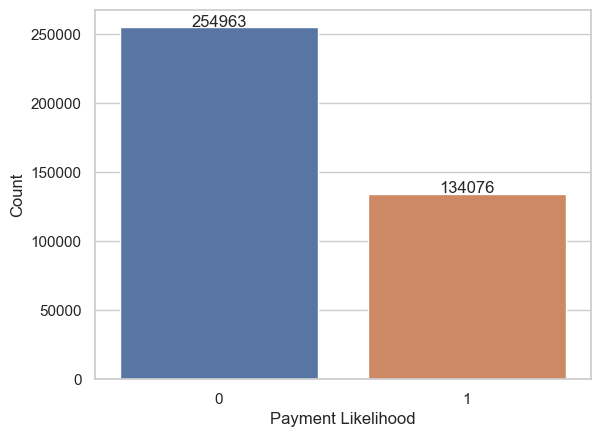

In [26]:
sns.set_theme(style="whitegrid")
title="Penguin species exhibit distinct bill shapes"
ax = sns.countplot(data=df_train, x='IND_BOM_1_2')
ax.set(xlabel='Payment Likelihood', ylabel='Count')
for p in ax.patches:
  ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 4), textcoords = 'offset points')
plt.show()

### Set de Treino e Validação

Separamos os dados em set treino e validação em uma proporação de 70% para 30%, respectivamente (segmentando o target 'IND_BOM_1_2'). Como pretendemos fazer uma mistura dos dados Major e Minor, posteriormente, mantemos o target label no dataset X.

Fazemos uma separação das instâncias com valor do parâmetro analisado.

In [27]:
dfMinor = df_train[df_train['IND_BOM_1_2']==1]
dfMajor = df_train[df_train['IND_BOM_1_2']==0]

Seguimos com a serparação dos dados.

In [28]:
data_train_minor, data_val_minor, _, _ = train_test_split(dfMinor, dfMinor['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [29]:
print(data_train_minor.shape)

(89830, 1377)


In [30]:
print(data_val_minor.shape)

(44246, 1377)


In [31]:
data_train_major, data_val_major, _, _ = train_test_split(dfMajor, dfMajor['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [32]:
print(data_train_major.shape)

(170825, 1377)


In [33]:
print(data_val_major.shape)

(84138, 1377)


### Oversampling

Visto que possuímos uma distribuição desigual de dados por classe, fazemos uma repopulação de instâncias de treino X_train_major até que a quantidade seja equivalente a X_train_minor (Fazemos uma concatenação simples).

In [34]:
difference_train = data_train_major.shape[0] - data_train_minor.shape[0]
difference_train

80995

In [35]:
data_train_minor_sampled = pd.concat([data_train_minor, data_train_minor[:difference_train]])

In [36]:
data_train_minor_sampled.shape

(170825, 1377)

In [37]:
data_train_minor_sampled.shape == data_train_major.shape

True

In [38]:
difference_val = data_val_major.shape[0] - data_val_minor.shape[0]
difference_val

39892

In [39]:
data_val_minor_sampled = pd.concat([data_val_minor, data_val_minor[:difference_val]])

In [40]:
data_val_minor_sampled.shape

(84138, 1377)

In [41]:
data_val_minor_sampled.shape == data_val_major.shape

True

### Concatenação e Randomização dos Dados

A fim de termos os nossos dados balanceados, concatenamos os dados transformados anteriormente instituindo um grau de aleatóriedade nessa inserção.

In [42]:
data_train = pd.concat([data_train_minor_sampled, data_train_major]).sample(frac=1, random_state=42).reset_index(drop=True)

O nosso novo formato para os dados de treino:

In [43]:
data_train.shape

(341650, 1377)

In [44]:
data_train.head(5)

,IDADE,ATIVIDADE_EMAIL,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,QUANTIDADE_VIZINHANCA,CAD_DEMOGRAFICO_VAR_0,CAD_DEMOGRAFICO_VAR_1,...,CEP4_10_1,CEP4_11_0,CEP4_11_1,CEP4_12_0,CEP4_12_1,CEP4_13_0,CEP4_13_1,CEP4_14_0,CEP4_14_1,IND_BOM_1_2
0,0.842974,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.000000,0.438979,0.563592,0.768376,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
1,0.782205,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.000000,0.069795,0.996149,0.147993,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0
2,0.086426,5.881235e-18,0.105588,0.815862,-5.140958e-17,-2.188272e-17,0.000000,0.901305,0.963828,0.818808,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
3,0.174456,5.881235e-18,0.114437,0.850630,-5.140958e-17,1.388212e-01,0.000000,0.001439,0.007059,0.422075,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1
4,0.468022,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.460938,0.285844,0.253787,0.480530,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0


In [45]:
data_val = pd.concat([data_val_minor_sampled, data_val_major]).sample(frac=1, random_state=42).reset_index(drop=True)

O nosso novo formato para os dados de validação:

In [46]:
data_val.shape

(168276, 1377)

In [47]:
data_val.head(5)

,IDADE,ATIVIDADE_EMAIL,ATIVIDADE_ENDERECO,ATUALIZACAO_ENDERECO,ATUALIZACAO_EMAIL,ATIVIDADE_TELEFONE,VALOR_PARCELA_BOLSA_FAMILIA,QUANTIDADE_VIZINHANCA,CAD_DEMOGRAFICO_VAR_0,CAD_DEMOGRAFICO_VAR_1,...,CEP4_10_1,CEP4_11_0,CEP4_11_1,CEP4_12_0,CEP4_12_1,CEP4_13_0,CEP4_13_1,CEP4_14_0,CEP4_14_1,IND_BOM_1_2
0,0.049623,5.881235e-18,0.114437,0.815862,-5.140958e-17,1.388212e-01,0.000000,0.002878,0.765496,0.817017,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
1,0.431731,5.881235e-18,0.147356,0.979968,-5.140958e-17,-2.188272e-17,0.265625,0.006643,0.020444,0.431151,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
2,0.210747,5.881235e-18,0.147356,0.815862,-5.140958e-17,1.388212e-01,0.361979,0.137824,0.032869,0.684290,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0
3,0.295710,1.286145e-01,0.147356,0.398645,1.725542e-01,1.388212e-01,0.000000,0.026731,0.976095,0.994062,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1
4,0.146684,5.881235e-18,0.114437,0.815862,-5.140958e-17,1.388212e-01,0.000000,0.000427,0.337044,0.991561,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1


Temos agora uma distribuição igual de classes nos nossos dados. Com isso, nossos modelos não devem apresentar uma inferência enviesada sobre alguma classe por quesito de frequência.

Text(0.5, 1.0, 'Val')

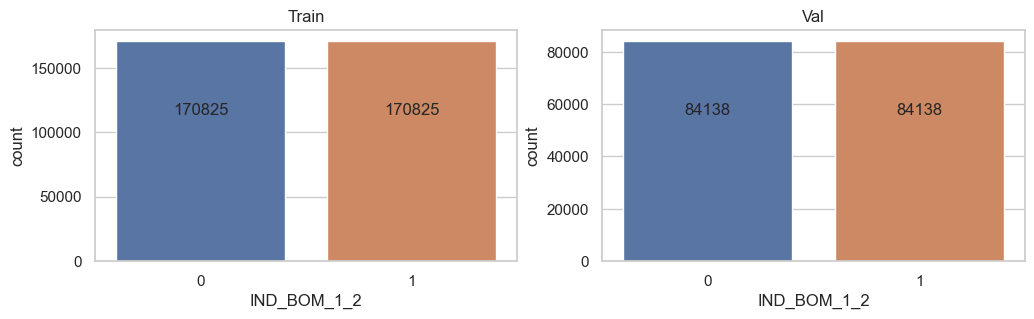

In [48]:
fig = plt.figure(figsize=(12,3))

ax1 = fig.add_subplot(121)
sns.countplot(x=data_train['IND_BOM_1_2'])
for p in ax1.patches:
  ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, -50), textcoords = 'offset points')
plt.title('Train')
ax2 = fig.add_subplot(122)
sns.countplot(x=data_val['IND_BOM_1_2'])
for p in ax2.patches:
  ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, -50), textcoords = 'offset points')
plt.title('Val')

Possuimos, agora, dados balanceados tanto no treino quanto na validação.

Temos as seguintes proporções para os dados de treino, validação e teste, no nosso projeto:

In [49]:
data_train.shape[0]/(data_val.shape[0] + data_train.shape[0] + df_test.shape[0])

0.5341260671968583

In [50]:
data_val.shape[0]/(data_val.shape[0] + data_train.shape[0] + df_test.shape[0])

0.26307799819586863

In [51]:
df_test.shape[0]/(data_val.shape[0] + data_train.shape[0] + df_test.shape[0])

0.20279593460727313

### Normalização dos Dados (MinMaxScaling)

Em relação à análise dos dados por modelos mais tradicionais relativos ao estado da arte de tratamento de dados tabulares, a nossa normalização é feita com a abordagem MinMaxScaler, em que, após a transformação, os dados devem estar compreendidos no intervalo [0,1].

Para isso, calculamos os valores máximos e mínimos do nosso set de Treino, a aplicamos a transformação/normalização para os nossos datasets de validação e teste.

In [52]:
def train_scaler(df):
    scaled_df = df.copy()
    scaler = MinMaxScaler()
    scaled_df[df.columns[:-1]] = scaler.fit_transform(scaled_df[df.columns[:-1]])
    return scaled_df, scaler

In [53]:
def apply_train_scaler(df, scaler):
    scaled_df = df.copy()
    scaled_df[df.columns[:-1]] = scaler.transform(scaled_df[df.columns[:-1]])
    return scaled_df

In [54]:
normalized_train, normal_scaler = train_scaler(data_train)
normalized_val = apply_train_scaler(data_val, normal_scaler)

normalized_test=apply_train_scaler(df_test, normal_scaler)

Como após a normalização alguns podem ficar com valores NaN (caso hajam colunas com apenas 1 valor), vamos preencher esses dados com 0, tanto no dataset de treino, quanto no de validação. (Adendo, essa ação teoricamente não deve gerar mudanças nos nossos dados, mas, por motivos didáticos, iremos realizá-la).

In [55]:
for i in normalized_train.columns:
  if(normalized_train[i].isnull().values.any()):
    normalized_train[i] = normalized_train[i].fillna(0)
  if(normalized_val[i].isnull().values.any()):
    normalized_val[i] = normalized_val[i].fillna(0)
  if(normalized_test[i].isnull().values.any()):
    normalized_test[i] = normalized_test[i].fillna(0)

Conferimos que todos os valores em todos os datasets são não negativos.

In [56]:
(normalized_train >= 0).all().any() and (normalized_val >= 0).all().any() and (normalized_test >= 0).all().any()

True

Trabalhamos com nossos dados base em numpy para realizar a alimentação nos modelos e cálculos estatísticos eficientes.

In [57]:
train_numpy = normalized_train.to_numpy()
val_numpy = normalized_val.to_numpy()
print(f'Our train data has shape: {train_numpy.shape}. Our validation data has shape: {val_numpy.shape}')

test_numpy = normalized_test.to_numpy()
print(f'Our test data has shape: {test_numpy.shape}.')

Our train data has shape: (341650, 1377). Our validation data has shape: (168276, 1377)
Our test data has shape: (129717, 1377).


Os dados devem apresentar um formato específico para serem analisados, o que não constituí um problema.

In [58]:
X_train = train_numpy[:,:-1]
y_train = train_numpy[:,-1].reshape(train_numpy.shape[0],1)

X_val = val_numpy[:,:-1]
y_val = val_numpy[:,-1].reshape(val_numpy.shape[0],1)

X_test =test_numpy[:, :-1]
y_test = test_numpy[:,-1].reshape(test_numpy.shape[0],1)

### Funções Auxiliares

Criamos uma função que retorna as entradas em numpy com o shape correto (-1,1) para saída. Essa função é utilizadas apenas para alimentar uma entrada com o formato correto.

In [59]:
def reshape_plot(y_true, y_hat):
  #print(f'type of y_hat: {type(y_hat)}, type of y_true: {type(y_true)}')
  if not isinstance(y_hat, np.ndarray):
    y_hat = y_hat.to_numpy(dtype=np.float32)
  if not isinstance(y_true, np.ndarray):
    y_true = y_true.to_numpy(dtype=np.float32)

  return y_true.reshape(-1,1), y_hat.reshape(-1,1)

A função *ks_stat* é utilizada para avaliar o modelo durante o treinamento.

In [60]:
def ks_results(y_true, y_pred):
  return ks_2samp(y_pred[y_true == 1], y_pred[y_true != 1]).statistic

A função *testePlot* calcula e exibe as métricas do modelo no conjunto passado para a mesma. Temos a seguinte função de plot:

In [61]:
def testePlot(model, x, y):
  print(f'Gerando análises para o modelo {model}')
  y_pred = model.predict(x)
  y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])
    
  y_pred_score_all = model.predict_proba(x)
  y_pred_score_positive = model.predict_proba(x)[:,1]

  accuracy = accuracy_score(y, y_pred)
  recall = recall_score(y, y_pred)
  precision = precision_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  skplt.metrics.plot_ks_statistic(y, y_pred_score_all)
  plt.show()

  ks = ks_results(reshape_plot(y, y_pred_score_positive)[0], reshape_plot(y, y_pred_score_positive)[1])
  auroc = roc_auc_score(y, y_pred_score_positive)
  cm = confusion_matrix(y, y_pred, labels = np.unique(y))
  cmd = ConfusionMatrixDisplay(cm, display_labels = np.unique(y))
  cmd.plot()
  plt.show()
    
  print()

  print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
  print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
  print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
  print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))

  if auroc is not None:
      print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
      
  print("{metric:<18}{value:.4f}".format(metric="KS:", value=ks))

Para a nossa análise neste projeto, a métrica principal escolhida para ser otimizada pelo **Optuna** foi a estatística de **KS (Kolmogorov-Smirnov)**. Essa métrica nada mais é que uma medida estatística utilizada na avaliação de similaridade entre duas distribuições de probabilidade. Seu cálculo descreve a máxima distância entre as duas funções de distribuição cumulativa (CDF), quando comparadas - que nesse caso faz referência à nossa classe. Tal estatística é comumente utilizada na comparação de dados observados em relação a uma distribuição teórica ou de referência.

Com a comparação estatística do KS com um valor crítico da nossa distribuição de referência, é possível avaliarmos a adequação dos nossos dados amostrais à distribuição teórica.

A métrica é calculada usando a seguinte fórmula:

**KS = max|F(x) - G(x)|**

Onde:

F(x) é a função de distribuição cumulativa empírica (ECDF) dos dados observados.
G(x) é a função de distribuição cumulativa da distribuição teórica/referência sendo comparada.
O máximo (max) é calculado para todos os valores de x.
Em termos práticos e específicos para o nosso problema, a métrica KS compara as diferenças nas formas das distribuições de dois conjuntos de dados. Um valor de KS mais alto indica uma maior dissimilaridade entre as duas distribuições, enquanto um valor menor sugere um maior nível de similaridade. 

Dessa forma, podemos inferir o quão bem nossos modelos estão avaliando a discrepância entre as distribuições de probabilidade das duas amostras(valores "positivos" e "negativos" alcançados por cada modelo em comparação com os valores reais).

Outras métricas também serão calculadas ao longo da análise, como *Área sob a curva ROC (ROC AUC)*, *Acurácia*, *Precisão*, *Recall*, *F1-Score*. Por se tratar de um dataset sofisticado (real), a escolha da métrica a ser otimizada por ser alterada de acordo com os objetivos específicos do projeto.  

A fim de registrarmos os resultados dessa análise, criamos um dataframe "dummy" que deve conter as métricas de cada modelo, bem como o tempo total de otimização de cada modelo:

In [62]:
results = pd.DataFrame({'model': '?','ks': '?', 'roc_auc': '?',\
                            'accuracy': '?', 'precision': '?', \
                            'recall': '?', 'f1': '?',\
                            'time': '?'}, index=[0])

## Experimentação com modelos tradicionais

(*Como mencionado anteoriormente, utilizamos Optuna para otimizar os modelos*)

O Optuna é uma biblioteca de otimização de hiperparâmetros em Python que emprega busca no espaço de parâmetros para descobrir os valores mais adequados para os parâmetros de um modelo ou algoritmo específico. O processo de otimização de parâmetros com o Optuna pode ser subdividido nas seguintes etapas:

Etapa 1: **Definição do Espaço de Busca:** Inicialmente, é necessário definir o espaço de busca para os parâmetros. Isso é realizado por meio da criação de um objeto chamado Trial, que possibilita especificar as variáveis de parâmetros e os intervalos ou distribuições correspondentes a cada uma delas. A definição pode incluir variáveis inteiras entre 1 e 10, ou distribuições uniformes entre 0 e 1, por exemplo.

Etapa 2: **Definição da Função Objetivo:** A função objetivo é a métrica que se pretende otimizar, podendo ser uma medida de perda, acurácia, precisão, recall ou outra métrica relevante para o problema. A função objetivo aceita os valores dos parâmetros como entrada e retorna o valor da métrica a ser aprimorada.

Etapa 3: **Criação do Estudo:** Um estudo é uma coleção de iterações de otimização. Ele mantém registro dos resultados de cada iteração e determina quais parâmetros explorar na próxima iteração com base nos resultados anteriores.

Etapa 4: **Geração de Sugestões de Parâmetros:** Utilizando um algoritmo de busca eficiente chamado "Árvore de Parâmetros Virtuais" (TPE - Tree-structured Parzen Estimator), o Optuna gera sugestões de parâmetros com base nas iterações anteriores. Essas sugestões são empregadas para avaliar o desempenho do modelo sob diferentes conjuntos de parâmetros.

Etapa 5: **Avaliação de Desempenho:** As sugestões de parâmetros geradas são utilizadas para treinar e validar o modelo, permitindo a avaliação de seu desempenho.

Etapa 6: **Atualização do Estudo:** Com base nos resultados da avaliação de desempenho, o estudo é atualizado com os resultados obtidos, permitindo que o Optuna aprenda quais combinações de parâmetros são mais eficazes e quais devem ser consideradas em iterações subsequentes.

Etapa 7: **Repetição das etapas 4 a 6:** As etapas de geração de sugestões de parâmetros, avaliação do desempenho e atualização do estudo são repetidas várias vezes até que o critério de parada seja atingido. O critério de parada pode ser o número máximo de iterações, o tempo máximo de execução ou qualquer outro critério definido pelo usuário.

Etapa 8: **Obtenção dos Melhores Parâmetros:** Ao final do estudo, é possível obter os melhores parâmetros encontrados pelo Optuna, juntamente com o valor da métrica objetivo associada.

Em relação à etapa 4, o algoritmo "Árvore de Parâmetros Virtuais" (TPE - Tree-structured Parzen Estimator) aprende uma função de densidade de probabilidade que estima quais conjuntos de parâmetros são mais promissores com base nos resultados das iterações anteriores. Dessa forma, o Optuna concentra-se nas áreas do espaço de parâmetros que têm maior probabilidade de produzir um resultado adequado.

Quanto aos modelos considerados nessa análise, faremos o uso de:
- Random Forest
- Gradient-Boosting (Vanilla)
- XGBoost (eX*treme Gradient-Boosting)
- Light GBM (Light Gradient-Boosting Machine)

A partir desse ponto, iremos estabelecer os melhores hiper-parâmetros que otimizam nossa métrica selecionada (KS-Statistic) em relação ao conjunto de validação. Ao longo do código, iremos também fazer uma análise de como cada modelo performa quando alimentado com o conjunto de teste. Contudo, essa análise tem um aspecto puramente de inferência, visto que o nosso conjunto de teste deve apenas identificar a adequação do modelo em um cenário "inédito", não devendo fazer parte da seleção/tuning de hiper-parâmetros ou do treino. 

*Em virtude disso, a nossa tabela **results** contempla os valores das métricas em relação ao dados de validação, necessitando que instutuamos uma nova tabela relativa unicamente aos dados de teste ao final do código.*

### Random Forest

Random Forest é um algoritmo de aprendizado de máquina baseado em conjunto que constrói múltiplas árvores de decisão durante o treinamento e combina suas previsões para obter resultados mais robustos e precisos. Cada árvore é treinada em uma amostra aleatória do conjunto de dados e produz uma previsão.

In [63]:
def objective_rf(trial):
    params_rf = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 400),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 4, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
    }

    model = RandomForestClassifier(**params_rf, random_state=42, n_jobs=-1, verbose=2)
    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_val)
    y_pred_score_positive = model.predict_proba(X_val)[:,1]
    """
    if((not np.any(y_pred)) or np.all(y_pred)):
        ks = 0
    else:
    """
    ks = ks_results(reshape_plot(y_val, y_pred_score_positive)[0], reshape_plot(y_val, y_pred_score_positive)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo, e não apenas os melhores parâmetros. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [64]:
def callback_rf(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Iniciamos o nosso estudo:

In [65]:
# Measure the start time
start_time_rf = time.time()

study_rf = optuna.create_study(direction='maximize')

study_rf.optimize(objective_rf, n_trials=n_trials, callbacks=[callback_rf])

print('Number of finished trials:', len(study_rf.trials))
print('Best trial:', study_rf.best_trial.params)

# Measure the end time
end_time_rf = time.time()

# Calculate the duration in seconds
duration_rf = end_time_rf - start_time_rf

[I 2023-09-10 00:46:58,784] A new study created in memory with name: no-name-89507ca0-8377-47b2-8c98-64674afb8664
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 680
building tree 2 of 680
building tree 3 of 680
building tree 4 of 680
building tree 5 of 680
building tree 6 of 680
building tree 7 of 680
building tree 8 of 680
building tree 9 of 680
building tree 10 of 680
building tree 11 of 680
building tree 12 of 680
building tree 13 of 680
building tree 14 of 680
building tree 15 of 680
building tree 16 of 680
building tree 17 of 680
building tree 18 of 680
building tree 19 of 680
building tree 20 of 680
building tree 21 of 680
building tree 22 of 680
building tree 23 of 680
building tree 24 of 680
building tree 25 of 680
building tree 26 of 680
building tree 27 of 680
building tree 28 of 680
building tree 29 of 680
building tree 30 of 680
building tree 31 of 680


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s


building tree 32 of 680
building tree 33 of 680
building tree 34 of 680
building tree 35 of 680
building tree 36 of 680
building tree 37 of 680
building tree 38 of 680
building tree 39 of 680
building tree 40 of 680
building tree 41 of 680
building tree 42 of 680
building tree 43 of 680
building tree 44 of 680
building tree 45 of 680
building tree 46 of 680
building tree 47 of 680
building tree 48 of 680
building tree 49 of 680
building tree 50 of 680
building tree 51 of 680
building tree 52 of 680
building tree 53 of 680
building tree 54 of 680
building tree 55 of 680
building tree 56 of 680
building tree 57 of 680
building tree 58 of 680
building tree 59 of 680
building tree 60 of 680
building tree 61 of 680
building tree 62 of 680
building tree 63 of 680
building tree 64 of 680
building tree 65 of 680
building tree 66 of 680
building tree 67 of 680
building tree 68 of 680
building tree 69 of 680
building tree 70 of 680
building tree 71 of 680
building tree 72 of 680
building tree 73

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   31.9s


building tree 151 of 680
building tree 152 of 680
building tree 153 of 680
building tree 154 of 680
building tree 155 of 680
building tree 156 of 680
building tree 157 of 680
building tree 158 of 680
building tree 159 of 680
building tree 160 of 680
building tree 161 of 680
building tree 162 of 680
building tree 163 of 680
building tree 164 of 680
building tree 165 of 680
building tree 166 of 680
building tree 167 of 680
building tree 168 of 680
building tree 169 of 680
building tree 170 of 680
building tree 171 of 680
building tree 172 of 680
building tree 173 of 680
building tree 174 of 680
building tree 175 of 680
building tree 176 of 680
building tree 177 of 680
building tree 178 of 680
building tree 179 of 680building tree 180 of 680

building tree 181 of 680
building tree 182 of 680
building tree 183 of 680
building tree 184 of 680
building tree 185 of 680
building tree 186 of 680
building tree 187 of 680
building tree 188 of 680
building tree 189 of 680
building tree 190 of 680


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.3min


building tree 354 of 680
building tree 355 of 680
building tree 356 of 680
building tree 357 of 680
building tree 358 of 680
building tree 359 of 680
building tree 360 of 680
building tree 361 of 680
building tree 362 of 680
building tree 363 of 680
building tree 364 of 680
building tree 365 of 680
building tree 366 of 680
building tree 367 of 680
building tree 368 of 680
building tree 369 of 680
building tree 370 of 680
building tree 371 of 680
building tree 372 of 680
building tree 373 of 680
building tree 374 of 680
building tree 375 of 680
building tree 376 of 680
building tree 377 of 680
building tree 378 of 680
building tree 379 of 680
building tree 380 of 680
building tree 381 of 680
building tree 382 of 680
building tree 383 of 680
building tree 384 of 680
building tree 385 of 680
building tree 386 of 680
building tree 387 of 680
building tree 388 of 680
building tree 389 of 680
building tree 390 of 680
building tree 391 of 680
building tree 392 of 680
building tree 393 of 680


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.4min


building tree 638 of 680
building tree 639 of 680
building tree 640 of 680
building tree 641 of 680
building tree 642 of 680
building tree 643 of 680
building tree 644 of 680
building tree 645 of 680
building tree 646 of 680
building tree 647 of 680
building tree 648 of 680
building tree 649 of 680
building tree 650 of 680
building tree 651 of 680
building tree 652 of 680
building tree 653 of 680
building tree 654 of 680
building tree 655 of 680
building tree 656 of 680
building tree 657 of 680
building tree 658 of 680
building tree 659 of 680
building tree 660 of 680
building tree 661 of 680
building tree 662 of 680
building tree 663 of 680
building tree 664 of 680
building tree 665 of 680
building tree 666 of 680
building tree 667 of 680
building tree 668 of 680
building tree 669 of 680
building tree 670 of 680
building tree 671 of 680
building tree 672 of 680
building tree 673 of 680
building tree 674 of 680
building tree 675 of 680
building tree 676 of 680
building tree 677 of 680


[Parallel(n_jobs=-1)]: Done 680 out of 680 | elapsed:  2.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 680 out of 680 | elapsed:    2.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 680 out of 680 | elapsed:    2.1s finished
[I 2023-09-10 00:49:39,404] Trial 0 finished with value: 0.2493403693931398 and parameters: {'n_estimators': 680, 'criterion': 

building tree 1 of 478
building tree 2 of 478
building tree 3 of 478
building tree 4 of 478
building tree 5 of 478
building tree 6 of 478
building tree 7 of 478
building tree 8 of 478
building tree 9 of 478
building tree 10 of 478
building tree 11 of 478
building tree 12 of 478
building tree 13 of 478
building tree 14 of 478
building tree 15 of 478
building tree 16 of 478
building tree 17 of 478
building tree 18 of 478
building tree 19 of 478
building tree 20 of 478
building tree 21 of 478
building tree 22 of 478
building tree 23 of 478
building tree 24 of 478
building tree 25 of 478
building tree 26 of 478
building tree 27 of 478
building tree 28 of 478
building tree 29 of 478


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.9min


building tree 30 of 478
building tree 31 of 478
building tree 32 of 478
building tree 33 of 478
building tree 34 of 478
building tree 35 of 478
building tree 36 of 478
building tree 37 of 478
building tree 38 of 478
building tree 39 of 478
building tree 40 of 478
building tree 41 of 478
building tree 42 of 478
building tree 43 of 478
building tree 44 of 478
building tree 45 of 478
building tree 46 of 478
building tree 47 of 478
building tree 48 of 478
building tree 49 of 478
building tree 50 of 478
building tree 51 of 478
building tree 52 of 478
building tree 53 of 478
building tree 54 of 478
building tree 55 of 478
building tree 56 of 478
building tree 57 of 478
building tree 58 of 478
building tree 59 of 478
building tree 60 of 478
building tree 61 of 478
building tree 62 of 478
building tree 63 of 478
building tree 64 of 478
building tree 65 of 478
building tree 66 of 478
building tree 67 of 478
building tree 68 of 478
building tree 69 of 478
building tree 70 of 478
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 35.8min


building tree 151 of 478
building tree 152 of 478
building tree 153 of 478
building tree 154 of 478
building tree 155 of 478
building tree 156 of 478
building tree 157 of 478
building tree 158 of 478
building tree 159 of 478
building tree 160 of 478
building tree 161 of 478
building tree 162 of 478
building tree 163 of 478
building tree 164 of 478
building tree 165 of 478
building tree 166 of 478
building tree 167 of 478
building tree 168 of 478
building tree 169 of 478
building tree 170 of 478
building tree 171 of 478
building tree 172 of 478
building tree 173 of 478
building tree 174 of 478
building tree 175 of 478
building tree 176 of 478
building tree 177 of 478
building tree 178 of 478
building tree 179 of 478
building tree 180 of 478
building tree 181 of 478
building tree 182 of 478
building tree 183 of 478
building tree 184 of 478
building tree 185 of 478
building tree 186 of 478
building tree 187 of 478
building tree 188 of 478
building tree 189 of 478
building tree 190 of 478


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 86.6min


building tree 354 of 478
building tree 355 of 478
building tree 356 of 478
building tree 357 of 478
building tree 358 of 478
building tree 359 of 478
building tree 360 of 478
building tree 361 of 478
building tree 362 of 478
building tree 363 of 478
building tree 364 of 478
building tree 365 of 478
building tree 366 of 478
building tree 367 of 478
building tree 368 of 478
building tree 369 of 478
building tree 370 of 478
building tree 371 of 478
building tree 372 of 478
building tree 373 of 478
building tree 374 of 478
building tree 375 of 478
building tree 376 of 478
building tree 377 of 478
building tree 378 of 478
building tree 379 of 478
building tree 380 of 478
building tree 381 of 478
building tree 382 of 478
building tree 383 of 478
building tree 384 of 478
building tree 385 of 478
building tree 386 of 478
building tree 387 of 478
building tree 388 of 478
building tree 389 of 478
building tree 390 of 478
building tree 391 of 478
building tree 392 of 478
building tree 393 of 478


[Parallel(n_jobs=-1)]: Done 478 out of 478 | elapsed: 120.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 478 out of 478 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 478 out of 478 | elapsed:    3.2s finished
[I 2023-09-10 02:49:48,768] Trial 1 finished with value: 0.2960136917920559 and parameters: {'n_estimators': 478, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 54, 'min_samples_leaf': 50, 'max_features': None, 'class_weight': 'balance

building tree 1 of 450
building tree 2 of 450
building tree 3 of 450
building tree 4 of 450
building tree 5 of 450
building tree 6 of 450
building tree 7 of 450
building tree 8 of 450
building tree 9 of 450
building tree 10 of 450
building tree 11 of 450
building tree 12 of 450
building tree 13 of 450
building tree 14 of 450
building tree 15 of 450
building tree 16 of 450
building tree 17 of 450
building tree 18 of 450
building tree 19 of 450
building tree 20 of 450
building tree 21 of 450
building tree 22 of 450
building tree 23 of 450
building tree 24 of 450
building tree 25 of 450
building tree 26 of 450
building tree 27 of 450
building tree 28 of 450
building tree 29 of 450


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.5min


building tree 30 of 450
building tree 31 of 450
building tree 32 of 450
building tree 33 of 450
building tree 34 of 450
building tree 35 of 450
building tree 36 of 450
building tree 37 of 450
building tree 38 of 450
building tree 39 of 450
building tree 40 of 450
building tree 41 of 450
building tree 42 of 450
building tree 43 of 450
building tree 44 of 450
building tree 45 of 450
building tree 46 of 450
building tree 47 of 450
building tree 48 of 450
building tree 49 of 450
building tree 50 of 450
building tree 51 of 450
building tree 52 of 450
building tree 53 of 450
building tree 54 of 450
building tree 55 of 450
building tree 56 of 450
building tree 57 of 450
building tree 58 of 450
building tree 59 of 450
building tree 60 of 450
building tree 61 of 450
building tree 62 of 450
building tree 63 of 450
building tree 64 of 450
building tree 65 of 450
building tree 66 of 450
building tree 67 of 450
building tree 68 of 450
building tree 69 of 450
building tree 70 of 450
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 33.1min


building tree 151 of 450
building tree 152 of 450
building tree 153 of 450
building tree 154 of 450
building tree 155 of 450
building tree 156 of 450
building tree 157 of 450
building tree 158 of 450
building tree 159 of 450
building tree 160 of 450
building tree 161 of 450
building tree 162 of 450
building tree 163 of 450
building tree 164 of 450
building tree 165 of 450
building tree 166 of 450
building tree 167 of 450
building tree 168 of 450
building tree 169 of 450
building tree 170 of 450
building tree 171 of 450
building tree 172 of 450
building tree 173 of 450
building tree 174 of 450
building tree 175 of 450
building tree 176 of 450
building tree 177 of 450
building tree 178 of 450
building tree 179 of 450
building tree 180 of 450
building tree 181 of 450
building tree 182 of 450
building tree 183 of 450
building tree 184 of 450
building tree 185 of 450
building tree 186 of 450
building tree 187 of 450
building tree 188 of 450
building tree 189 of 450
building tree 190 of 450


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 79.7min


building tree 354 of 450
building tree 355 of 450
building tree 356 of 450
building tree 357 of 450
building tree 358 of 450
building tree 359 of 450
building tree 360 of 450
building tree 361 of 450
building tree 362 of 450
building tree 363 of 450
building tree 364 of 450
building tree 365 of 450
building tree 366 of 450
building tree 367 of 450
building tree 368 of 450
building tree 369 of 450
building tree 370 of 450
building tree 371 of 450
building tree 372 of 450
building tree 373 of 450
building tree 374 of 450
building tree 375 of 450
building tree 376 of 450
building tree 377 of 450
building tree 378 of 450
building tree 379 of 450
building tree 380 of 450
building tree 381 of 450
building tree 382 of 450
building tree 383 of 450
building tree 384 of 450
building tree 385 of 450
building tree 386 of 450
building tree 387 of 450
building tree 388 of 450
building tree 389 of 450
building tree 390 of 450
building tree 391 of 450
building tree 392 of 450
building tree 393 of 450


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 103.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 450 out of 450 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 450 out of 450 | elapsed:    2.6s finished
[I 2023-09-10 04:33:27,894] Trial 2 finished with value: 0.2959661508474174 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 18, 'min_samples_split': 325, 'min_samples_leaf': 50, 'max_features': None, 'class_weight': 'balanc

building tree 1 of 123
building tree 2 of 123
building tree 3 of 123
building tree 4 of 123
building tree 5 of 123
building tree 6 of 123
building tree 7 of 123
building tree 8 of 123
building tree 9 of 123
building tree 10 of 123
building tree 11 of 123
building tree 12 of 123
building tree 13 of 123
building tree 14 of 123
building tree 15 of 123
building tree 16 of 123
building tree 17 of 123
building tree 18 of 123
building tree 19 of 123
building tree 20 of 123
building tree 21 of 123
building tree 22 of 123
building tree 23 of 123
building tree 24 of 123
building tree 25 of 123
building tree 26 of 123
building tree 27 of 123
building tree 28 of 123
building tree 29 of 123


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min


building tree 30 of 123
building tree 31 of 123
building tree 32 of 123
building tree 33 of 123
building tree 34 of 123
building tree 35 of 123
building tree 36 of 123
building tree 37 of 123
building tree 38 of 123
building tree 39 of 123
building tree 40 of 123
building tree 41 of 123
building tree 42 of 123
building tree 43 of 123
building tree 44 of 123
building tree 45 of 123
building tree 46 of 123
building tree 47 of 123
building tree 48 of 123
building tree 49 of 123
building tree 50 of 123
building tree 51 of 123
building tree 52 of 123
building tree 53 of 123
building tree 54 of 123
building tree 55 of 123
building tree 56 of 123
building tree 57 of 123
building tree 58 of 123
building tree 59 of 123
building tree 60 of 123
building tree 61 of 123
building tree 62 of 123
building tree 63 of 123
building tree 64 of 123
building tree 65 of 123
building tree 66 of 123
building tree 67 of 123
building tree 68 of 123
building tree 69 of 123
building tree 70 of 123
building tree 71

[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:  8.2min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 123 out of 123 | elapsed:    0.2s finished
[I 2023-09-10 04:41:45,220] Trial 3 finished with value: 0.2321067769616582 and parameters: {'n_estimators': 123, 'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 360, 'min_samples_leaf': 32, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.2960136917920559.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 375
building tree 2 of 375
building tree 3 of 375
building tree 4 of 375
building tree 5 of 375
building tree 6 of 375
building tree 7 of 375
building tree 8 of 375
building tree 9 of 375
building tree 10 of 375
building tree 11 of 375
building tree 12 of 375
building tree 13 of 375
building tree 14 of 375
building tree 15 of 375
building tree 16 of 375
building tree 17 of 375
building tree 18 of 375
building tree 19 of 375
building tree 20 of 375
building tree 21 of 375
building tree 22 of 375
building tree 23 of 375
building tree 24 of 375
building tree 25 of 375
building tree 26 of 375
building tree 27 of 375
building tree 28 of 375
building tree 29 of 375


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.0min


building tree 30 of 375
building tree 31 of 375
building tree 32 of 375
building tree 33 of 375
building tree 34 of 375
building tree 35 of 375
building tree 36 of 375
building tree 37 of 375
building tree 38 of 375
building tree 39 of 375
building tree 40 of 375
building tree 41 of 375
building tree 42 of 375
building tree 43 of 375
building tree 44 of 375
building tree 45 of 375
building tree 46 of 375
building tree 47 of 375
building tree 48 of 375
building tree 49 of 375
building tree 50 of 375
building tree 51 of 375
building tree 52 of 375
building tree 53 of 375
building tree 54 of 375
building tree 55 of 375
building tree 56 of 375
building tree 57 of 375
building tree 58 of 375
building tree 59 of 375
building tree 60 of 375
building tree 61 of 375
building tree 62 of 375
building tree 63 of 375
building tree 64 of 375
building tree 65 of 375
building tree 66 of 375
building tree 67 of 375
building tree 68 of 375
building tree 69 of 375
building tree 70 of 375
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 30.1min


building tree 151 of 375
building tree 152 of 375
building tree 153 of 375
building tree 154 of 375
building tree 155 of 375
building tree 156 of 375
building tree 157 of 375
building tree 158 of 375
building tree 159 of 375
building tree 160 of 375
building tree 161 of 375
building tree 162 of 375
building tree 163 of 375
building tree 164 of 375
building tree 165 of 375
building tree 166 of 375
building tree 167 of 375
building tree 168 of 375
building tree 169 of 375
building tree 170 of 375
building tree 171 of 375
building tree 172 of 375
building tree 173 of 375
building tree 174 of 375
building tree 175 of 375
building tree 176 of 375
building tree 177 of 375
building tree 178 of 375
building tree 179 of 375
building tree 180 of 375
building tree 181 of 375
building tree 182 of 375
building tree 183 of 375
building tree 184 of 375
building tree 185 of 375
building tree 186 of 375
building tree 187 of 375
building tree 188 of 375
building tree 189 of 375
building tree 190 of 375


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 72.7min


building tree 354 of 375
building tree 355 of 375
building tree 356 of 375
building tree 357 of 375
building tree 358 of 375
building tree 359 of 375
building tree 360 of 375
building tree 361 of 375
building tree 362 of 375
building tree 363 of 375
building tree 364 of 375
building tree 365 of 375
building tree 366 of 375
building tree 367 of 375
building tree 368 of 375
building tree 369 of 375
building tree 370 of 375
building tree 371 of 375
building tree 372 of 375
building tree 373 of 375
building tree 374 of 375
building tree 375 of 375


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 79.4min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 375 out of 375 | elapsed:    2.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.8s
[Parallel(n_jobs=12)]: Done 375 out of 375 | elapsed:    2.0s finished
[I 2023-09-10 06:01:15,396] Trial 4 finished with value: 0.2944686110913024 and parameters: {'n_estimators': 375, 'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 396, 'min_samples_leaf': 9, 'max_features': None, 'class_weight': 'balanced_su

building tree 1 of 600
building tree 2 of 600
building tree 3 of 600
building tree 4 of 600
building tree 5 of 600
building tree 6 of 600
building tree 7 of 600
building tree 8 of 600
building tree 9 of 600
building tree 10 of 600
building tree 11 of 600
building tree 12 of 600
building tree 13 of 600
building tree 14 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 22 of 600
building tree 23 of 600
building tree 24 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600
building tree 29 of 600


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s


building tree 30 of 600building tree 31 of 600

building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 36 of 600
building tree 37 of 600
building tree 38 of 600
building tree 39 of 600
building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
building tree 43 of 600
building tree 44 of 600
building tree 45 of 600
building tree 46 of 600
building tree 47 of 600
building tree 48 of 600
building tree 49 of 600
building tree 50 of 600
building tree 51 of 600
building tree 52 of 600
building tree 53 of 600
building tree 54 of 600
building tree 55 of 600
building tree 56 of 600
building tree 57 of 600
building tree 58 of 600
building tree 59 of 600
building tree 60 of 600
building tree 61 of 600
building tree 62 of 600
building tree 63 of 600
building tree 64 of 600
building tree 65 of 600
building tree 66 of 600
building tree 67 of 600
building tree 68 of 600
building tree 69 of 600
building tree 70 of 600
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   47.5s


building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600
building tree 173 of 600
building tree 174 of 600
building tree 175 of 600
building tree 176 of 600
building tree 177 of 600
building tree 178 of 600
building tree 179 of 600
building tree 180 of 600
building tree 181 of 600
building tree 182 of 600
building tree 183 of 600
building tree 184 of 600
building tree 185 of 600
building tree 186 of 600
building tree 187 of 600
building tree 188 of 600
building tree 189 of 600
building tree 190 of 600building tree 191 of 600

building tree 192 of 600
building tree 193 of 600


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.9min


building tree 354 of 600
building tree 355 of 600
building tree 356 of 600
building tree 357 of 600
building tree 358 of 600
building tree 359 of 600
building tree 360 of 600
building tree 361 of 600
building tree 362 of 600
building tree 363 of 600
building tree 364 of 600
building tree 365 of 600
building tree 366 of 600
building tree 367 of 600
building tree 368 of 600
building tree 369 of 600
building tree 370 of 600
building tree 371 of 600
building tree 372 of 600
building tree 373 of 600
building tree 374 of 600
building tree 375 of 600
building tree 376 of 600
building tree 377 of 600
building tree 378 of 600
building tree 379 of 600
building tree 380 of 600
building tree 381 of 600
building tree 382 of 600
building tree 383 of 600
building tree 384 of 600
building tree 385 of 600
building tree 386 of 600
building tree 387 of 600
building tree 388 of 600
building tree 389 of 600
building tree 390 of 600
building tree 391 of 600
building tree 392 of 600
building tree 393 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.5s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    2.8s finished
[I 2023-09-10 06:04:41,770] Trial 5 finished with value: 0.2648149468729944 and parameters: {'n_estimators': 600, 'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 144, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'class_weight': 'balanced

building tree 1 of 371
building tree 2 of 371
building tree 3 of 371
building tree 4 of 371
building tree 5 of 371
building tree 6 of 371
building tree 7 of 371
building tree 8 of 371
building tree 9 of 371
building tree 10 of 371
building tree 11 of 371
building tree 12 of 371
building tree 13 of 371
building tree 14 of 371
building tree 15 of 371
building tree 16 of 371
building tree 17 of 371
building tree 18 of 371
building tree 19 of 371
building tree 20 of 371
building tree 21 of 371
building tree 22 of 371
building tree 23 of 371
building tree 24 of 371
building tree 25 of 371
building tree 26 of 371
building tree 27 of 371
building tree 28 of 371
building tree 29 of 371


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.7min


building tree 30 of 371
building tree 31 of 371
building tree 32 of 371
building tree 33 of 371
building tree 34 of 371
building tree 35 of 371
building tree 36 of 371
building tree 37 of 371
building tree 38 of 371
building tree 39 of 371
building tree 40 of 371
building tree 41 of 371
building tree 42 of 371
building tree 43 of 371
building tree 44 of 371
building tree 45 of 371
building tree 46 of 371
building tree 47 of 371
building tree 48 of 371
building tree 49 of 371
building tree 50 of 371
building tree 51 of 371
building tree 52 of 371
building tree 53 of 371
building tree 54 of 371
building tree 55 of 371
building tree 56 of 371
building tree 57 of 371
building tree 58 of 371
building tree 59 of 371
building tree 60 of 371
building tree 61 of 371
building tree 62 of 371
building tree 63 of 371
building tree 64 of 371
building tree 65 of 371
building tree 66 of 371
building tree 67 of 371
building tree 68 of 371
building tree 69 of 371
building tree 70 of 371
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 28.5min


building tree 151 of 371
building tree 152 of 371
building tree 153 of 371
building tree 154 of 371
building tree 155 of 371
building tree 156 of 371
building tree 157 of 371
building tree 158 of 371
building tree 159 of 371
building tree 160 of 371
building tree 161 of 371
building tree 162 of 371
building tree 163 of 371
building tree 164 of 371
building tree 165 of 371
building tree 166 of 371
building tree 167 of 371
building tree 168 of 371
building tree 169 of 371
building tree 170 of 371
building tree 171 of 371
building tree 172 of 371
building tree 173 of 371
building tree 174 of 371
building tree 175 of 371
building tree 176 of 371
building tree 177 of 371
building tree 178 of 371
building tree 179 of 371
building tree 180 of 371
building tree 181 of 371
building tree 182 of 371
building tree 183 of 371
building tree 184 of 371
building tree 185 of 371
building tree 186 of 371
building tree 187 of 371
building tree 188 of 371
building tree 189 of 371
building tree 190 of 371


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 68.6min


building tree 354 of 371
building tree 355 of 371
building tree 356 of 371
building tree 357 of 371
building tree 358 of 371
building tree 359 of 371
building tree 360 of 371
building tree 361 of 371
building tree 362 of 371
building tree 363 of 371
building tree 364 of 371
building tree 365 of 371
building tree 366 of 371
building tree 367 of 371
building tree 368 of 371
building tree 369 of 371
building tree 370 of 371
building tree 371 of 371


[Parallel(n_jobs=-1)]: Done 371 out of 371 | elapsed: 73.5min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 371 out of 371 | elapsed:    1.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 371 out of 371 | elapsed:    1.8s finished
[I 2023-09-10 07:18:16,999] Trial 6 finished with value: 0.29241246523568426 and parameters: {'n_estimators': 371, 'criterion': 'log_loss', 'max_depth': 12, 'min_samples_split': 114, 'min_samples_leaf': 49, 'max_features': None, 'class_weight': 'balan

building tree 1 of 135
building tree 2 of 135
building tree 3 of 135
building tree 4 of 135
building tree 5 of 135
building tree 6 of 135
building tree 7 of 135
building tree 8 of 135
building tree 9 of 135
building tree 10 of 135
building tree 11 of 135
building tree 12 of 135
building tree 13 of 135
building tree 14 of 135
building tree 15 of 135
building tree 16 of 135
building tree 17 of 135
building tree 18 of 135
building tree 19 of 135
building tree 20 of 135
building tree 21 of 135
building tree 22 of 135
building tree 23 of 135
building tree 24 of 135
building tree 25 of 135
building tree 26 of 135
building tree 27 of 135
building tree 28 of 135
building tree 29 of 135
building tree 30 of 135
building tree 31 of 135
building tree 32 of 135
building tree 33 of 135


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s


building tree 34 of 135
building tree 35 of 135
building tree 36 of 135
building tree 37 of 135
building tree 38 of 135
building tree 39 of 135
building tree 40 of 135
building tree 41 of 135
building tree 42 of 135
building tree 43 of 135
building tree 44 of 135
building tree 45 of 135
building tree 46 of 135
building tree 47 of 135
building tree 48 of 135
building tree 49 of 135
building tree 50 of 135
building tree 51 of 135
building tree 52 of 135
building tree 53 of 135
building tree 54 of 135
building tree 55 of 135
building tree 56 of 135
building tree 57 of 135
building tree 58 of 135
building tree 59 of 135
building tree 60 of 135
building tree 61 of 135
building tree 62 of 135
building tree 63 of 135
building tree 64 of 135
building tree 65 of 135
building tree 66 of 135
building tree 67 of 135
building tree 68 of 135
building tree 69 of 135
building tree 70 of 135
building tree 71 of 135
building tree 72 of 135
building tree 73 of 135
building tree 74 of 135
building tree 75

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    4.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 135 out of 135 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 135 out of 135 | elapsed:    0.2s finished
[I 2023-09-10 07:18:25,942] Trial 7 finished with value: 0.1959518885640258 and parameters: {'n_estimators': 135, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 48, 'min_samples_leaf': 36, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.2960136917920559.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 679
building tree 2 of 679
building tree 3 of 679
building tree 4 of 679
building tree 5 of 679
building tree 6 of 679
building tree 7 of 679
building tree 8 of 679
building tree 9 of 679
building tree 10 of 679
building tree 11 of 679
building tree 12 of 679
building tree 13 of 679
building tree 14 of 679
building tree 15 of 679
building tree 16 of 679
building tree 17 of 679
building tree 18 of 679
building tree 19 of 679
building tree 20 of 679
building tree 21 of 679
building tree 22 of 679
building tree 23 of 679
building tree 24 of 679
building tree 25 of 679
building tree 26 of 679
building tree 27 of 679
building tree 28 of 679
building tree 29 of 679


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min


building tree 30 of 679
building tree 31 of 679
building tree 32 of 679
building tree 33 of 679
building tree 34 of 679
building tree 35 of 679
building tree 36 of 679
building tree 37 of 679
building tree 38 of 679
building tree 39 of 679
building tree 40 of 679
building tree 41 of 679
building tree 42 of 679
building tree 43 of 679
building tree 44 of 679
building tree 45 of 679
building tree 46 of 679
building tree 47 of 679
building tree 48 of 679
building tree 49 of 679
building tree 50 of 679
building tree 51 of 679
building tree 52 of 679
building tree 53 of 679
building tree 54 of 679
building tree 55 of 679
building tree 56 of 679
building tree 57 of 679
building tree 58 of 679
building tree 59 of 679
building tree 60 of 679
building tree 61 of 679
building tree 62 of 679
building tree 63 of 679
building tree 64 of 679
building tree 65 of 679
building tree 66 of 679
building tree 67 of 679
building tree 68 of 679
building tree 69 of 679
building tree 70 of 679
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  9.5min


building tree 152 of 679
building tree 153 of 679
building tree 154 of 679
building tree 155 of 679
building tree 156 of 679
building tree 157 of 679
building tree 158 of 679
building tree 159 of 679
building tree 160 of 679
building tree 161 of 679
building tree 162 of 679
building tree 163 of 679
building tree 164 of 679
building tree 165 of 679
building tree 166 of 679
building tree 167 of 679
building tree 168 of 679
building tree 169 of 679
building tree 170 of 679
building tree 171 of 679
building tree 172 of 679
building tree 173 of 679
building tree 174 of 679
building tree 175 of 679
building tree 176 of 679
building tree 177 of 679
building tree 178 of 679
building tree 179 of 679
building tree 180 of 679
building tree 181 of 679
building tree 182 of 679
building tree 183 of 679
building tree 184 of 679
building tree 185 of 679
building tree 186 of 679
building tree 187 of 679
building tree 188 of 679
building tree 189 of 679
building tree 190 of 679
building tree 191 of 679


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 22.9min


building tree 354 of 679
building tree 355 of 679
building tree 356 of 679
building tree 357 of 679
building tree 358 of 679
building tree 359 of 679
building tree 360 of 679
building tree 361 of 679
building tree 362 of 679
building tree 363 of 679
building tree 364 of 679
building tree 365 of 679
building tree 366 of 679
building tree 367 of 679
building tree 368 of 679
building tree 369 of 679
building tree 370 of 679
building tree 371 of 679
building tree 372 of 679
building tree 373 of 679
building tree 374 of 679
building tree 375 of 679
building tree 376 of 679
building tree 377 of 679
building tree 378 of 679
building tree 379 of 679
building tree 380 of 679
building tree 381 of 679
building tree 382 of 679
building tree 383 of 679
building tree 384 of 679
building tree 385 of 679
building tree 386 of 679
building tree 387 of 679
building tree 388 of 679
building tree 389 of 679
building tree 390 of 679
building tree 391 of 679
building tree 392 of 679
building tree 393 of 679


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 41.6min


building tree 637 of 679
building tree 638 of 679
building tree 639 of 679
building tree 640 of 679
building tree 641 of 679
building tree 642 of 679
building tree 643 of 679
building tree 644 of 679
building tree 645 of 679
building tree 646 of 679
building tree 647 of 679
building tree 648 of 679
building tree 649 of 679
building tree 650 of 679
building tree 651 of 679
building tree 652 of 679
building tree 653 of 679
building tree 654 of 679
building tree 655 of 679
building tree 656 of 679
building tree 657 of 679
building tree 658 of 679
building tree 659 of 679
building tree 660 of 679
building tree 661 of 679
building tree 662 of 679
building tree 663 of 679
building tree 664 of 679
building tree 665 of 679
building tree 666 of 679
building tree 667 of 679
building tree 668 of 679
building tree 669 of 679
building tree 670 of 679
building tree 671 of 679
building tree 672 of 679
building tree 673 of 679
building tree 674 of 679
building tree 675 of 679
building tree 676 of 679


[Parallel(n_jobs=-1)]: Done 679 out of 679 | elapsed: 45.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 679 out of 679 | elapsed:    1.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 679 out of 679 | elapsed:    1.3s finished
[I 2023-09-10 08:03:30,675] Trial 8 finished with value: 0.23184530176614615 and parameters: {'n_estimators': 679, 'criterion':

building tree 1 of 330
building tree 2 of 330
building tree 3 of 330
building tree 4 of 330
building tree 5 of 330
building tree 6 of 330
building tree 7 of 330
building tree 8 of 330
building tree 9 of 330
building tree 10 of 330
building tree 11 of 330
building tree 12 of 330
building tree 13 of 330
building tree 14 of 330
building tree 15 of 330
building tree 16 of 330
building tree 17 of 330
building tree 18 of 330
building tree 19 of 330
building tree 20 of 330
building tree 21 of 330
building tree 22 of 330
building tree 23 of 330
building tree 24 of 330
building tree 25 of 330
building tree 26 of 330
building tree 27 of 330
building tree 28 of 330
building tree 29 of 330
building tree 30 of 330
building tree 31 of 330


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.9s


building tree 32 of 330
building tree 33 of 330
building tree 34 of 330
building tree 35 of 330
building tree 36 of 330
building tree 37 of 330
building tree 38 of 330
building tree 39 of 330
building tree 40 of 330
building tree 41 of 330
building tree 42 of 330
building tree 43 of 330
building tree 44 of 330
building tree 45 of 330
building tree 46 of 330
building tree 47 of 330
building tree 48 of 330
building tree 49 of 330
building tree 50 of 330
building tree 51 of 330
building tree 52 of 330
building tree 53 of 330
building tree 54 of 330
building tree 55 of 330
building tree 56 of 330
building tree 57 of 330
building tree 58 of 330
building tree 59 of 330
building tree 60 of 330
building tree 61 of 330
building tree 62 of 330
building tree 63 of 330
building tree 64 of 330
building tree 65 of 330
building tree 66 of 330
building tree 67 of 330
building tree 68 of 330
building tree 69 of 330
building tree 70 of 330
building tree 71 of 330
building tree 72 of 330
building tree 73

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min


building tree 152 of 330
building tree 153 of 330
building tree 154 of 330
building tree 155 of 330
building tree 156 of 330
building tree 157 of 330
building tree 158 of 330
building tree 159 of 330
building tree 160 of 330
building tree 161 of 330
building tree 162 of 330
building tree 163 of 330
building tree 164 of 330
building tree 165 of 330
building tree 166 of 330
building tree 167 of 330
building tree 168 of 330
building tree 169 of 330
building tree 170 of 330
building tree 171 of 330
building tree 172 of 330
building tree 173 of 330
building tree 174 of 330
building tree 175 of 330
building tree 176 of 330
building tree 177 of 330
building tree 178 of 330
building tree 179 of 330
building tree 180 of 330
building tree 181 of 330
building tree 182 of 330
building tree 183 of 330
building tree 184 of 330
building tree 185 of 330
building tree 186 of 330
building tree 187 of 330
building tree 188 of 330
building tree 189 of 330
building tree 190 of 330
building tree 191 of 330


[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:  2.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 330 out of 330 | elapsed:    2.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 330 out of 330 | elapsed:    2.4s finished
[I 2023-09-10 08:06:15,110] Trial 9 finished with value: 0.2759751836268987 and parameters: {'n_estimators': 330, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 42, 'min_samples_leaf': 21, 'max_features': 'sqrt', 'class_weight': None}. Best is trial 1 with value: 0.2960136917920559.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent worker

building tree 1 of 575
building tree 2 of 575
building tree 3 of 575
building tree 4 of 575
building tree 5 of 575
building tree 6 of 575
building tree 7 of 575
building tree 8 of 575
building tree 9 of 575
building tree 10 of 575
building tree 11 of 575
building tree 12 of 575
building tree 13 of 575
building tree 14 of 575
building tree 15 of 575
building tree 16 of 575
building tree 17 of 575
building tree 18 of 575
building tree 19 of 575
building tree 20 of 575
building tree 21 of 575
building tree 22 of 575
building tree 23 of 575
building tree 24 of 575
building tree 25 of 575
building tree 26 of 575
building tree 27 of 575
building tree 28 of 575
building tree 29 of 575
building tree 30 of 575
building tree 31 of 575
building tree 32 of 575


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


building tree 33 of 575
building tree 34 of 575
building tree 35 of 575
building tree 36 of 575
building tree 37 of 575
building tree 38 of 575
building tree 39 of 575
building tree 40 of 575
building tree 41 of 575
building tree 42 of 575
building tree 43 of 575
building tree 44 of 575
building tree 45 of 575
building tree 46 of 575
building tree 47 of 575
building tree 48 of 575
building tree 49 of 575
building tree 50 of 575
building tree 51 of 575
building tree 52 of 575
building tree 53 of 575
building tree 54 of 575
building tree 55 of 575
building tree 56 of 575
building tree 57 of 575
building tree 58 of 575
building tree 59 of 575
building tree 60 of 575
building tree 61 of 575
building tree 62 of 575
building tree 63 of 575
building tree 64 of 575
building tree 65 of 575
building tree 66 of 575
building tree 67 of 575
building tree 68 of 575
building tree 69 of 575
building tree 70 of 575
building tree 71 of 575
building tree 72 of 575
building tree 73 of 575
building tree 74

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   23.4s


building tree 152 of 575
building tree 153 of 575
building tree 154 of 575
building tree 155 of 575
building tree 156 of 575
building tree 157 of 575
building tree 158 of 575
building tree 159 of 575
building tree 160 of 575
building tree 161 of 575
building tree 162 of 575
building tree 163 of 575
building tree 164 of 575
building tree 165 of 575
building tree 166 of 575
building tree 167 of 575
building tree 168 of 575
building tree 169 of 575
building tree 170 of 575
building tree 171 of 575
building tree 172 of 575
building tree 173 of 575
building tree 174 of 575
building tree 175 of 575
building tree 176 of 575
building tree 177 of 575
building tree 178 of 575
building tree 179 of 575
building tree 180 of 575
building tree 181 of 575
building tree 182 of 575
building tree 183 of 575
building tree 184 of 575
building tree 185 of 575
building tree 186 of 575
building tree 187 of 575
building tree 188 of 575
building tree 189 of 575
building tree 190 of 575
building tree 191 of 575


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   56.3s


building tree 354 of 575
building tree 355 of 575
building tree 356 of 575
building tree 357 of 575
building tree 358 of 575
building tree 359 of 575building tree 360 of 575

building tree 361 of 575
building tree 362 of 575
building tree 363 of 575
building tree 364 of 575
building tree 365 of 575
building tree 366 of 575
building tree 367 of 575
building tree 368 of 575
building tree 369 of 575
building tree 370 of 575
building tree 371 of 575
building tree 372 of 575
building tree 373 of 575
building tree 374 of 575
building tree 375 of 575
building tree 376 of 575
building tree 377 of 575
building tree 378 of 575
building tree 379 of 575
building tree 380 of 575
building tree 381 of 575
building tree 382 of 575
building tree 383 of 575
building tree 384 of 575
building tree 385 of 575
building tree 386 of 575
building tree 387 of 575
building tree 388 of 575
building tree 389 of 575
building tree 390 of 575
building tree 391 of 575
building tree 392 of 575
building tree 393 of 575


[Parallel(n_jobs=-1)]: Done 575 out of 575 | elapsed:  1.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.3s
[Parallel(n_jobs=12)]: Done 575 out of 575 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 575 out of 575 | elapsed:    4.1s finished
[I 2023-09-10 08:08:01,036] Trial 10 finished with value: 0.25455798806722296 and parameters: {'n_estimators': 575, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 251, 'min_samples_leaf': 42, 'max_features': 'log2', 'class_weight': 'bal

building tree 1 of 516
building tree 2 of 516
building tree 3 of 516
building tree 4 of 516
building tree 5 of 516
building tree 6 of 516
building tree 7 of 516
building tree 8 of 516
building tree 9 of 516
building tree 10 of 516
building tree 11 of 516
building tree 12 of 516
building tree 13 of 516
building tree 14 of 516
building tree 15 of 516
building tree 16 of 516
building tree 17 of 516
building tree 18 of 516
building tree 19 of 516
building tree 20 of 516
building tree 21 of 516
building tree 22 of 516
building tree 23 of 516
building tree 24 of 516
building tree 25 of 516
building tree 26 of 516
building tree 27 of 516
building tree 28 of 516
building tree 29 of 516


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.6min


building tree 30 of 516
building tree 31 of 516
building tree 32 of 516
building tree 33 of 516
building tree 34 of 516
building tree 35 of 516
building tree 36 of 516
building tree 37 of 516
building tree 38 of 516
building tree 39 of 516
building tree 40 of 516
building tree 41 of 516
building tree 42 of 516
building tree 43 of 516
building tree 44 of 516
building tree 45 of 516
building tree 46 of 516
building tree 47 of 516
building tree 48 of 516
building tree 49 of 516
building tree 50 of 516
building tree 51 of 516
building tree 52 of 516
building tree 53 of 516
building tree 54 of 516
building tree 55 of 516
building tree 56 of 516
building tree 57 of 516
building tree 58 of 516
building tree 59 of 516
building tree 60 of 516
building tree 61 of 516
building tree 62 of 516
building tree 63 of 516
building tree 64 of 516
building tree 65 of 516
building tree 66 of 516
building tree 67 of 516
building tree 68 of 516
building tree 69 of 516
building tree 70 of 516
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 33.6min


building tree 151 of 516
building tree 152 of 516
building tree 153 of 516
building tree 154 of 516
building tree 155 of 516
building tree 156 of 516
building tree 157 of 516
building tree 158 of 516
building tree 159 of 516
building tree 160 of 516
building tree 161 of 516
building tree 162 of 516
building tree 163 of 516
building tree 164 of 516
building tree 165 of 516
building tree 166 of 516
building tree 167 of 516
building tree 168 of 516
building tree 169 of 516
building tree 170 of 516
building tree 171 of 516
building tree 172 of 516
building tree 173 of 516
building tree 174 of 516
building tree 175 of 516
building tree 176 of 516
building tree 177 of 516
building tree 178 of 516
building tree 179 of 516
building tree 180 of 516
building tree 181 of 516
building tree 182 of 516
building tree 183 of 516
building tree 184 of 516
building tree 185 of 516
building tree 186 of 516
building tree 187 of 516
building tree 188 of 516
building tree 189 of 516
building tree 190 of 516


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 81.6min


building tree 354 of 516
building tree 355 of 516
building tree 356 of 516
building tree 357 of 516
building tree 358 of 516
building tree 359 of 516
building tree 360 of 516
building tree 361 of 516
building tree 362 of 516
building tree 363 of 516
building tree 364 of 516
building tree 365 of 516
building tree 366 of 516
building tree 367 of 516
building tree 368 of 516
building tree 369 of 516
building tree 370 of 516
building tree 371 of 516
building tree 372 of 516
building tree 373 of 516
building tree 374 of 516
building tree 375 of 516
building tree 376 of 516
building tree 377 of 516
building tree 378 of 516
building tree 379 of 516
building tree 380 of 516
building tree 381 of 516
building tree 382 of 516
building tree 383 of 516
building tree 384 of 516
building tree 385 of 516
building tree 386 of 516
building tree 387 of 516
building tree 388 of 516
building tree 389 of 516
building tree 390 of 516
building tree 391 of 516
building tree 392 of 516
building tree 393 of 516


[Parallel(n_jobs=-1)]: Done 516 out of 516 | elapsed: 122.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 516 out of 516 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 516 out of 516 | elapsed:    3.1s finished
[I 2023-09-10 10:10:30,756] Trial 11 finished with value: 0.2962513965152488 and parameters: {'n_estimators': 516, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 262, 'min_samples_leaf': 50, 'max_features': None, 'class_weight': 'balan

building tree 1 of 525
building tree 2 of 525
building tree 3 of 525
building tree 4 of 525
building tree 5 of 525
building tree 6 of 525
building tree 7 of 525
building tree 8 of 525
building tree 9 of 525
building tree 10 of 525
building tree 11 of 525
building tree 12 of 525
building tree 13 of 525
building tree 14 of 525
building tree 15 of 525
building tree 16 of 525
building tree 17 of 525
building tree 18 of 525
building tree 19 of 525
building tree 20 of 525
building tree 21 of 525
building tree 22 of 525
building tree 23 of 525
building tree 24 of 525
building tree 25 of 525
building tree 26 of 525
building tree 27 of 525
building tree 28 of 525
building tree 29 of 525


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.7min


building tree 30 of 525
building tree 31 of 525
building tree 32 of 525
building tree 33 of 525
building tree 34 of 525
building tree 35 of 525
building tree 36 of 525
building tree 37 of 525
building tree 38 of 525
building tree 39 of 525
building tree 40 of 525
building tree 41 of 525
building tree 42 of 525
building tree 43 of 525
building tree 44 of 525
building tree 45 of 525
building tree 46 of 525
building tree 47 of 525
building tree 48 of 525
building tree 49 of 525
building tree 50 of 525
building tree 51 of 525
building tree 52 of 525
building tree 53 of 525
building tree 54 of 525
building tree 55 of 525
building tree 56 of 525
building tree 57 of 525
building tree 58 of 525
building tree 59 of 525
building tree 60 of 525
building tree 61 of 525
building tree 62 of 525
building tree 63 of 525
building tree 64 of 525
building tree 65 of 525
building tree 66 of 525
building tree 67 of 525
building tree 68 of 525
building tree 69 of 525
building tree 70 of 525
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 34.5min


building tree 151 of 525
building tree 152 of 525
building tree 153 of 525
building tree 154 of 525
building tree 155 of 525
building tree 156 of 525
building tree 157 of 525
building tree 158 of 525
building tree 159 of 525
building tree 160 of 525
building tree 161 of 525
building tree 162 of 525
building tree 163 of 525
building tree 164 of 525
building tree 165 of 525
building tree 166 of 525
building tree 167 of 525
building tree 168 of 525
building tree 169 of 525
building tree 170 of 525
building tree 171 of 525
building tree 172 of 525
building tree 173 of 525
building tree 174 of 525
building tree 175 of 525
building tree 176 of 525
building tree 177 of 525
building tree 178 of 525
building tree 179 of 525
building tree 180 of 525
building tree 181 of 525
building tree 182 of 525
building tree 183 of 525
building tree 184 of 525
building tree 185 of 525
building tree 186 of 525
building tree 187 of 525
building tree 188 of 525
building tree 189 of 525
building tree 190 of 525


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 83.3min


building tree 354 of 525
building tree 355 of 525
building tree 356 of 525
building tree 357 of 525
building tree 358 of 525
building tree 359 of 525
building tree 360 of 525
building tree 361 of 525
building tree 362 of 525
building tree 363 of 525
building tree 364 of 525
building tree 365 of 525
building tree 366 of 525
building tree 367 of 525
building tree 368 of 525
building tree 369 of 525
building tree 370 of 525
building tree 371 of 525
building tree 372 of 525
building tree 373 of 525
building tree 374 of 525
building tree 375 of 525
building tree 376 of 525
building tree 377 of 525
building tree 378 of 525
building tree 379 of 525
building tree 380 of 525
building tree 381 of 525
building tree 382 of 525
building tree 383 of 525
building tree 384 of 525
building tree 385 of 525
building tree 386 of 525
building tree 387 of 525
building tree 388 of 525
building tree 389 of 525
building tree 390 of 525
building tree 391 of 525
building tree 392 of 525
building tree 393 of 525


[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed: 126.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    3.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    3.3s finished
[I 2023-09-10 12:17:15,226] Trial 12 finished with value: 0.29705959257410447 and parameters: {'n_estimators': 525, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 246, 'min_samples_leaf': 42, 'max_features': None, 'class_weight': 'bala

building tree 1 of 779
building tree 2 of 779
building tree 3 of 779
building tree 4 of 779
building tree 5 of 779
building tree 6 of 779
building tree 7 of 779
building tree 8 of 779
building tree 9 of 779
building tree 10 of 779
building tree 11 of 779
building tree 12 of 779
building tree 13 of 779
building tree 14 of 779
building tree 15 of 779
building tree 16 of 779
building tree 17 of 779
building tree 18 of 779
building tree 19 of 779
building tree 20 of 779
building tree 21 of 779
building tree 22 of 779
building tree 23 of 779
building tree 24 of 779
building tree 25 of 779
building tree 26 of 779
building tree 27 of 779
building tree 28 of 779
building tree 29 of 779


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.3min


building tree 30 of 779
building tree 31 of 779
building tree 32 of 779
building tree 33 of 779
building tree 34 of 779
building tree 35 of 779
building tree 36 of 779
building tree 37 of 779
building tree 38 of 779
building tree 39 of 779
building tree 40 of 779
building tree 41 of 779
building tree 42 of 779
building tree 43 of 779
building tree 44 of 779
building tree 45 of 779
building tree 46 of 779
building tree 47 of 779
building tree 48 of 779
building tree 49 of 779
building tree 50 of 779
building tree 51 of 779
building tree 52 of 779
building tree 53 of 779
building tree 54 of 779
building tree 55 of 779
building tree 56 of 779
building tree 57 of 779
building tree 58 of 779
building tree 59 of 779
building tree 60 of 779
building tree 61 of 779
building tree 62 of 779
building tree 63 of 779
building tree 64 of 779
building tree 65 of 779
building tree 66 of 779
building tree 67 of 779
building tree 68 of 779
building tree 69 of 779
building tree 70 of 779
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 31.8min


building tree 151 of 779
building tree 152 of 779
building tree 153 of 779
building tree 154 of 779
building tree 155 of 779
building tree 156 of 779
building tree 157 of 779
building tree 158 of 779
building tree 159 of 779
building tree 160 of 779
building tree 161 of 779
building tree 162 of 779
building tree 163 of 779
building tree 164 of 779
building tree 165 of 779
building tree 166 of 779
building tree 167 of 779
building tree 168 of 779
building tree 169 of 779
building tree 170 of 779
building tree 171 of 779
building tree 172 of 779
building tree 173 of 779
building tree 174 of 779
building tree 175 of 779
building tree 176 of 779
building tree 177 of 779
building tree 178 of 779
building tree 179 of 779
building tree 180 of 779
building tree 181 of 779
building tree 182 of 779
building tree 183 of 779
building tree 184 of 779
building tree 185 of 779
building tree 186 of 779
building tree 187 of 779
building tree 188 of 779
building tree 189 of 779
building tree 190 of 779


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 77.3min


building tree 354 of 779
building tree 355 of 779
building tree 356 of 779
building tree 357 of 779
building tree 358 of 779
building tree 359 of 779
building tree 360 of 779
building tree 361 of 779
building tree 362 of 779
building tree 363 of 779
building tree 364 of 779
building tree 365 of 779
building tree 366 of 779
building tree 367 of 779
building tree 368 of 779
building tree 369 of 779
building tree 370 of 779
building tree 371 of 779
building tree 372 of 779
building tree 373 of 779
building tree 374 of 779
building tree 375 of 779
building tree 376 of 779
building tree 377 of 779
building tree 378 of 779
building tree 379 of 779
building tree 380 of 779
building tree 381 of 779
building tree 382 of 779
building tree 383 of 779
building tree 384 of 779
building tree 385 of 779
building tree 386 of 779
building tree 387 of 779
building tree 388 of 779
building tree 389 of 779
building tree 390 of 779
building tree 391 of 779
building tree 392 of 779
building tree 393 of 779


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 144.7min


building tree 637 of 779
building tree 638 of 779
building tree 639 of 779
building tree 640 of 779
building tree 641 of 779
building tree 642 of 779
building tree 643 of 779
building tree 644 of 779
building tree 645 of 779
building tree 646 of 779
building tree 647 of 779
building tree 648 of 779
building tree 649 of 779
building tree 650 of 779
building tree 651 of 779
building tree 652 of 779
building tree 653 of 779
building tree 654 of 779
building tree 655 of 779
building tree 656 of 779
building tree 657 of 779
building tree 658 of 779
building tree 659 of 779
building tree 660 of 779
building tree 661 of 779
building tree 662 of 779
building tree 663 of 779
building tree 664 of 779
building tree 665 of 779
building tree 666 of 779
building tree 667 of 779
building tree 668 of 779
building tree 669 of 779
building tree 670 of 779
building tree 671 of 779
building tree 672 of 779
building tree 673 of 779
building tree 674 of 779
building tree 675 of 779
building tree 676 of 779


[Parallel(n_jobs=-1)]: Done 779 out of 779 | elapsed: 178.6min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.0s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 779 out of 779 | elapsed:    4.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 779 out of 779 | elapsed:    4.5s finished
[I 2023-09-10 15:16:07,388] Trial 13 finished with value: 0.2954907414010316 and parameters: {'n_estimators': 779, 'criterion'

building tree 1 of 519
building tree 2 of 519
building tree 3 of 519
building tree 4 of 519
building tree 5 of 519
building tree 6 of 519
building tree 7 of 519
building tree 8 of 519
building tree 9 of 519
building tree 10 of 519
building tree 11 of 519
building tree 12 of 519
building tree 13 of 519
building tree 14 of 519
building tree 15 of 519
building tree 16 of 519
building tree 17 of 519
building tree 18 of 519
building tree 19 of 519
building tree 20 of 519
building tree 21 of 519
building tree 22 of 519
building tree 23 of 519
building tree 24 of 519
building tree 25 of 519
building tree 26 of 519
building tree 27 of 519
building tree 28 of 519
building tree 29 of 519


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.7min


building tree 30 of 519
building tree 31 of 519
building tree 32 of 519
building tree 33 of 519
building tree 34 of 519
building tree 35 of 519
building tree 36 of 519
building tree 37 of 519
building tree 38 of 519
building tree 39 of 519
building tree 40 of 519
building tree 41 of 519
building tree 42 of 519
building tree 43 of 519
building tree 44 of 519
building tree 45 of 519
building tree 46 of 519
building tree 47 of 519
building tree 48 of 519
building tree 49 of 519
building tree 50 of 519
building tree 51 of 519
building tree 52 of 519
building tree 53 of 519
building tree 54 of 519
building tree 55 of 519
building tree 56 of 519
building tree 57 of 519
building tree 58 of 519
building tree 59 of 519
building tree 60 of 519
building tree 61 of 519
building tree 62 of 519
building tree 63 of 519
building tree 64 of 519
building tree 65 of 519
building tree 66 of 519
building tree 67 of 519
building tree 68 of 519
building tree 69 of 519
building tree 70 of 519
building tree 71

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 28.2min


building tree 151 of 519
building tree 152 of 519
building tree 153 of 519
building tree 154 of 519
building tree 155 of 519
building tree 156 of 519
building tree 157 of 519
building tree 158 of 519
building tree 159 of 519
building tree 160 of 519
building tree 161 of 519
building tree 162 of 519
building tree 163 of 519
building tree 164 of 519
building tree 165 of 519
building tree 166 of 519
building tree 167 of 519
building tree 168 of 519
building tree 169 of 519
building tree 170 of 519
building tree 171 of 519
building tree 172 of 519
building tree 173 of 519
building tree 174 of 519
building tree 175 of 519
building tree 176 of 519
building tree 177 of 519
building tree 178 of 519
building tree 179 of 519
building tree 180 of 519
building tree 181 of 519
building tree 182 of 519
building tree 183 of 519
building tree 184 of 519
building tree 185 of 519
building tree 186 of 519
building tree 187 of 519
building tree 188 of 519
building tree 189 of 519
building tree 190 of 519


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 68.4min


building tree 354 of 519
building tree 355 of 519
building tree 356 of 519
building tree 357 of 519
building tree 358 of 519
building tree 359 of 519
building tree 360 of 519
building tree 361 of 519
building tree 362 of 519
building tree 363 of 519
building tree 364 of 519
building tree 365 of 519
building tree 366 of 519
building tree 367 of 519
building tree 368 of 519
building tree 369 of 519
building tree 370 of 519
building tree 371 of 519
building tree 372 of 519
building tree 373 of 519
building tree 374 of 519
building tree 375 of 519
building tree 376 of 519
building tree 377 of 519
building tree 378 of 519
building tree 379 of 519
building tree 380 of 519
building tree 381 of 519
building tree 382 of 519
building tree 383 of 519
building tree 384 of 519
building tree 385 of 519
building tree 386 of 519
building tree 387 of 519
building tree 388 of 519
building tree 389 of 519
building tree 390 of 519
building tree 391 of 519
building tree 392 of 519
building tree 393 of 519


[Parallel(n_jobs=-1)]: Done 519 out of 519 | elapsed: 102.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 519 out of 519 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 519 out of 519 | elapsed:    2.6s finished
[I 2023-09-10 16:59:09,781] Trial 14 finished with value: 0.2921985309848107 and parameters: {'n_estimators': 519, 'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 251, 'min_samples_leaf': 41, 'max_features': None, 'class_weight': 'balan

Number of finished trials: 15
Best trial: {'n_estimators': 525, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 246, 'min_samples_leaf': 42, 'max_features': None, 'class_weight': 'balanced'}


Temos aqui os melhores atributos do nosso estudo:

In [66]:
study_rf.best_trial.user_attrs

{'roc_auc': 0.7031776346235845,
 'ks': 0.29705959257410447,
 'accuracy': 0.6479771328056289,
 'precision': 0.64378847197681,
 'recall': 0.6625424897192708,
 'f1': 0.6530308621366275,
 'best_model': RandomForestClassifier(class_weight='balanced', criterion='entropy',
                        max_depth=20, max_features=None, min_samples_leaf=42,
                        min_samples_split=246, n_estimators=525, n_jobs=-1,
                        random_state=42, verbose=2)}

Temos o melhor valor para o KS:

In [67]:
ks_rf = max([trial.user_attrs['ks'] for trial in study_rf.trials])
print(ks_rf)

0.29705959257410447


Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [68]:
results_rf_opt = pd.DataFrame({'model': 'Random Forest Optuna','ks': study_rf.best_trial.user_attrs['ks'], 'roc_auc': study_rf.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_rf.best_trial.user_attrs['accuracy'], 'precision': study_rf.best_trial.user_attrs['precision'], \
                            'recall': study_rf.best_trial.user_attrs['recall'], 'f1': study_rf.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_rf))}, index=[0])

#results = results_rf_opt
results = pd.concat([results, results_rf_opt])
results

,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17


Temos o nosso melhor modelo:

In [69]:
random_forest_opt = study_rf.user_attrs["best_model"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=None, min_samples_leaf=42,
                       min_samples_split=246, n_estimators=525, n_jobs=-1,
                       random_state=42, verbose=2)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    3.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.1s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    3.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed: 

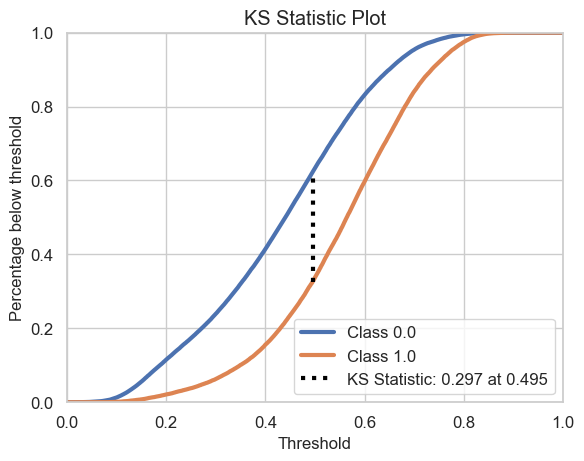

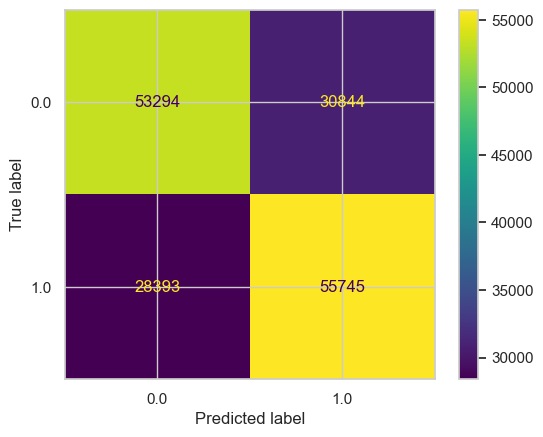


Accuracy:         0.6480
Recall:           0.6625
Precision:        0.6438
F1:               0.6530
AUROC:            0.7032
KS:               0.2971


In [70]:
testePlot(random_forest_opt, X_val, y_val.ravel())

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

Gerando análises para o modelo RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, max_features=None, min_samples_leaf=42,
                       min_samples_split=246, n_estimators=525, n_jobs=-1,
                       random_state=42, verbose=2)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    2.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    2.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed: 

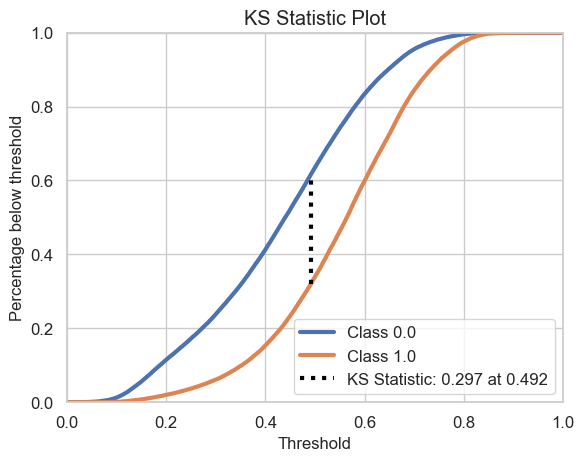

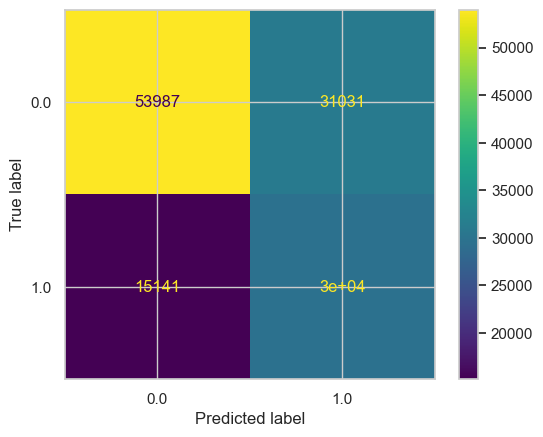


Accuracy:         0.6441
Recall:           0.6613
Precision:        0.4878
F1:               0.5615
AUROC:            0.7043
KS:               0.2966


In [71]:
testePlot(random_forest_opt, X_test, y_test.ravel())

### Gradient Boosting

Gradient Boosting é um algoritmo de aprendizado de máquina que cria um modelo forte combinando múltiplos modelos fracos, geralmente árvores de decisão. Funciona em etapas sequenciais, corrigindo os erros dos modelos anteriores, resultando em um modelo final mais preciso.

In [72]:
def objective_gb(trial):    
    params_gb = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 300),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 100),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    model = GradientBoostingClassifier(**params_gb, random_state=42, verbose=2)
    model.fit(X_train, y_train.ravel())

    y_pred = model.predict(X_val)
    y_pred_score_positive = model.predict_proba(X_val)[:,1]
    """
    if((not np.any(y_pred)) or np.all(y_pred)):
        ks = 0
    else:
    """
    ks = ks_results(reshape_plot(y_val, y_pred_score_positive)[0], reshape_plot(y_val, y_pred_score_positive)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo, e não apenas os melhores parâmetros. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [73]:
def callback_gb(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Iniciamos o nosso estudo:

In [74]:
# Measure the start time
start_time_gb = time.time()

study_gb = optuna.create_study(direction='maximize')

study_gb.optimize(objective_gb, n_trials=n_trials, callbacks=[callback_gb])

print('Number of finished trials:', len(study_gb.trials))
print('Best trial:', study_gb.best_trial.params)

# Measure the end time
end_time_gb = time.time()

# Calculate the duration in seconds
duration_gb = end_time_gb - start_time_gb

[I 2023-09-10 16:59:47,602] A new study created in memory with name: no-name-db7a6b0a-8a1b-472c-8575-080b4b7c703e


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3442           0.0271          479.19m
         2           1.3101           0.0231          512.14m
         3           1.2799           0.0198          491.17m
         4           1.2530           0.0167          481.52m
         5           1.2275           0.0149          476.73m
         6           1.2040           0.0125          474.23m
         7           1.1820           0.0123          472.01m
         8           1.1603           0.0100          470.35m
         9           1.1414           0.0099          469.79m
        10           1.1231           0.0084          469.43m
        11           1.1063           0.0078          470.25m
        12           1.0896           0.0075          469.64m
        13           1.0725           0.0072          469.52m
        14           1.0584           0.0062          469.13m
        15           1.0437           0.0056          469.23m
       

[I 2023-09-11 02:43:23,435] Trial 0 finished with value: 0.27464403717701874 and parameters: {'loss': 'log_loss', 'learning_rate': 0.09557474797080485, 'n_estimators': 373, 'max_depth': 24, 'min_samples_split': 288, 'min_samples_leaf': 7, 'max_features': None, 'subsample': 0.7665940603415113}. Best is trial 0 with value: 0.27464403717701874.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3820           0.0027            7.73m
         2           1.3779           0.0028            7.54m
         3           1.3729           0.0029            7.77m
         4           1.3682           0.0029            7.79m
         5           1.3637           0.0029            7.67m
         6           1.3595           0.0027            7.57m
         7           1.3556           0.0024            7.43m
         8           1.3514           0.0025            7.35m
         9           1.3478           0.0024            7.23m
        10           1.3436           0.0026            7.16m
        11           1.3396           0.0025            7.08m
        12           1.3358           0.0025            6.98m
        13           1.3317           0.0026            6.88m
        14           1.3277           0.0025            6.81m
        15           1.3238           0.0023            6.74m
       

[I 2023-09-11 02:51:24,928] Trial 1 finished with value: 0.27970714778102646 and parameters: {'loss': 'log_loss', 'learning_rate': 0.010806117798184484, 'n_estimators': 90, 'max_depth': 18, 'min_samples_split': 34, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'subsample': 0.8505347848116296}. Best is trial 1 with value: 0.27970714778102646.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3755           0.0080            1.53m
         2           1.3650           0.0083            1.48m
         3           1.3550           0.0075            1.47m
         4           1.3464           0.0060            1.46m
         5           1.3379           0.0060            1.40m
         6           1.3303           0.0053            1.34m
         7           1.3225           0.0050            1.29m
         8           1.3151           0.0048            1.24m
         9           1.3067           0.0060            1.20m
        10           1.2995           0.0047            1.16m
        11           1.2923           0.0044            1.11m
        12           1.2853           0.0044            1.07m
        13           1.2787           0.0043            1.03m
        14           1.2728           0.0030           59.34s
        15           1.2666           0.0035           57.14s
       

[I 2023-09-11 02:53:03,946] Trial 2 finished with value: 0.26584896241888334 and parameters: {'loss': 'log_loss', 'learning_rate': 0.04979543826289033, 'n_estimators': 39, 'max_depth': 26, 'min_samples_split': 213, 'min_samples_leaf': 7, 'max_features': 'log2', 'subsample': 0.959988197528046}. Best is trial 1 with value: 0.27970714778102646.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3659           0.0157            8.68m
         2           1.3475           0.0146            8.92m
         3           1.3304           0.0122            8.97m
         4           1.3133           0.0124            8.90m
         5           1.2970           0.0113            8.82m
         6           1.2839           0.0087            8.71m
         7           1.2707           0.0088            8.65m
         8           1.2587           0.0068            8.57m
         9           1.2486           0.0064            8.55m
        10           1.2386           0.0063            8.49m
        11           1.2282           0.0059            8.44m
        12           1.2192           0.0058            8.36m
        13           1.2103           0.0051            8.32m
        14           1.2015           0.0048            8.27m
        15           1.1946           0.0040            8.19m
       

[I 2023-09-11 03:02:01,333] Trial 3 finished with value: 0.2952886923863178 and parameters: {'loss': 'log_loss', 'learning_rate': 0.0849004369459237, 'n_estimators': 152, 'max_depth': 21, 'min_samples_split': 91, 'min_samples_leaf': 93, 'max_features': 'sqrt', 'subsample': 0.9507031003420483}. Best is trial 3 with value: 0.2952886923863178.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9925           0.0073           26.02m
         2           0.9861           0.0064           25.74m
         3           0.9805           0.0054           25.39m
         4           0.9760           0.0045           25.00m
         5           0.9717           0.0040           24.81m
         6           0.9680           0.0035           24.46m
         7           0.9652           0.0031           24.09m
         8           0.9609           0.0038           23.76m
         9           0.9587           0.0025           23.46m
        10           0.9561           0.0025           23.15m
        11           0.9540           0.0022           22.84m
        12           0.9518           0.0022           22.51m
        13           0.9498           0.0019           22.14m
        14           0.9482           0.0016           21.84m
        15           0.9463           0.0015           21.51m
       

[I 2023-09-11 03:28:09,034] Trial 4 finished with value: 0.30843376357888236 and parameters: {'loss': 'exponential', 'learning_rate': 0.09436703642665961, 'n_estimators': 75, 'max_depth': 5, 'min_samples_split': 251, 'min_samples_leaf': 76, 'max_features': None, 'subsample': 0.7884775024879453}. Best is trial 4 with value: 0.30843376357888236.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9996           0.0003            1.15m
         2           0.9991           0.0005            1.15m
         3           0.9985           0.0006            1.25m
         4           0.9983           0.0003            1.30m
         5           0.9978           0.0004            1.34m
         6           0.9976           0.0002            1.29m
         7           0.9974           0.0002            1.23m
         8           0.9971           0.0002            1.20m
         9           0.9968           0.0003            1.20m
        10           0.9965           0.0003            1.20m
        11           0.9963           0.0003            1.21m
        12           0.9961           0.0002            1.21m
        13           0.9957           0.0003            1.21m
        14           0.9952           0.0005            1.21m
        15           0.9950           0.0002            1.21m
       

[I 2023-09-11 03:29:38,702] Trial 5 finished with value: 0.25599610164253966 and parameters: {'loss': 'exponential', 'learning_rate': 0.016667813664537786, 'n_estimators': 230, 'max_depth': 6, 'min_samples_split': 74, 'min_samples_leaf': 41, 'max_features': 'log2', 'subsample': 0.8632801679742378}. Best is trial 4 with value: 0.30843376357888236.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9994           0.0006            4.21s
         2           0.9988           0.0006            3.76s
         3           0.9982           0.0006            3.76s
         4           0.9979           0.0003            3.54s
         5           0.9974           0.0004            3.24s
         6           0.9971           0.0003            2.83s
         7           0.9969           0.0002            2.37s
         8           0.9966           0.0003            1.99s
         9           0.9963           0.0003            1.68s
        10           0.9958           0.0005            1.35s
        11           0.9952           0.0006            1.02s
        12           0.9950           0.0003            0.68s
        13           0.9946           0.0004            0.34s
        14           0.9940           0.0006            0.00s


[I 2023-09-11 03:29:48,407] Trial 6 finished with value: 0.21045187667878956 and parameters: {'loss': 'exponential', 'learning_rate': 0.01940064822623985, 'n_estimators': 14, 'max_depth': 6, 'min_samples_split': 246, 'min_samples_leaf': 93, 'max_features': 'log2', 'subsample': 0.9303779359507813}. Best is trial 4 with value: 0.30843376357888236.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9592           0.0169          461.53m
         2           0.9302           0.0157          465.09m
         3           0.9025           0.0142          466.33m
         4           0.8765           0.0130          466.09m
         5           0.8512           0.0122          467.76m
         6           0.8273           0.0111          468.39m
         7           0.8057           0.0104          469.64m
         8           0.7835           0.0099          469.94m
         9           0.7631           0.0090          469.86m
        10           0.7443           0.0081          470.56m
        11           0.7246           0.0078          471.62m
        12           0.7068           0.0074          471.62m
        13           0.6890           0.0069          472.14m
        14           0.6726           0.0065          472.24m
        15           0.6562           0.0064          471.79m
       

[I 2023-09-11 13:57:50,523] Trial 7 finished with value: 0.27605838028001617 and parameters: {'loss': 'exponential', 'learning_rate': 0.08325727415247217, 'n_estimators': 421, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 13, 'max_features': None, 'subsample': 0.585242308062973}. Best is trial 4 with value: 0.30843376357888236.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3794           0.0043          257.09m
         2           1.3740           0.0041          255.22m
         3           1.3686           0.0041          251.25m
         4           1.3633           0.0040          236.31m
         5           1.3579           0.0039          232.20m
         6           1.3528           0.0038          224.89m
         7           1.3479           0.0037          218.52m
         8           1.3428           0.0036          215.14m
         9           1.3381           0.0035          210.97m
        10           1.3334           0.0034          208.06m
        11           1.3286           0.0033          205.36m
        12           1.3243           0.0033          203.62m
        13           1.3196           0.0032          202.13m
        14           1.3154           0.0031          200.56m
        15           1.3109           0.0031          203.15m
       

[I 2023-09-11 18:02:42,989] Trial 8 finished with value: 0.30791081318785807 and parameters: {'loss': 'log_loss', 'learning_rate': 0.01540118826583613, 'n_estimators': 244, 'max_depth': 30, 'min_samples_split': 171, 'min_samples_leaf': 61, 'max_features': None, 'subsample': 0.5390739126955877}. Best is trial 4 with value: 0.30843376357888236.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9999           0.0001            4.38m
         2           0.9998           0.0001            4.15m
         3           0.9997           0.0001            4.39m
         4           0.9997           0.0001            4.48m
         5           0.9996           0.0001            4.57m
         6           0.9995           0.0001            4.49m
         7           0.9994           0.0000            4.32m
         8           0.9994           0.0001            4.25m
         9           0.9993           0.0001            4.26m
        10           0.9992           0.0001            4.24m
        11           0.9991           0.0001            4.21m
        12           0.9990           0.0001            4.19m
        13           0.9990           0.0001            4.18m
        14           0.9988           0.0001            4.20m
        15           0.9988           0.0001            4.19m
       

[I 2023-09-11 18:07:29,240] Trial 9 finished with value: 0.25068340107917947 and parameters: {'loss': 'exponential', 'learning_rate': 0.0018847459042056422, 'n_estimators': 437, 'max_depth': 11, 'min_samples_split': 262, 'min_samples_leaf': 53, 'max_features': 'log2', 'subsample': 0.6704296672522864}. Best is trial 4 with value: 0.30843376357888236.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9896           0.0081          126.72m
         2           0.9807           0.0074          125.86m
         3           0.9726           0.0066          125.28m
         4           0.9650           0.0060          124.42m
         5           0.9579           0.0054          123.81m
         6           0.9517           0.0048          122.95m
         7           0.9460           0.0045          122.17m
         8           0.9400           0.0040          121.31m
         9           0.9349           0.0038          120.69m
        10           0.9299           0.0035          119.98m
        11           0.9253           0.0034          119.27m
        12           0.9210           0.0030          118.59m
        13           0.9165           0.0028          118.06m
        14           0.9127           0.0026          117.54m
        15           0.9091           0.0024          116.71m
       

[I 2023-09-11 20:12:13,411] Trial 10 finished with value: 0.31240343245620295 and parameters: {'loss': 'exponential', 'learning_rate': 0.06568694177774066, 'n_estimators': 159, 'max_depth': 12, 'min_samples_split': 158, 'min_samples_leaf': 71, 'max_features': None, 'subsample': 0.7312852865743152}. Best is trial 10 with value: 0.31240343245620295.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9896           0.0081          112.05m
         2           0.9808           0.0074          111.52m
         3           0.9724           0.0067          110.69m
         4           0.9649           0.0061          109.79m
         5           0.9579           0.0055          109.18m
         6           0.9517           0.0048          108.42m
         7           0.9461           0.0046          108.37m
         8           0.9399           0.0041          107.62m
         9           0.9348           0.0037          106.95m
        10           0.9298           0.0036          106.16m
        11           0.9254           0.0031          105.35m
        12           0.9215           0.0028          104.52m
        13           0.9172           0.0029          103.86m
        14           0.9130           0.0026          103.27m
        15           0.9095           0.0023          102.40m
       

[I 2023-09-11 22:04:48,850] Trial 11 finished with value: 0.3100976966412323 and parameters: {'loss': 'exponential', 'learning_rate': 0.06581917556046013, 'n_estimators': 143, 'max_depth': 12, 'min_samples_split': 151, 'min_samples_leaf': 74, 'max_features': None, 'subsample': 0.7162590706116997}. Best is trial 10 with value: 0.31240343245620295.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9891           0.0083          136.10m
         2           0.9796           0.0076          135.74m
         3           0.9710           0.0068          134.92m
         4           0.9629           0.0062          134.00m
         5           0.9553           0.0057          133.29m
         6           0.9483           0.0050          132.51m
         7           0.9422           0.0048          131.85m
         8           0.9356           0.0043          131.08m
         9           0.9302           0.0040          130.45m
        10           0.9244           0.0037          129.66m
        11           0.9190           0.0034          129.04m
        12           0.9147           0.0031          128.40m
        13           0.9098           0.0030          127.77m
        14           0.9056           0.0027          126.93m
        15           0.9013           0.0026          126.24m
       

[I 2023-09-12 00:20:51,677] Trial 12 finished with value: 0.31063253226841614 and parameters: {'loss': 'exponential', 'learning_rate': 0.06504922204154273, 'n_estimators': 168, 'max_depth': 13, 'min_samples_split': 140, 'min_samples_leaf': 72, 'max_features': None, 'subsample': 0.6897307519358278}. Best is trial 10 with value: 0.31240343245620295.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9902           0.0072          268.11m
         2           0.9818           0.0067          267.07m
         3           0.9739           0.0062          266.30m
         4           0.9666           0.0057          265.00m
         5           0.9594           0.0052          264.68m
         6           0.9529           0.0048          263.93m
         7           0.9473           0.0045          263.36m
         8           0.9408           0.0042          262.65m
         9           0.9357           0.0038          261.98m
        10           0.9305           0.0037          261.23m
        11           0.9257           0.0033          260.64m
        12           0.9213           0.0030          260.17m
        13           0.9165           0.0030          259.56m
        14           0.9126           0.0027          258.64m
        15           0.9084           0.0025          257.89m
       

[I 2023-09-12 04:41:09,012] Trial 13 finished with value: 0.3083624521619244 and parameters: {'loss': 'exponential', 'learning_rate': 0.056085539047615734, 'n_estimators': 341, 'max_depth': 13, 'min_samples_split': 137, 'min_samples_leaf': 34, 'max_features': None, 'subsample': 0.6526981441534672}. Best is trial 10 with value: 0.31240343245620295.


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9873           0.0089          139.13m
         2           0.9769           0.0080          138.24m
         3           0.9670           0.0073          137.04m
         4           0.9580           0.0068          136.21m
         5           0.9492           0.0061          135.31m
         6           0.9411           0.0055          134.64m
         7           0.9340           0.0052          134.30m
         8           0.9263           0.0048          133.60m
         9           0.9199           0.0044          132.87m
        10           0.9135           0.0040          132.14m
        11           0.9076           0.0036          131.74m
        12           0.9021           0.0032          131.09m
        13           0.8965           0.0031          130.45m
        14           0.8917           0.0028          129.59m
        15           0.8867           0.0028          128.90m
       

[I 2023-09-12 07:10:38,400] Trial 14 finished with value: 0.3042739309230075 and parameters: {'loss': 'exponential', 'learning_rate': 0.06806348770887904, 'n_estimators': 166, 'max_depth': 16, 'min_samples_split': 185, 'min_samples_leaf': 77, 'max_features': None, 'subsample': 0.6388174976862725}. Best is trial 10 with value: 0.31240343245620295.


Number of finished trials: 15
Best trial: {'loss': 'exponential', 'learning_rate': 0.06568694177774066, 'n_estimators': 159, 'max_depth': 12, 'min_samples_split': 158, 'min_samples_leaf': 71, 'max_features': None, 'subsample': 0.7312852865743152}


Temos aqui os melhores atributos do nosso estudo:

In [75]:
study_gb.best_trial.user_attrs

{'roc_auc': 0.713492416887372,
 'ks': 0.31240343245620295,
 'accuracy': 0.6545021274572725,
 'precision': 0.6587182398691135,
 'recall': 0.641220376048872,
 'f1': 0.649851542691263,
 'best_model': GradientBoostingClassifier(learning_rate=0.06568694177774066,
                            loss='exponential', max_depth=12,
                            min_samples_leaf=71, min_samples_split=158,
                            n_estimators=159, random_state=42,
                            subsample=0.7312852865743152, verbose=2)}

Temos o melhor valor para o KS:

In [76]:
ks_gb = max([trial.user_attrs['ks'] for trial in study_gb.trials])
print(ks_gb)

0.31240343245620295


Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [77]:
results_gb_opt = pd.DataFrame({'model': 'Gradient Boosting Optuna','ks': study_gb.best_trial.user_attrs['ks'], 'roc_auc': study_gb.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_gb.best_trial.user_attrs['accuracy'], 'precision': study_gb.best_trial.user_attrs['precision'], \
                            'recall': study_gb.best_trial.user_attrs['recall'], 'f1': study_gb.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_gb))}, index=[0])

results = pd.concat([results, results_gb_opt])
results

,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17
0,Gradient Boosting Optuna,0.312403,0.713492,0.654502,0.658718,0.64122,0.649852,14:10:52


Temos o nosso melhor modelo:

In [78]:
gradient_boosting_opt = study_gb.user_attrs["best_model"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo GradientBoostingClassifier(learning_rate=0.06568694177774066,
                           loss='exponential', max_depth=12,
                           min_samples_leaf=71, min_samples_split=158,
                           n_estimators=159, random_state=42,
                           subsample=0.7312852865743152, verbose=2)


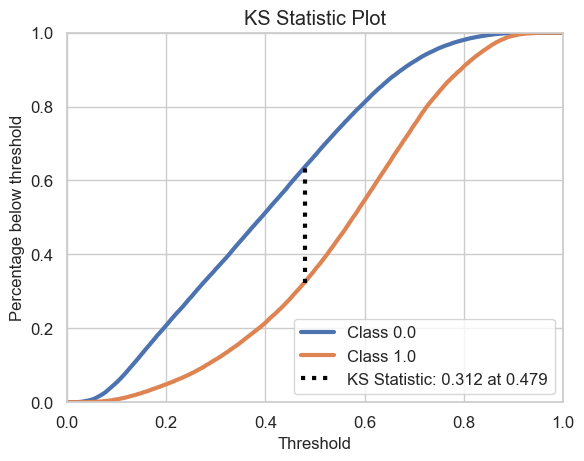

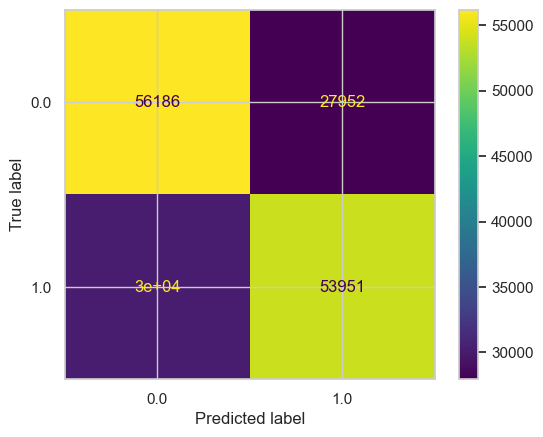


Accuracy:         0.6545
Recall:           0.6412
Precision:        0.6587
F1:               0.6499
AUROC:            0.7135
KS:               0.3124


In [79]:
testePlot(gradient_boosting_opt, X_val, y_val.ravel())

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

Gerando análises para o modelo GradientBoostingClassifier(learning_rate=0.06568694177774066,
                           loss='exponential', max_depth=12,
                           min_samples_leaf=71, min_samples_split=158,
                           n_estimators=159, random_state=42,
                           subsample=0.7312852865743152, verbose=2)


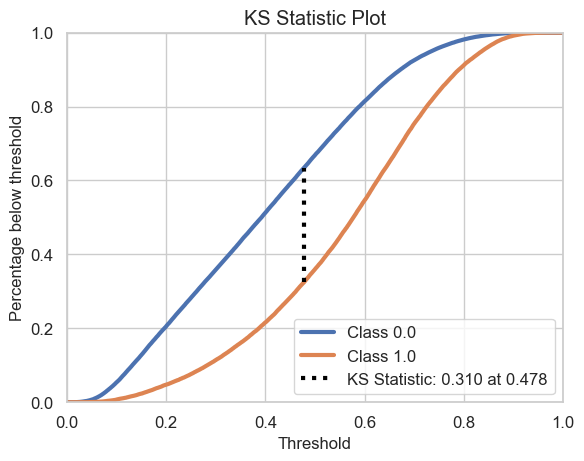

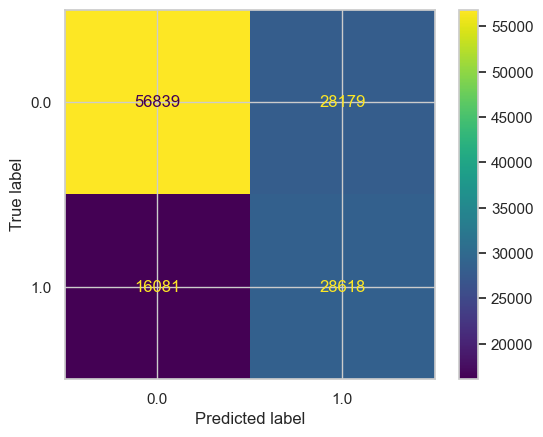


Accuracy:         0.6588
Recall:           0.6402
Precision:        0.5039
F1:               0.5639
AUROC:            0.7144
KS:               0.3100


In [80]:
testePlot(gradient_boosting_opt, X_test, y_test.ravel())

### XGBoost

XGBoost (Extreme Gradient Boosting) é uma implementação otimizada do algoritmo de Gradient Boosting, que combina modelos fracos para criar um modelo forte de aprendizado de máquina. Possui uma implementação otimizada que acelera o treinamento, tornando-o mais rápido que algumas outras implementações de Gradient Boosting.

In [81]:
def objective_xgb(trial):
    # Define the hyperparameters to optimize
    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'verbosity': 0,
        'n_jobs': -1,
        #'tree_method': 'auto',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200)
    }

    #model = xgb.XGBClassifier(tree_method='gpu_hist', **params_xgb, random_state=42, early_stopping_rounds=100)
    model = xgb.XGBClassifier(tree_method='gpu_hist', **params_xgb, random_state=42)
    model.fit(X_train, y_train.ravel(), eval_set=[(X_val, y_val)]) 
   
    y_pred = model.predict(X_val)
    y_pred_score_positive = model.predict_proba(X_val)[:,1]
    """
    if((not np.any(y_pred)) or np.all(y_pred)):
        ks = 0
    else:
    """
    ks = ks_results(reshape_plot(y_val, y_pred_score_positive)[0], reshape_plot(y_val, y_pred_score_positive)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo, e não apenas os melhores parâmetros. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [82]:
def callback_xgb(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Iniciamos o nosso estudo:

In [83]:
# Measure the start time
start_time_xgb = time.time()

study_xgb = optuna.create_study(direction='maximize')

study_xgb.optimize(objective_xgb, n_trials=n_trials, callbacks=[callback_xgb])

print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

# Measure the end time
end_time_xgb = time.time()

# Calculate the duration in seconds
duration_xgb = end_time_xgb - start_time_xgb

[I 2023-09-12 07:11:10,504] A new study created in memory with name: no-name-03a42c1d-1e81-4556-845f-2aa17f9e7cb5


[0]	validation_0-logloss:0.68155
[1]	validation_0-logloss:0.67293
[2]	validation_0-logloss:0.66548
[3]	validation_0-logloss:0.65952
[4]	validation_0-logloss:0.65443
[5]	validation_0-logloss:0.65013
[6]	validation_0-logloss:0.64651
[7]	validation_0-logloss:0.64344
[8]	validation_0-logloss:0.64083
[9]	validation_0-logloss:0.63860
[10]	validation_0-logloss:0.63668
[11]	validation_0-logloss:0.63473
[12]	validation_0-logloss:0.63341
[13]	validation_0-logloss:0.63195


[I 2023-09-12 07:11:38,916] Trial 0 finished with value: 0.2963702488768452 and parameters: {'eta': 0.11696633860392461, 'max_depth': 8, 'subsample': 0.840047658694274, 'colsample_bytree': 0.7754782728581504, 'min_child_weight': 5, 'gamma': 0.06039825772549112, 'n_estimators': 14}. Best is trial 0 with value: 0.2963702488768452.


[0]	validation_0-logloss:0.67702
[1]	validation_0-logloss:0.66655
[2]	validation_0-logloss:0.65841
[3]	validation_0-logloss:0.65226
[4]	validation_0-logloss:0.64813
[5]	validation_0-logloss:0.64340
[6]	validation_0-logloss:0.64057
[7]	validation_0-logloss:0.63763
[8]	validation_0-logloss:0.63606
[9]	validation_0-logloss:0.63437
[10]	validation_0-logloss:0.63267
[11]	validation_0-logloss:0.63141
[12]	validation_0-logloss:0.63060
[13]	validation_0-logloss:0.62965
[14]	validation_0-logloss:0.62890
[15]	validation_0-logloss:0.62834
[16]	validation_0-logloss:0.62773
[17]	validation_0-logloss:0.62724
[18]	validation_0-logloss:0.62682
[19]	validation_0-logloss:0.62640
[20]	validation_0-logloss:0.62583
[21]	validation_0-logloss:0.62551
[22]	validation_0-logloss:0.62530
[23]	validation_0-logloss:0.62495
[24]	validation_0-logloss:0.62479
[25]	validation_0-logloss:0.62448
[26]	validation_0-logloss:0.62435
[27]	validation_0-logloss:0.62400
[28]	validation_0-logloss:0.62392
[29]	validation_0-loglos

[I 2023-09-12 07:12:13,986] Trial 1 finished with value: 0.30873089448287333 and parameters: {'eta': 0.22318649155782577, 'max_depth': 5, 'subsample': 0.8647015412992963, 'colsample_bytree': 0.9211784295359454, 'min_child_weight': 9, 'gamma': 0.9908144150508341, 'n_estimators': 135}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.68934
[1]	validation_0-logloss:0.68590
[2]	validation_0-logloss:0.68269
[3]	validation_0-logloss:0.67977
[4]	validation_0-logloss:0.67710
[5]	validation_0-logloss:0.67468
[6]	validation_0-logloss:0.67235
[7]	validation_0-logloss:0.67016
[8]	validation_0-logloss:0.66804
[9]	validation_0-logloss:0.66624
[10]	validation_0-logloss:0.66442
[11]	validation_0-logloss:0.66263
[12]	validation_0-logloss:0.66109
[13]	validation_0-logloss:0.65969
[14]	validation_0-logloss:0.65829
[15]	validation_0-logloss:0.65678
[16]	validation_0-logloss:0.65541


[I 2023-09-12 07:12:42,699] Trial 2 finished with value: 0.264696094511398 and parameters: {'eta': 0.0476558711912027, 'max_depth': 5, 'subsample': 0.6886291696163395, 'colsample_bytree': 0.9122287542567864, 'min_child_weight': 10, 'gamma': 0.5825091376121321, 'n_estimators': 17}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.68250
[1]	validation_0-logloss:0.67468
[2]	validation_0-logloss:0.66873
[3]	validation_0-logloss:0.66368
[4]	validation_0-logloss:0.65988
[5]	validation_0-logloss:0.65575
[6]	validation_0-logloss:0.65245
[7]	validation_0-logloss:0.65014
[8]	validation_0-logloss:0.64699
[9]	validation_0-logloss:0.64463
[10]	validation_0-logloss:0.64312
[11]	validation_0-logloss:0.64169
[12]	validation_0-logloss:0.63983
[13]	validation_0-logloss:0.63859
[14]	validation_0-logloss:0.63743
[15]	validation_0-logloss:0.63645
[16]	validation_0-logloss:0.63555
[17]	validation_0-logloss:0.63491
[18]	validation_0-logloss:0.63429
[19]	validation_0-logloss:0.63341
[20]	validation_0-logloss:0.63273
[21]	validation_0-logloss:0.63219
[22]	validation_0-logloss:0.63179
[23]	validation_0-logloss:0.63122
[24]	validation_0-logloss:0.63092
[25]	validation_0-logloss:0.63052
[26]	validation_0-logloss:0.63009
[27]	validation_0-logloss:0.62972


[I 2023-09-12 07:13:12,216] Trial 3 finished with value: 0.29639401934916443 and parameters: {'eta': 0.15712546869324417, 'max_depth': 4, 'subsample': 0.9622335544611837, 'colsample_bytree': 0.8353208045177336, 'min_child_weight': 2, 'gamma': 0.023016888768859434, 'n_estimators': 28}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.69168
[1]	validation_0-logloss:0.69049
[2]	validation_0-logloss:0.68914
[3]	validation_0-logloss:0.68786
[4]	validation_0-logloss:0.68661
[5]	validation_0-logloss:0.68541
[6]	validation_0-logloss:0.68426
[7]	validation_0-logloss:0.68309
[8]	validation_0-logloss:0.68204
[9]	validation_0-logloss:0.68091
[10]	validation_0-logloss:0.67998
[11]	validation_0-logloss:0.67898
[12]	validation_0-logloss:0.67803
[13]	validation_0-logloss:0.67702
[14]	validation_0-logloss:0.67616
[15]	validation_0-logloss:0.67522
[16]	validation_0-logloss:0.67436
[17]	validation_0-logloss:0.67352
[18]	validation_0-logloss:0.67263
[19]	validation_0-logloss:0.67175
[20]	validation_0-logloss:0.67093
[21]	validation_0-logloss:0.67007
[22]	validation_0-logloss:0.66923
[23]	validation_0-logloss:0.66841
[24]	validation_0-logloss:0.66773
[25]	validation_0-logloss:0.66697
[26]	validation_0-logloss:0.66625
[27]	validation_0-logloss:0.66558
[28]	validation_0-logloss:0.66488
[29]	validation_0-loglos

[I 2023-09-12 07:13:55,634] Trial 4 finished with value: 0.2998407378354608 and parameters: {'eta': 0.017984385274927333, 'max_depth': 5, 'subsample': 0.7604973820510987, 'colsample_bytree': 0.5389597200223613, 'min_child_weight': 6, 'gamma': 0.08130404284591408, 'n_estimators': 183}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.69140
[1]	validation_0-logloss:0.68979
[2]	validation_0-logloss:0.68821
[3]	validation_0-logloss:0.68674
[4]	validation_0-logloss:0.68529
[5]	validation_0-logloss:0.68393
[6]	validation_0-logloss:0.68263
[7]	validation_0-logloss:0.68139
[8]	validation_0-logloss:0.68023
[9]	validation_0-logloss:0.67910
[10]	validation_0-logloss:0.67806
[11]	validation_0-logloss:0.67700
[12]	validation_0-logloss:0.67600
[13]	validation_0-logloss:0.67504
[14]	validation_0-logloss:0.67412
[15]	validation_0-logloss:0.67324
[16]	validation_0-logloss:0.67228
[17]	validation_0-logloss:0.67144
[18]	validation_0-logloss:0.67060
[19]	validation_0-logloss:0.66981
[20]	validation_0-logloss:0.66908
[21]	validation_0-logloss:0.66836
[22]	validation_0-logloss:0.66765
[23]	validation_0-logloss:0.66698
[24]	validation_0-logloss:0.66628
[25]	validation_0-logloss:0.66569
[26]	validation_0-logloss:0.66509
[27]	validation_0-logloss:0.66443
[28]	validation_0-logloss:0.66387
[29]	validation_0-loglos

[I 2023-09-12 07:14:35,096] Trial 5 finished with value: 0.2933276284199767 and parameters: {'eta': 0.027833999749685888, 'max_depth': 3, 'subsample': 0.6037966620895675, 'colsample_bytree': 0.671572145014296, 'min_child_weight': 1, 'gamma': 0.7245714780026327, 'n_estimators': 192}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.67161
[1]	validation_0-logloss:0.65853
[2]	validation_0-logloss:0.64957
[3]	validation_0-logloss:0.64326
[4]	validation_0-logloss:0.63909
[5]	validation_0-logloss:0.63558
[6]	validation_0-logloss:0.63285
[7]	validation_0-logloss:0.63052
[8]	validation_0-logloss:0.62917
[9]	validation_0-logloss:0.62813
[10]	validation_0-logloss:0.62727
[11]	validation_0-logloss:0.62644
[12]	validation_0-logloss:0.62597
[13]	validation_0-logloss:0.62543
[14]	validation_0-logloss:0.62504
[15]	validation_0-logloss:0.62460
[16]	validation_0-logloss:0.62452
[17]	validation_0-logloss:0.62422
[18]	validation_0-logloss:0.62396
[19]	validation_0-logloss:0.62367
[20]	validation_0-logloss:0.62352
[21]	validation_0-logloss:0.62343
[22]	validation_0-logloss:0.62325
[23]	validation_0-logloss:0.62309
[24]	validation_0-logloss:0.62299
[25]	validation_0-logloss:0.62292
[26]	validation_0-logloss:0.62290
[27]	validation_0-logloss:0.62283
[28]	validation_0-logloss:0.62266
[29]	validation_0-loglos

[I 2023-09-12 07:15:12,705] Trial 6 finished with value: 0.29973377071002394 and parameters: {'eta': 0.2531936860924855, 'max_depth': 7, 'subsample': 0.8274703978871346, 'colsample_bytree': 0.5923171327806038, 'min_child_weight': 3, 'gamma': 0.9906276137662244, 'n_estimators': 125}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.67045
[1]	validation_0-logloss:0.65920
[2]	validation_0-logloss:0.64856
[3]	validation_0-logloss:0.64200
[4]	validation_0-logloss:0.63805
[5]	validation_0-logloss:0.63432
[6]	validation_0-logloss:0.63231
[7]	validation_0-logloss:0.63058
[8]	validation_0-logloss:0.62959
[9]	validation_0-logloss:0.62876
[10]	validation_0-logloss:0.62837
[11]	validation_0-logloss:0.62779
[12]	validation_0-logloss:0.62783
[13]	validation_0-logloss:0.62765
[14]	validation_0-logloss:0.62758
[15]	validation_0-logloss:0.62752
[16]	validation_0-logloss:0.62750
[17]	validation_0-logloss:0.62747
[18]	validation_0-logloss:0.62734
[19]	validation_0-logloss:0.62741
[20]	validation_0-logloss:0.62739
[21]	validation_0-logloss:0.62762
[22]	validation_0-logloss:0.62753
[23]	validation_0-logloss:0.62745
[24]	validation_0-logloss:0.62749
[25]	validation_0-logloss:0.62758
[26]	validation_0-logloss:0.62780
[27]	validation_0-logloss:0.62790
[28]	validation_0-logloss:0.62837
[29]	validation_0-loglos

[I 2023-09-12 07:15:45,161] Trial 7 finished with value: 0.292388694763365 and parameters: {'eta': 0.23463078110974697, 'max_depth': 10, 'subsample': 0.6833261693597177, 'colsample_bytree': 0.552378790405003, 'min_child_weight': 7, 'gamma': 0.35057259667224006, 'n_estimators': 30}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.66820
[1]	validation_0-logloss:0.65450
[2]	validation_0-logloss:0.64483
[3]	validation_0-logloss:0.63928
[4]	validation_0-logloss:0.63568
[5]	validation_0-logloss:0.63319
[6]	validation_0-logloss:0.63143
[7]	validation_0-logloss:0.62999
[8]	validation_0-logloss:0.62936
[9]	validation_0-logloss:0.62896
[10]	validation_0-logloss:0.62858
[11]	validation_0-logloss:0.62819
[12]	validation_0-logloss:0.62806
[13]	validation_0-logloss:0.62800
[14]	validation_0-logloss:0.62789
[15]	validation_0-logloss:0.62803
[16]	validation_0-logloss:0.62804
[17]	validation_0-logloss:0.62810
[18]	validation_0-logloss:0.62808
[19]	validation_0-logloss:0.62794
[20]	validation_0-logloss:0.62799
[21]	validation_0-logloss:0.62835
[22]	validation_0-logloss:0.62840
[23]	validation_0-logloss:0.62860
[24]	validation_0-logloss:0.62883
[25]	validation_0-logloss:0.62904


[I 2023-09-12 07:16:16,129] Trial 8 finished with value: 0.29430221778506743 and parameters: {'eta': 0.27359963195777015, 'max_depth': 9, 'subsample': 0.5851724582285056, 'colsample_bytree': 0.6591248283373077, 'min_child_weight': 2, 'gamma': 0.29907045665526677, 'n_estimators': 26}. Best is trial 1 with value: 0.30873089448287333.


[0]	validation_0-logloss:0.67790
[1]	validation_0-logloss:0.66736
[2]	validation_0-logloss:0.65993
[3]	validation_0-logloss:0.65291
[4]	validation_0-logloss:0.64821
[5]	validation_0-logloss:0.64509
[6]	validation_0-logloss:0.64248
[7]	validation_0-logloss:0.63940
[8]	validation_0-logloss:0.63727
[9]	validation_0-logloss:0.63562
[10]	validation_0-logloss:0.63424
[11]	validation_0-logloss:0.63294
[12]	validation_0-logloss:0.63191
[13]	validation_0-logloss:0.63090
[14]	validation_0-logloss:0.63005
[15]	validation_0-logloss:0.62936
[16]	validation_0-logloss:0.62857
[17]	validation_0-logloss:0.62817
[18]	validation_0-logloss:0.62749
[19]	validation_0-logloss:0.62698
[20]	validation_0-logloss:0.62654
[21]	validation_0-logloss:0.62617
[22]	validation_0-logloss:0.62575
[23]	validation_0-logloss:0.62555
[24]	validation_0-logloss:0.62524
[25]	validation_0-logloss:0.62501
[26]	validation_0-logloss:0.62482
[27]	validation_0-logloss:0.62464
[28]	validation_0-logloss:0.62439
[29]	validation_0-loglos

[I 2023-09-12 07:16:52,457] Trial 9 finished with value: 0.309408352943973 and parameters: {'eta': 0.20890510912749663, 'max_depth': 5, 'subsample': 0.6377239510027919, 'colsample_bytree': 0.7495435759197444, 'min_child_weight': 7, 'gamma': 0.5349207635669678, 'n_estimators': 134}. Best is trial 9 with value: 0.309408352943973.


[0]	validation_0-logloss:0.67615
[1]	validation_0-logloss:0.66499
[2]	validation_0-logloss:0.65692
[3]	validation_0-logloss:0.65062
[4]	validation_0-logloss:0.64561
[5]	validation_0-logloss:0.64156
[6]	validation_0-logloss:0.63836
[7]	validation_0-logloss:0.63601
[8]	validation_0-logloss:0.63378
[9]	validation_0-logloss:0.63223
[10]	validation_0-logloss:0.63065
[11]	validation_0-logloss:0.62953
[12]	validation_0-logloss:0.62854
[13]	validation_0-logloss:0.62770
[14]	validation_0-logloss:0.62710
[15]	validation_0-logloss:0.62646
[16]	validation_0-logloss:0.62603
[17]	validation_0-logloss:0.62566
[18]	validation_0-logloss:0.62524
[19]	validation_0-logloss:0.62512
[20]	validation_0-logloss:0.62465
[21]	validation_0-logloss:0.62450
[22]	validation_0-logloss:0.62435
[23]	validation_0-logloss:0.62414
[24]	validation_0-logloss:0.62400
[25]	validation_0-logloss:0.62380
[26]	validation_0-logloss:0.62350
[27]	validation_0-logloss:0.62338
[28]	validation_0-logloss:0.62325
[29]	validation_0-loglos

[I 2023-09-12 07:17:27,238] Trial 10 finished with value: 0.30214647365043146 and parameters: {'eta': 0.18598703247874032, 'max_depth': 7, 'subsample': 0.508802900730709, 'colsample_bytree': 0.9800032266168103, 'min_child_weight': 8, 'gamma': 0.6639936047986148, 'n_estimators': 82}. Best is trial 9 with value: 0.309408352943973.


[0]	validation_0-logloss:0.67273
[1]	validation_0-logloss:0.66156
[2]	validation_0-logloss:0.65238
[3]	validation_0-logloss:0.64573
[4]	validation_0-logloss:0.64143
[5]	validation_0-logloss:0.63845
[6]	validation_0-logloss:0.63548
[7]	validation_0-logloss:0.63380
[8]	validation_0-logloss:0.63204
[9]	validation_0-logloss:0.63098
[10]	validation_0-logloss:0.63010
[11]	validation_0-logloss:0.62897
[12]	validation_0-logloss:0.62834
[13]	validation_0-logloss:0.62774
[14]	validation_0-logloss:0.62709
[15]	validation_0-logloss:0.62622
[16]	validation_0-logloss:0.62595
[17]	validation_0-logloss:0.62568
[18]	validation_0-logloss:0.62500
[19]	validation_0-logloss:0.62460
[20]	validation_0-logloss:0.62440
[21]	validation_0-logloss:0.62421
[22]	validation_0-logloss:0.62392
[23]	validation_0-logloss:0.62369
[24]	validation_0-logloss:0.62348
[25]	validation_0-logloss:0.62313
[26]	validation_0-logloss:0.62297
[27]	validation_0-logloss:0.62289
[28]	validation_0-logloss:0.62265
[29]	validation_0-loglos

[I 2023-09-12 07:18:02,919] Trial 11 finished with value: 0.30672228957189385 and parameters: {'eta': 0.2942461996805593, 'max_depth': 5, 'subsample': 0.9617639892474386, 'colsample_bytree': 0.8057234838609382, 'min_child_weight': 10, 'gamma': 0.9941245037920509, 'n_estimators': 131}. Best is trial 9 with value: 0.309408352943973.


[0]	validation_0-logloss:0.67610
[1]	validation_0-logloss:0.66463
[2]	validation_0-logloss:0.65568
[3]	validation_0-logloss:0.65007
[4]	validation_0-logloss:0.64581
[5]	validation_0-logloss:0.64100
[6]	validation_0-logloss:0.63735
[7]	validation_0-logloss:0.63497
[8]	validation_0-logloss:0.63337
[9]	validation_0-logloss:0.63173
[10]	validation_0-logloss:0.63039
[11]	validation_0-logloss:0.62944
[12]	validation_0-logloss:0.62861
[13]	validation_0-logloss:0.62763
[14]	validation_0-logloss:0.62676
[15]	validation_0-logloss:0.62643
[16]	validation_0-logloss:0.62575
[17]	validation_0-logloss:0.62518
[18]	validation_0-logloss:0.62461
[19]	validation_0-logloss:0.62433
[20]	validation_0-logloss:0.62402
[21]	validation_0-logloss:0.62380
[22]	validation_0-logloss:0.62363
[23]	validation_0-logloss:0.62321
[24]	validation_0-logloss:0.62300
[25]	validation_0-logloss:0.62284
[26]	validation_0-logloss:0.62276
[27]	validation_0-logloss:0.62261
[28]	validation_0-logloss:0.62248
[29]	validation_0-loglos

[I 2023-09-12 07:18:41,816] Trial 12 finished with value: 0.3061755687085503 and parameters: {'eta': 0.21473176145087075, 'max_depth': 6, 'subsample': 0.8714052786704015, 'colsample_bytree': 0.8774733731494693, 'min_child_weight': 8, 'gamma': 0.8140904647736422, 'n_estimators': 158}. Best is trial 9 with value: 0.309408352943973.


[0]	validation_0-logloss:0.68113
[1]	validation_0-logloss:0.67286
[2]	validation_0-logloss:0.66691
[3]	validation_0-logloss:0.66170
[4]	validation_0-logloss:0.65821
[5]	validation_0-logloss:0.65548
[6]	validation_0-logloss:0.65138
[7]	validation_0-logloss:0.64909
[8]	validation_0-logloss:0.64716
[9]	validation_0-logloss:0.64551
[10]	validation_0-logloss:0.64270
[11]	validation_0-logloss:0.64165
[12]	validation_0-logloss:0.64037
[13]	validation_0-logloss:0.63955
[14]	validation_0-logloss:0.63781
[15]	validation_0-logloss:0.63707
[16]	validation_0-logloss:0.63646
[17]	validation_0-logloss:0.63533
[18]	validation_0-logloss:0.63478
[19]	validation_0-logloss:0.63427
[20]	validation_0-logloss:0.63358
[21]	validation_0-logloss:0.63327
[22]	validation_0-logloss:0.63274
[23]	validation_0-logloss:0.63245
[24]	validation_0-logloss:0.63190
[25]	validation_0-logloss:0.63157
[26]	validation_0-logloss:0.63124
[27]	validation_0-logloss:0.63094
[28]	validation_0-logloss:0.63057
[29]	validation_0-loglos

[I 2023-09-12 07:19:14,290] Trial 13 finished with value: 0.3053792578858542 and parameters: {'eta': 0.2116800651367381, 'max_depth': 3, 'subsample': 0.7554952250892154, 'colsample_bytree': 0.7314342629814078, 'min_child_weight': 9, 'gamma': 0.4910751750740139, 'n_estimators': 91}. Best is trial 9 with value: 0.309408352943973.


[0]	validation_0-logloss:0.67343
[1]	validation_0-logloss:0.66115
[2]	validation_0-logloss:0.65272
[3]	validation_0-logloss:0.64470
[4]	validation_0-logloss:0.63996
[5]	validation_0-logloss:0.63647
[6]	validation_0-logloss:0.63384
[7]	validation_0-logloss:0.63196
[8]	validation_0-logloss:0.63040
[9]	validation_0-logloss:0.62929
[10]	validation_0-logloss:0.62836
[11]	validation_0-logloss:0.62748
[12]	validation_0-logloss:0.62668
[13]	validation_0-logloss:0.62577
[14]	validation_0-logloss:0.62523
[15]	validation_0-logloss:0.62490
[16]	validation_0-logloss:0.62434
[17]	validation_0-logloss:0.62412
[18]	validation_0-logloss:0.62346
[19]	validation_0-logloss:0.62333
[20]	validation_0-logloss:0.62317
[21]	validation_0-logloss:0.62299
[22]	validation_0-logloss:0.62277
[23]	validation_0-logloss:0.62264
[24]	validation_0-logloss:0.62239
[25]	validation_0-logloss:0.62234
[26]	validation_0-logloss:0.62204
[27]	validation_0-logloss:0.62193
[28]	validation_0-logloss:0.62185
[29]	validation_0-loglos

[I 2023-09-12 07:19:52,914] Trial 14 finished with value: 0.30465425848011607 and parameters: {'eta': 0.2545469989589662, 'max_depth': 6, 'subsample': 0.8968458019337864, 'colsample_bytree': 0.9221325805947935, 'min_child_weight': 6, 'gamma': 0.8093956389347522, 'n_estimators': 153}. Best is trial 9 with value: 0.309408352943973.


Number of finished trials: 15
Best trial: {'eta': 0.20890510912749663, 'max_depth': 5, 'subsample': 0.6377239510027919, 'colsample_bytree': 0.7495435759197444, 'min_child_weight': 7, 'gamma': 0.5349207635669678, 'n_estimators': 134}


Temos aqui os melhores atributos do nosso estudo:

In [84]:
study_xgb.best_trial.user_attrs

{'roc_auc': 0.7115845055849199,
 'ks': 0.309408352943973,
 'accuracy': 0.6542525374979201,
 'precision': 0.646096696122024,
 'recall': 0.6821650146188405,
 'f1': 0.663641146306071,
 'best_model': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7495435759197444, early_stopping_rounds=None,
               enable_categorical=False, eta=0.20890510912749663,
               eval_metric='logloss', feature_types=None,
               gamma=0.5349207635669678, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=7, missing=nan,
               monotone_constraints=None, n_estimators=134, n_jobs=-1,
               num_parallel_tree=None, predictor=Non

Temos o melhor valor para o KS:

In [85]:
ks_xgb = max([trial.user_attrs['ks'] for trial in study_xgb.trials])
print(ks_xgb)

0.309408352943973


Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [86]:
results_xgb_opt = pd.DataFrame({'model': 'GXB Optuna','ks': study_xgb.best_trial.user_attrs['ks'], 'roc_auc': study_xgb.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_xgb.best_trial.user_attrs['accuracy'], 'precision': study_xgb.best_trial.user_attrs['precision'], \
                            'recall': study_xgb.best_trial.user_attrs['recall'], 'f1': study_xgb.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_xgb))}, index=[0])

results = pd.concat([results, results_xgb_opt])
results

,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17
0,Gradient Boosting Optuna,0.312403,0.713492,0.654502,0.658718,0.64122,0.649852,14:10:52
0,GXB Optuna,0.309408,0.711585,0.654253,0.646097,0.682165,0.663641,00:08:42


Temos o nosso melhor modelo:

In [87]:
xgb_opt = study_xgb.user_attrs["best_model"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7495435759197444, early_stopping_rounds=None,
              enable_categorical=False, eta=0.20890510912749663,
              eval_metric='logloss', feature_types=None,
              gamma=0.5349207635669678, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=134, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)


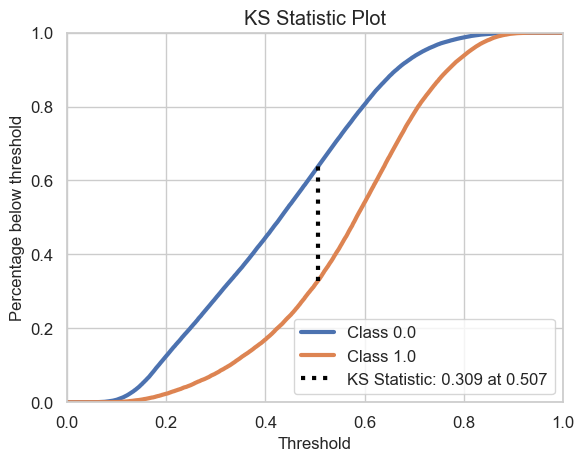

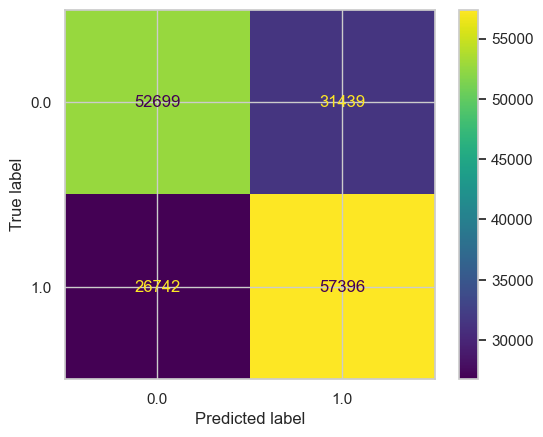


Accuracy:         0.6543
Recall:           0.6822
Precision:        0.6461
F1:               0.6636
AUROC:            0.7116
KS:               0.3094


In [88]:
testePlot(xgb_opt, X_val, y_val.ravel())

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7495435759197444, early_stopping_rounds=None,
              enable_categorical=False, eta=0.20890510912749663,
              eval_metric='logloss', feature_types=None,
              gamma=0.5349207635669678, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=7, missing=nan,
              monotone_constraints=None, n_estimators=134, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)


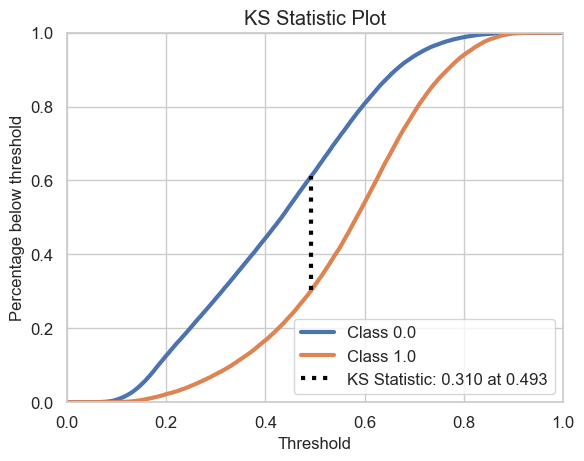

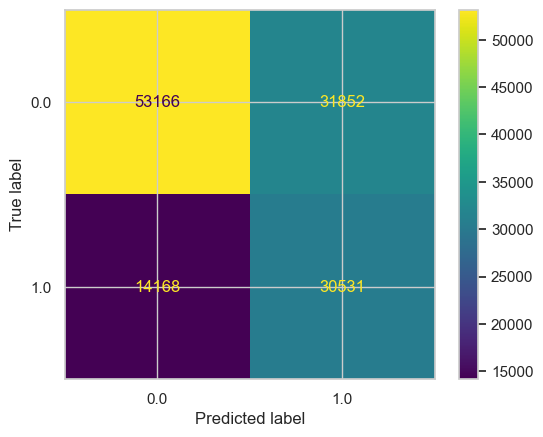


Accuracy:         0.6452
Recall:           0.6830
Precision:        0.4894
F1:               0.5702
AUROC:            0.7131
KS:               0.3098


In [89]:
testePlot(xgb_opt, X_test, y_test.ravel())

### LBM (LightGBM Classifier)

LightGBM Classifier é um algoritmo de aprendizado de máquina que pertence à família de gradient boosting, otimizado para eficiência e precisão. Ele utiliza uma estratégia de construção de árvores chamada "Leaf-wise", que reduz a perda e permite maior eficiência no treinamento, além de instanciar uma técnica chamada "Histogram-Based Learning", que agrupa valores de recursos em histogramas para reduzir a memória necessária durante o treinamento.

In [90]:
def objective_lbm(trial):
    # Define the hyperparameters to optimize
    params_lbm = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    model = lgb.LGBMClassifier(**params_lbm, random_state=42)
    
    #early_stopping_callback = lgb.early_stopping(stopping_rounds=100)
    
    #model.fit(X_train, y_train.ravel(), eval_set=[(X_val, y_val.ravel())], callbacks=[early_stopping_callback])
    model.fit(X_train, y_train.ravel(), eval_set=[(X_val, y_val.ravel())]) 
   
    y_pred = model.predict(X_val)
    y_pred_score_positive = model.predict_proba(X_val)[:,1]
    """
    if((not np.any(y_pred)) or np.all(y_pred)):
        ks = 0
    else:
    """
    ks = ks_results(reshape_plot(y_val, y_pred_score_positive)[0], reshape_plot(y_val, y_pred_score_positive)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)

    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo, e não apenas os melhores parâmetros. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [91]:
def callback_lbm(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Iniciamos o nosso estudo:

In [92]:
# Measure the start time
start_time_lbm = time.time()

study_lbm = optuna.create_study(direction='maximize')

study_lbm.optimize(objective_lbm, n_trials=n_trials, callbacks=[callback_lbm])

print('Number of finished trials:', len(study_lbm.trials))
print('Best trial:', study_lbm.best_trial.params)

# Measure the end time
end_time_lbm = time.time()

# Calculate the duration in seconds
duration_lbm = end_time_lbm - start_time_lbm

[I 2023-09-12 07:20:04,655] A new study created in memory with name: no-name-f160ad23-2334-4685-8549-908350e93a0f


[1]	valid_0's binary_logloss: 0.685785
[2]	valid_0's binary_logloss: 0.679375
[3]	valid_0's binary_logloss: 0.674046
[4]	valid_0's binary_logloss: 0.669398
[5]	valid_0's binary_logloss: 0.66519
[6]	valid_0's binary_logloss: 0.661541
[7]	valid_0's binary_logloss: 0.658585
[8]	valid_0's binary_logloss: 0.655594
[9]	valid_0's binary_logloss: 0.653156
[10]	valid_0's binary_logloss: 0.650611
[11]	valid_0's binary_logloss: 0.648509
[12]	valid_0's binary_logloss: 0.646798
[13]	valid_0's binary_logloss: 0.645164
[14]	valid_0's binary_logloss: 0.643627
[15]	valid_0's binary_logloss: 0.642219
[16]	valid_0's binary_logloss: 0.640693
[17]	valid_0's binary_logloss: 0.63965
[18]	valid_0's binary_logloss: 0.638619
[19]	valid_0's binary_logloss: 0.637511
[20]	valid_0's binary_logloss: 0.636573
[21]	valid_0's binary_logloss: 0.635716
[22]	valid_0's binary_logloss: 0.634963
[23]	valid_0's binary_logloss: 0.634186
[24]	valid_0's binary_logloss: 0.633524
[25]	valid_0's binary_logloss: 0.632924
[26]	valid_

[I 2023-09-12 07:20:46,302] Trial 0 finished with value: 0.3131403170981008 and parameters: {'learning_rate': 0.08526797271200857, 'max_depth': 8, 'subsample': 0.5282413130175734, 'colsample_bytree': 0.8027370587909934, 'min_child_samples': 11, 'num_leaves': 32, 'reg_alpha': 0.8730515016284367, 'reg_lambda': 0.30483048525725376}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.689021
[2]	valid_0's binary_logloss: 0.685274
[3]	valid_0's binary_logloss: 0.681922
[4]	valid_0's binary_logloss: 0.678818
[5]	valid_0's binary_logloss: 0.675772
[6]	valid_0's binary_logloss: 0.672885
[7]	valid_0's binary_logloss: 0.670467
[8]	valid_0's binary_logloss: 0.668104
[9]	valid_0's binary_logloss: 0.665957
[10]	valid_0's binary_logloss: 0.663788
[11]	valid_0's binary_logloss: 0.661757
[12]	valid_0's binary_logloss: 0.659958
[13]	valid_0's binary_logloss: 0.65816
[14]	valid_0's binary_logloss: 0.656504
[15]	valid_0's binary_logloss: 0.654975
[16]	valid_0's binary_logloss: 0.653428
[17]	valid_0's binary_logloss: 0.652091
[18]	valid_0's binary_logloss: 0.650925
[19]	valid_0's binary_logloss: 0.649666
[20]	valid_0's binary_logloss: 0.64861
[21]	valid_0's binary_logloss: 0.647398
[22]	valid_0's binary_logloss: 0.646404
[23]	valid_0's binary_logloss: 0.645396
[24]	valid_0's binary_logloss: 0.644465
[25]	valid_0's binary_logloss: 0.64364
[26]	valid_0

[I 2023-09-12 07:21:28,603] Trial 1 finished with value: 0.30703130571204446 and parameters: {'learning_rate': 0.04353206730392041, 'max_depth': 10, 'subsample': 0.7756382904265783, 'colsample_bytree': 0.7442681352138596, 'min_child_samples': 17, 'num_leaves': 44, 'reg_alpha': 0.07866962913559761, 'reg_lambda': 0.030011991382893122}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.6736
[2]	valid_0's binary_logloss: 0.662045
[3]	valid_0's binary_logloss: 0.65256
[4]	valid_0's binary_logloss: 0.647346
[5]	valid_0's binary_logloss: 0.643968
[6]	valid_0's binary_logloss: 0.639626
[7]	valid_0's binary_logloss: 0.636739
[8]	valid_0's binary_logloss: 0.634561
[9]	valid_0's binary_logloss: 0.632885
[10]	valid_0's binary_logloss: 0.631452
[11]	valid_0's binary_logloss: 0.629653
[12]	valid_0's binary_logloss: 0.628592
[13]	valid_0's binary_logloss: 0.627933
[14]	valid_0's binary_logloss: 0.62748
[15]	valid_0's binary_logloss: 0.626722
[16]	valid_0's binary_logloss: 0.626211
[17]	valid_0's binary_logloss: 0.625729
[18]	valid_0's binary_logloss: 0.625274
[19]	valid_0's binary_logloss: 0.624984
[20]	valid_0's binary_logloss: 0.624702
[21]	valid_0's binary_logloss: 0.624337
[22]	valid_0's binary_logloss: 0.623987
[23]	valid_0's binary_logloss: 0.623771
[24]	valid_0's binary_logloss: 0.623274
[25]	valid_0's binary_logloss: 0.623034
[26]	valid_0'

[I 2023-09-12 07:22:00,590] Trial 2 finished with value: 0.3095390905417291 and parameters: {'learning_rate': 0.2721518532386233, 'max_depth': 5, 'subsample': 0.8941308624625345, 'colsample_bytree': 0.6965855305575586, 'min_child_samples': 9, 'num_leaves': 64, 'reg_alpha': 0.5180725470272105, 'reg_lambda': 0.21763154055672096}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.689666
[2]	valid_0's binary_logloss: 0.686504
[3]	valid_0's binary_logloss: 0.683628
[4]	valid_0's binary_logloss: 0.680841
[5]	valid_0's binary_logloss: 0.678495
[6]	valid_0's binary_logloss: 0.67607
[7]	valid_0's binary_logloss: 0.673902
[8]	valid_0's binary_logloss: 0.67198
[9]	valid_0's binary_logloss: 0.670068
[10]	valid_0's binary_logloss: 0.668075
[11]	valid_0's binary_logloss: 0.66627
[12]	valid_0's binary_logloss: 0.664606
[13]	valid_0's binary_logloss: 0.662972
[14]	valid_0's binary_logloss: 0.661431
[15]	valid_0's binary_logloss: 0.660291
[16]	valid_0's binary_logloss: 0.658823
[17]	valid_0's binary_logloss: 0.657646
[18]	valid_0's binary_logloss: 0.656548
[19]	valid_0's binary_logloss: 0.655461
[20]	valid_0's binary_logloss: 0.654468
[21]	valid_0's binary_logloss: 0.653469
[22]	valid_0's binary_logloss: 0.652257
[23]	valid_0's binary_logloss: 0.651274
[24]	valid_0's binary_logloss: 0.650237
[25]	valid_0's binary_logloss: 0.649472
[26]	valid_0

[I 2023-09-12 07:22:36,879] Trial 3 finished with value: 0.3029784401816064 and parameters: {'learning_rate': 0.04378582423050243, 'max_depth': 7, 'subsample': 0.8669045412133984, 'colsample_bytree': 0.5123217810541734, 'min_child_samples': 6, 'num_leaves': 19, 'reg_alpha': 0.5102547921564835, 'reg_lambda': 0.8814085558543561}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.671572
[2]	valid_0's binary_logloss: 0.658889
[3]	valid_0's binary_logloss: 0.650893
[4]	valid_0's binary_logloss: 0.643602
[5]	valid_0's binary_logloss: 0.63987
[6]	valid_0's binary_logloss: 0.636912
[7]	valid_0's binary_logloss: 0.634509
[8]	valid_0's binary_logloss: 0.632772
[9]	valid_0's binary_logloss: 0.630933
[10]	valid_0's binary_logloss: 0.629213
[11]	valid_0's binary_logloss: 0.627947
[12]	valid_0's binary_logloss: 0.627365
[13]	valid_0's binary_logloss: 0.626343
[14]	valid_0's binary_logloss: 0.625715
[15]	valid_0's binary_logloss: 0.62531
[16]	valid_0's binary_logloss: 0.624893
[17]	valid_0's binary_logloss: 0.62455
[18]	valid_0's binary_logloss: 0.624161
[19]	valid_0's binary_logloss: 0.623485
[20]	valid_0's binary_logloss: 0.623126
[21]	valid_0's binary_logloss: 0.622835
[22]	valid_0's binary_logloss: 0.622468
[23]	valid_0's binary_logloss: 0.622149
[24]	valid_0's binary_logloss: 0.621954
[25]	valid_0's binary_logloss: 0.621764
[26]	valid_0

[I 2023-09-12 07:23:11,982] Trial 4 finished with value: 0.30682925669733063 and parameters: {'learning_rate': 0.2818177028244752, 'max_depth': 6, 'subsample': 0.6628956562695703, 'colsample_bytree': 0.565215289303932, 'min_child_samples': 12, 'num_leaves': 38, 'reg_alpha': 0.9266179108787969, 'reg_lambda': 0.5939754157940321}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.672546
[2]	valid_0's binary_logloss: 0.660211
[3]	valid_0's binary_logloss: 0.652128
[4]	valid_0's binary_logloss: 0.645018
[5]	valid_0's binary_logloss: 0.641186
[6]	valid_0's binary_logloss: 0.6376
[7]	valid_0's binary_logloss: 0.635361
[8]	valid_0's binary_logloss: 0.633592
[9]	valid_0's binary_logloss: 0.631497
[10]	valid_0's binary_logloss: 0.629863
[11]	valid_0's binary_logloss: 0.628402
[12]	valid_0's binary_logloss: 0.62765
[13]	valid_0's binary_logloss: 0.626843
[14]	valid_0's binary_logloss: 0.626152
[15]	valid_0's binary_logloss: 0.625861
[16]	valid_0's binary_logloss: 0.625438
[17]	valid_0's binary_logloss: 0.625089
[18]	valid_0's binary_logloss: 0.624691
[19]	valid_0's binary_logloss: 0.62385
[20]	valid_0's binary_logloss: 0.623485
[21]	valid_0's binary_logloss: 0.623335
[22]	valid_0's binary_logloss: 0.622872
[23]	valid_0's binary_logloss: 0.622644
[24]	valid_0's binary_logloss: 0.62251
[25]	valid_0's binary_logloss: 0.622414
[26]	valid_0's

[I 2023-09-12 07:23:47,996] Trial 5 finished with value: 0.3076968789369845 and parameters: {'learning_rate': 0.2603168013563774, 'max_depth': 6, 'subsample': 0.9888957910603331, 'colsample_bytree': 0.5324492549710196, 'min_child_samples': 14, 'num_leaves': 65, 'reg_alpha': 0.10633537358056888, 'reg_lambda': 0.3925977188120502}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.671921
[2]	valid_0's binary_logloss: 0.658903
[3]	valid_0's binary_logloss: 0.650567
[4]	valid_0's binary_logloss: 0.644462
[5]	valid_0's binary_logloss: 0.640245
[6]	valid_0's binary_logloss: 0.636611
[7]	valid_0's binary_logloss: 0.634113
[8]	valid_0's binary_logloss: 0.632074
[9]	valid_0's binary_logloss: 0.630642
[10]	valid_0's binary_logloss: 0.629311
[11]	valid_0's binary_logloss: 0.627871
[12]	valid_0's binary_logloss: 0.627072
[13]	valid_0's binary_logloss: 0.62613
[14]	valid_0's binary_logloss: 0.62504
[15]	valid_0's binary_logloss: 0.624565
[16]	valid_0's binary_logloss: 0.624072
[17]	valid_0's binary_logloss: 0.623457
[18]	valid_0's binary_logloss: 0.623115
[19]	valid_0's binary_logloss: 0.622637
[20]	valid_0's binary_logloss: 0.622295
[21]	valid_0's binary_logloss: 0.622119
[22]	valid_0's binary_logloss: 0.621643
[23]	valid_0's binary_logloss: 0.6211
[24]	valid_0's binary_logloss: 0.620818
[25]	valid_0's binary_logloss: 0.620759
[26]	valid_0'

[I 2023-09-12 07:24:21,709] Trial 6 finished with value: 0.31053745037913905 and parameters: {'learning_rate': 0.2666400694358958, 'max_depth': 10, 'subsample': 0.9842265109689547, 'colsample_bytree': 0.6977272141357289, 'min_child_samples': 14, 'num_leaves': 35, 'reg_alpha': 0.22396047351047366, 'reg_lambda': 0.9793972160993288}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.675834
[2]	valid_0's binary_logloss: 0.665448
[3]	valid_0's binary_logloss: 0.658855
[4]	valid_0's binary_logloss: 0.651438
[5]	valid_0's binary_logloss: 0.648016
[6]	valid_0's binary_logloss: 0.644137
[7]	valid_0's binary_logloss: 0.641623
[8]	valid_0's binary_logloss: 0.63992
[9]	valid_0's binary_logloss: 0.637715
[10]	valid_0's binary_logloss: 0.6362
[11]	valid_0's binary_logloss: 0.63481
[12]	valid_0's binary_logloss: 0.633575
[13]	valid_0's binary_logloss: 0.632705
[14]	valid_0's binary_logloss: 0.63165
[15]	valid_0's binary_logloss: 0.631097
[16]	valid_0's binary_logloss: 0.630174
[17]	valid_0's binary_logloss: 0.629638
[18]	valid_0's binary_logloss: 0.629139
[19]	valid_0's binary_logloss: 0.628617
[20]	valid_0's binary_logloss: 0.628384
[21]	valid_0's binary_logloss: 0.627829
[22]	valid_0's binary_logloss: 0.627331
[23]	valid_0's binary_logloss: 0.626855
[24]	valid_0's binary_logloss: 0.626574
[25]	valid_0's binary_logloss: 0.62626
[26]	valid_0's 

[I 2023-09-12 07:24:54,533] Trial 7 finished with value: 0.30977679526492186 and parameters: {'learning_rate': 0.27552277472553277, 'max_depth': 8, 'subsample': 0.9901845863514612, 'colsample_bytree': 0.6143408873268719, 'min_child_samples': 17, 'num_leaves': 11, 'reg_alpha': 0.33353055273368926, 'reg_lambda': 0.22395654793490782}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.689301
[2]	valid_0's binary_logloss: 0.685676
[3]	valid_0's binary_logloss: 0.682411
[4]	valid_0's binary_logloss: 0.679433
[5]	valid_0's binary_logloss: 0.6765
[6]	valid_0's binary_logloss: 0.673787
[7]	valid_0's binary_logloss: 0.671243
[8]	valid_0's binary_logloss: 0.668964
[9]	valid_0's binary_logloss: 0.666843
[10]	valid_0's binary_logloss: 0.664681
[11]	valid_0's binary_logloss: 0.662746
[12]	valid_0's binary_logloss: 0.661015
[13]	valid_0's binary_logloss: 0.65925
[14]	valid_0's binary_logloss: 0.657611
[15]	valid_0's binary_logloss: 0.656056
[16]	valid_0's binary_logloss: 0.654542
[17]	valid_0's binary_logloss: 0.653155
[18]	valid_0's binary_logloss: 0.651823
[19]	valid_0's binary_logloss: 0.650586
[20]	valid_0's binary_logloss: 0.649494
[21]	valid_0's binary_logloss: 0.648389
[22]	valid_0's binary_logloss: 0.64738
[23]	valid_0's binary_logloss: 0.646329
[24]	valid_0's binary_logloss: 0.645384
[25]	valid_0's binary_logloss: 0.644428
[26]	valid_0'

[I 2023-09-12 07:25:36,112] Trial 8 finished with value: 0.30710261712900233 and parameters: {'learning_rate': 0.03940968778207909, 'max_depth': 8, 'subsample': 0.793808331726263, 'colsample_bytree': 0.8797232106244104, 'min_child_samples': 5, 'num_leaves': 61, 'reg_alpha': 0.5503200316881868, 'reg_lambda': 0.4974570629815672}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.691421
[2]	valid_0's binary_logloss: 0.689792
[3]	valid_0's binary_logloss: 0.688264
[4]	valid_0's binary_logloss: 0.686825
[5]	valid_0's binary_logloss: 0.685819
[6]	valid_0's binary_logloss: 0.684444
[7]	valid_0's binary_logloss: 0.683143
[8]	valid_0's binary_logloss: 0.681953
[9]	valid_0's binary_logloss: 0.680852
[10]	valid_0's binary_logloss: 0.679626
[11]	valid_0's binary_logloss: 0.678509
[12]	valid_0's binary_logloss: 0.67742
[13]	valid_0's binary_logloss: 0.676418
[14]	valid_0's binary_logloss: 0.675403
[15]	valid_0's binary_logloss: 0.674556
[16]	valid_0's binary_logloss: 0.673643
[17]	valid_0's binary_logloss: 0.672762
[18]	valid_0's binary_logloss: 0.671963
[19]	valid_0's binary_logloss: 0.671182
[20]	valid_0's binary_logloss: 0.670436
[21]	valid_0's binary_logloss: 0.669707
[22]	valid_0's binary_logloss: 0.668994
[23]	valid_0's binary_logloss: 0.668281
[24]	valid_0's binary_logloss: 0.667376
[25]	valid_0's binary_logloss: 0.666736
[26]	valid

[I 2023-09-12 07:26:10,794] Trial 9 finished with value: 0.27705674011742615 and parameters: {'learning_rate': 0.02743764683755382, 'max_depth': 3, 'subsample': 0.6768225458480795, 'colsample_bytree': 0.5293822358128596, 'min_child_samples': 11, 'num_leaves': 18, 'reg_alpha': 0.9002395568588982, 'reg_lambda': 0.2544966453854127}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.684931
[2]	valid_0's binary_logloss: 0.678415
[3]	valid_0's binary_logloss: 0.673222
[4]	valid_0's binary_logloss: 0.668636
[5]	valid_0's binary_logloss: 0.66477
[6]	valid_0's binary_logloss: 0.661329
[7]	valid_0's binary_logloss: 0.65866
[8]	valid_0's binary_logloss: 0.656008
[9]	valid_0's binary_logloss: 0.652679
[10]	valid_0's binary_logloss: 0.650355
[11]	valid_0's binary_logloss: 0.64821
[12]	valid_0's binary_logloss: 0.646609
[13]	valid_0's binary_logloss: 0.645121
[14]	valid_0's binary_logloss: 0.643927
[15]	valid_0's binary_logloss: 0.642591
[16]	valid_0's binary_logloss: 0.641704
[17]	valid_0's binary_logloss: 0.640372
[18]	valid_0's binary_logloss: 0.639458
[19]	valid_0's binary_logloss: 0.638489
[20]	valid_0's binary_logloss: 0.637834
[21]	valid_0's binary_logloss: 0.637176
[22]	valid_0's binary_logloss: 0.636338
[23]	valid_0's binary_logloss: 0.635716
[24]	valid_0's binary_logloss: 0.635134
[25]	valid_0's binary_logloss: 0.634613
[26]	valid_0

[I 2023-09-12 07:26:44,105] Trial 10 finished with value: 0.3088854025529487 and parameters: {'learning_rate': 0.11862656098752025, 'max_depth': 4, 'subsample': 0.5009025756605527, 'colsample_bytree': 0.8819867174964231, 'min_child_samples': 2, 'num_leaves': 93, 'reg_alpha': 0.7276135836876677, 'reg_lambda': 0.05023183492837491}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.676662
[2]	valid_0's binary_logloss: 0.665283
[3]	valid_0's binary_logloss: 0.657445
[4]	valid_0's binary_logloss: 0.650861
[5]	valid_0's binary_logloss: 0.64621
[6]	valid_0's binary_logloss: 0.642437
[7]	valid_0's binary_logloss: 0.639092
[8]	valid_0's binary_logloss: 0.63674
[9]	valid_0's binary_logloss: 0.634465
[10]	valid_0's binary_logloss: 0.63293
[11]	valid_0's binary_logloss: 0.631576
[12]	valid_0's binary_logloss: 0.630541
[13]	valid_0's binary_logloss: 0.629582
[14]	valid_0's binary_logloss: 0.628613
[15]	valid_0's binary_logloss: 0.627513
[16]	valid_0's binary_logloss: 0.626973
[17]	valid_0's binary_logloss: 0.626238
[18]	valid_0's binary_logloss: 0.6257
[19]	valid_0's binary_logloss: 0.625033
[20]	valid_0's binary_logloss: 0.624433
[21]	valid_0's binary_logloss: 0.623918
[22]	valid_0's binary_logloss: 0.623629
[23]	valid_0's binary_logloss: 0.623153
[24]	valid_0's binary_logloss: 0.622843
[25]	valid_0's binary_logloss: 0.622656
[26]	valid_0's

[I 2023-09-12 07:27:19,294] Trial 11 finished with value: 0.31155958068886835 and parameters: {'learning_rate': 0.19247982223441212, 'max_depth': 10, 'subsample': 0.500992725461096, 'colsample_bytree': 0.815250411220979, 'min_child_samples': 19, 'num_leaves': 37, 'reg_alpha': 0.2940607268935185, 'reg_lambda': 0.8513568538689544}. Best is trial 0 with value: 0.3131403170981008.


[1]	valid_0's binary_logloss: 0.678839
[2]	valid_0's binary_logloss: 0.668286
[3]	valid_0's binary_logloss: 0.660914
[4]	valid_0's binary_logloss: 0.65475
[5]	valid_0's binary_logloss: 0.650271
[6]	valid_0's binary_logloss: 0.646564
[7]	valid_0's binary_logloss: 0.643451
[8]	valid_0's binary_logloss: 0.640617
[9]	valid_0's binary_logloss: 0.638101
[10]	valid_0's binary_logloss: 0.636314
[11]	valid_0's binary_logloss: 0.634709
[12]	valid_0's binary_logloss: 0.633283
[13]	valid_0's binary_logloss: 0.632049
[14]	valid_0's binary_logloss: 0.630798
[15]	valid_0's binary_logloss: 0.629682
[16]	valid_0's binary_logloss: 0.62904
[17]	valid_0's binary_logloss: 0.628115
[18]	valid_0's binary_logloss: 0.62766
[19]	valid_0's binary_logloss: 0.626936
[20]	valid_0's binary_logloss: 0.626213
[21]	valid_0's binary_logloss: 0.625643
[22]	valid_0's binary_logloss: 0.625148
[23]	valid_0's binary_logloss: 0.624477
[24]	valid_0's binary_logloss: 0.624117
[25]	valid_0's binary_logloss: 0.623769
[26]	valid_0

[I 2023-09-12 07:27:54,303] Trial 12 finished with value: 0.31322351375121826 and parameters: {'learning_rate': 0.1725801666450626, 'max_depth': 9, 'subsample': 0.528464115881863, 'colsample_bytree': 0.8129328289669461, 'min_child_samples': 19, 'num_leaves': 30, 'reg_alpha': 0.354841015144509, 'reg_lambda': 0.7513560865918962}. Best is trial 12 with value: 0.31322351375121826.


[1]	valid_0's binary_logloss: 0.683038
[2]	valid_0's binary_logloss: 0.675025
[3]	valid_0's binary_logloss: 0.668887
[4]	valid_0's binary_logloss: 0.663402
[5]	valid_0's binary_logloss: 0.659033
[6]	valid_0's binary_logloss: 0.655282
[7]	valid_0's binary_logloss: 0.651929
[8]	valid_0's binary_logloss: 0.649276
[9]	valid_0's binary_logloss: 0.647134
[10]	valid_0's binary_logloss: 0.644826
[11]	valid_0's binary_logloss: 0.642683
[12]	valid_0's binary_logloss: 0.640962
[13]	valid_0's binary_logloss: 0.639064
[14]	valid_0's binary_logloss: 0.637796
[15]	valid_0's binary_logloss: 0.636573
[16]	valid_0's binary_logloss: 0.635526
[17]	valid_0's binary_logloss: 0.634689
[18]	valid_0's binary_logloss: 0.633832
[19]	valid_0's binary_logloss: 0.633154
[20]	valid_0's binary_logloss: 0.632294
[21]	valid_0's binary_logloss: 0.631646
[22]	valid_0's binary_logloss: 0.630883
[23]	valid_0's binary_logloss: 0.630155
[24]	valid_0's binary_logloss: 0.629631
[25]	valid_0's binary_logloss: 0.629029
[26]	vali

[I 2023-09-12 07:28:30,178] Trial 13 finished with value: 0.3136751527252847 and parameters: {'learning_rate': 0.12064367061732684, 'max_depth': 8, 'subsample': 0.5844217068164994, 'colsample_bytree': 0.9992617683263532, 'min_child_samples': 20, 'num_leaves': 26, 'reg_alpha': 0.7364308212430883, 'reg_lambda': 0.6839646192584444}. Best is trial 13 with value: 0.3136751527252847.


[1]	valid_0's binary_logloss: 0.678047
[2]	valid_0's binary_logloss: 0.667276
[3]	valid_0's binary_logloss: 0.659569
[4]	valid_0's binary_logloss: 0.65322
[5]	valid_0's binary_logloss: 0.648291
[6]	valid_0's binary_logloss: 0.644323
[7]	valid_0's binary_logloss: 0.641149
[8]	valid_0's binary_logloss: 0.638188
[9]	valid_0's binary_logloss: 0.636301
[10]	valid_0's binary_logloss: 0.634356
[11]	valid_0's binary_logloss: 0.632571
[12]	valid_0's binary_logloss: 0.631089
[13]	valid_0's binary_logloss: 0.630094
[14]	valid_0's binary_logloss: 0.629055
[15]	valid_0's binary_logloss: 0.627966
[16]	valid_0's binary_logloss: 0.62713
[17]	valid_0's binary_logloss: 0.626627
[18]	valid_0's binary_logloss: 0.62607
[19]	valid_0's binary_logloss: 0.625555
[20]	valid_0's binary_logloss: 0.624843
[21]	valid_0's binary_logloss: 0.624254
[22]	valid_0's binary_logloss: 0.623735
[23]	valid_0's binary_logloss: 0.623345
[24]	valid_0's binary_logloss: 0.622975
[25]	valid_0's binary_logloss: 0.622735
[26]	valid_0

[I 2023-09-12 07:29:06,840] Trial 14 finished with value: 0.3128431861941097 and parameters: {'learning_rate': 0.1665815738993891, 'max_depth': 9, 'subsample': 0.5934251249609479, 'colsample_bytree': 0.9490326917049089, 'min_child_samples': 20, 'num_leaves': 50, 'reg_alpha': 0.6850386980607668, 'reg_lambda': 0.6869033301157681}. Best is trial 13 with value: 0.3136751527252847.


Number of finished trials: 15
Best trial: {'learning_rate': 0.12064367061732684, 'max_depth': 8, 'subsample': 0.5844217068164994, 'colsample_bytree': 0.9992617683263532, 'min_child_samples': 20, 'num_leaves': 26, 'reg_alpha': 0.7364308212430883, 'reg_lambda': 0.6839646192584444}


Temos aqui os melhores atributos do nosso estudo:

In [93]:
study_lbm.best_trial.user_attrs

{'roc_auc': 0.7147128268609666,
 'ks': 0.3136751527252847,
 'accuracy': 0.6565701585490503,
 'precision': 0.6497345957558054,
 'recall': 0.6793957545936438,
 'f1': 0.664234212773869,
 'best_model': LGBMClassifier(colsample_bytree=0.9992617683263532,
                learning_rate=0.12064367061732684, max_depth=8,
                metric='binary_logloss', num_leaves=26, objective='binary',
                random_state=42, reg_alpha=0.7364308212430883,
                reg_lambda=0.6839646192584444, subsample=0.5844217068164994,
                verbosity=-1)}

Temos o melhor valor para o KS:

In [94]:
ks_lbm = max([trial.user_attrs['ks'] for trial in study_lbm.trials])
print(ks_lbm)

0.3136751527252847


Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [95]:
results_lbm_opt = pd.DataFrame({'model': 'LightGBM Optuna','ks': study_lbm.best_trial.user_attrs['ks'], 'roc_auc': study_lbm.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_lbm.best_trial.user_attrs['accuracy'], 'precision': study_lbm.best_trial.user_attrs['precision'], \
                            'recall': study_lbm.best_trial.user_attrs['recall'], 'f1': study_lbm.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_lbm))}, index=[0])

results = pd.concat([results, results_lbm_opt])
results

,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17
0,Gradient Boosting Optuna,0.312403,0.713492,0.654502,0.658718,0.64122,0.649852,14:10:52
0,GXB Optuna,0.309408,0.711585,0.654253,0.646097,0.682165,0.663641,00:08:42
0,LightGBM Optuna,0.313675,0.714713,0.65657,0.649735,0.679396,0.664234,00:09:02


Temos o nosso melhor modelo:

In [96]:
lbm_opt = study_lbm.user_attrs["best_model"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo LGBMClassifier(colsample_bytree=0.9992617683263532,
               learning_rate=0.12064367061732684, max_depth=8,
               metric='binary_logloss', num_leaves=26, objective='binary',
               random_state=42, reg_alpha=0.7364308212430883,
               reg_lambda=0.6839646192584444, subsample=0.5844217068164994,
               verbosity=-1)


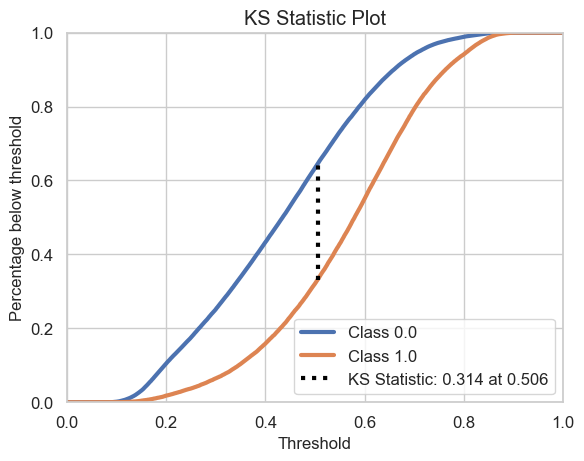

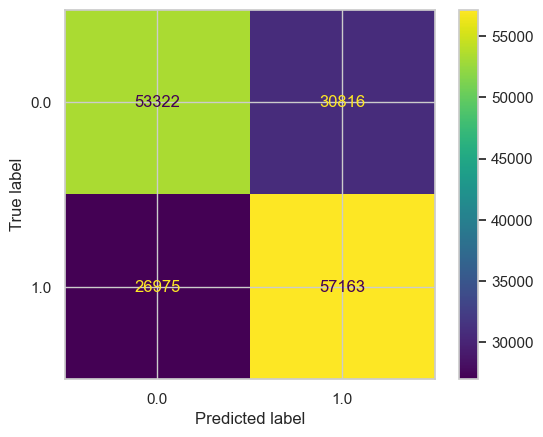


Accuracy:         0.6566
Recall:           0.6794
Precision:        0.6497
F1:               0.6642
AUROC:            0.7147
KS:               0.3137


In [97]:
testePlot(lbm_opt, X_val, y_val.ravel())

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

Gerando análises para o modelo LGBMClassifier(colsample_bytree=0.9992617683263532,
               learning_rate=0.12064367061732684, max_depth=8,
               metric='binary_logloss', num_leaves=26, objective='binary',
               random_state=42, reg_alpha=0.7364308212430883,
               reg_lambda=0.6839646192584444, subsample=0.5844217068164994,
               verbosity=-1)


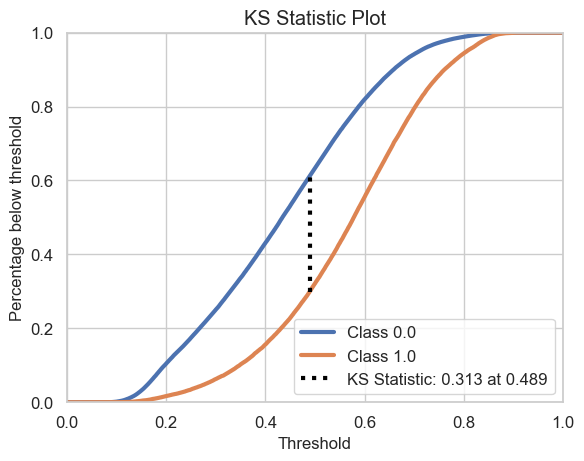

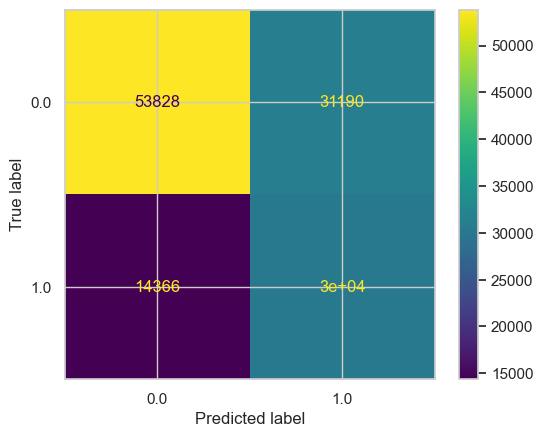


Accuracy:         0.6488
Recall:           0.6786
Precision:        0.4930
F1:               0.5711
AUROC:            0.7151
KS:               0.3132


In [98]:
testePlot(lbm_opt, X_test, y_test.ravel())

Random Forest, Gradient Boosting, XGBoost e LightGBM são todos algoritmos de aprendizado de máquina que pertencem à família de métodos ensemble e são comumente usados tanto para tarefas de classificação quanto de regressão. Eles compartilham algumas semelhanças, mas também possuem características distintas. Aqui está uma comparação desses algoritmos:

**Apesar de superficialmente explicados enteriormente, aqui está uma breve análise dos diversos aspectos desses modelos:**

- Random Forest:

É um método ensemble que combina múltiplas árvores de decisão. | Cada árvore é treinada em um subconjunto aleatório de características e/ou amostras. | Reduz o overfitting e melhora a generalização. | Processo de treinamento paralelizável. | Lida com dados numéricos e categóricos. | Pode lidar com conjuntos de dados grandes com alta dimensionalidade. | Fornece ranking de importância de características.

- Gradient Boosting:

Método ensemble que combina learners fracos (geralmente árvores de decisão) de forma sequencial. | Cada modelo subsequente se concentra em corrigir os erros cometidos pelo modelo anterior. | O treinamento é realizado de forma iterativa, minimizando uma função de perda. | Geralmente mais lento que o Random Forest devido à natureza sequencial. | Lida com dados numéricos e categóricos. | Pode lidar com conjuntos de dados grandes, mas pode requerer mais memória que o Random Forest. | Fornece ranking de importância de características.

- XGBoost (Extreme Gradient Boosting):

Uma implementação altamente otimizada do gradient boosting. | Fornece técnicas adicionais de regularização para controlar o overfitting. | Usa um algoritmo mais eficiente para a construção das árvores. | Suporta paralelização e computação distribuída. | Pode lidar com valores ausentes internamente. | Suporta parada antecipada (early stopping) para evitar overfitting. | Frequentemente fornece melhor desempenho em comparação com o gradient boosting tradicional.

- LightGBM (Light Gradient Boosting Machine):

Outra implementação otimizada do gradient boosting. | Usa uma abordagem baseada em histograma para dividir as características, o que pode acelerar o treinamento. | Lida com conjuntos de dados grandes com alta dimensionalidade de forma mais eficiente. | Suporta paralelização e computação distribuída. | Pode lidar com características categóricas diretamente, sem necessidade de codificação one-hot. | Fornece tempos de treinamento mais rápidos em comparação com o XGBoost em alguns cenários.

### Ensemble

Para finalizar a análise a partir de modelos tradicionais, criamos um ensemble usando os modelos LightGBM Classifier, XGBoost, Random Forest e Gradient Boosting com um Voting Classifier, combinando as previsões desses modelos individuais para tomar uma decisão final. O Voting Classifier é uma técnica de ensemble que combina as previsões de vários modelos de maneira ponderada ou por maioria de votos.

Utilizamos uma abordagem de *Soft Voting Classifier*, em que as previsões dos modelos são ponderadas pela confiança que cada modelo tem em sua previsão. Modelos mais confiantes têm mais peso em suas previsões. Isso pode ser benéfico quando alguns modelos têm melhor desempenho em certas situações e pior em outras.

Caso usássemos *Hard Voting Classifier*, cada modelo contribuiria com uma previsão e a classe mais votada seria escolhida como a previsão final. Se a maioria dos modelos estivesse correta, o ensemble provavelmente faria uma previsão precisa. No entanto, se um dos modelos tiver um desempenho muito pior do que os outros, isso poderia afetar a precisão do ensemble.

Instanciamos o nosso modelo de Ensemble com base nos modelos obtidos até o momento:

In [99]:
# Measure the start time
start_time_ens = time.time()

ens_clf = VotingClassifier([('gb', gradient_boosting_opt), ('rf', random_forest_opt), ('xgboost', xgb_opt), ('lightgbm', lbm_opt)], voting='soft')

ens_clf.fit(X_train, y_train.ravel())

# Measure the end time
end_time_ens = time.time()

# Calculate the duration in seconds
duration_ens = end_time_ens - start_time_ens + duration_rf + duration_gb + duration_xgb + duration_lbm

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.9896           0.0081          128.48m
         2           0.9807           0.0074          127.72m
         3           0.9726           0.0066          126.71m
         4           0.9650           0.0060          125.54m
         5           0.9579           0.0054          124.93m
         6           0.9517           0.0048          124.07m
         7           0.9460           0.0045          123.27m
         8           0.9400           0.0040          122.39m
         9           0.9349           0.0038          121.80m
        10           0.9299           0.0035          121.08m
        11           0.9253           0.0034          120.35m
        12           0.9210           0.0030          119.69m
        13           0.9165           0.0028          119.07m
        14           0.9127           0.0026          118.51m
        15           0.9091           0.0024          117.65m
       

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 94.5min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed: 147.9min finished


Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(learning_rate=0.06568694177774066,
                                                         loss='exponential',
                                                         max_depth=12,
                                                         min_samples_leaf=71,
                                                         min_samples_split=158,
                                                         n_estimators=159,
                                                         random_state=42,
                                                         subsample=0.7312852865743152,
                                                         verbose=2)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                         

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    5.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    5.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.4s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed: 

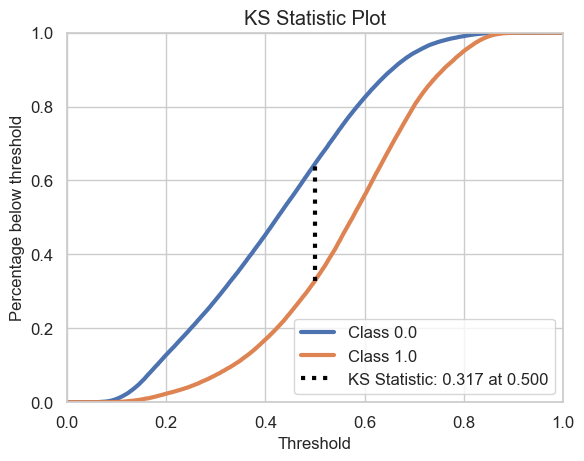

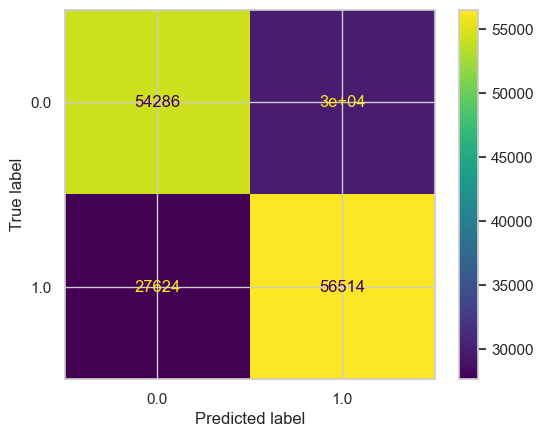


Accuracy:         0.6584
Recall:           0.6717
Precision:        0.6544
F1:               0.6629
AUROC:            0.7166
KS:               0.3170


In [100]:
testePlot(ens_clf, X_val, y_val.ravel())

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

Gerando análises para o modelo VotingClassifier(estimators=[('gb',
                              GradientBoostingClassifier(learning_rate=0.06568694177774066,
                                                         loss='exponential',
                                                         max_depth=12,
                                                         min_samples_leaf=71,
                                                         min_samples_split=158,
                                                         n_estimators=159,
                                                         random_state=42,
                                                         subsample=0.7312852865743152,
                                                         verbose=2)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                         

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    4.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.1s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.8s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    4.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed: 

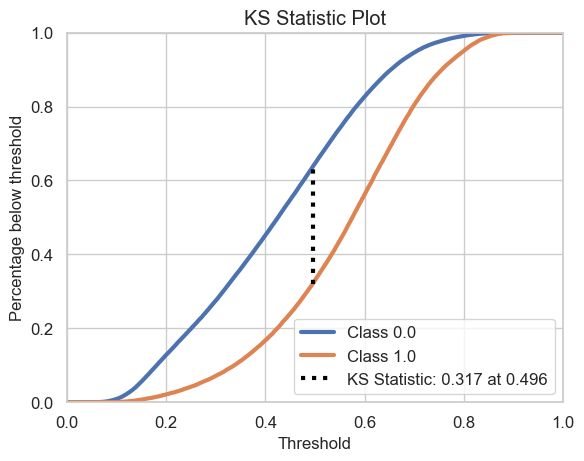

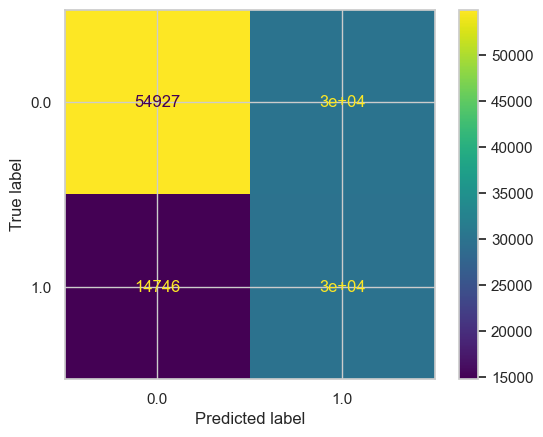


Accuracy:         0.6543
Recall:           0.6701
Precision:        0.4989
F1:               0.5719
AUROC:            0.7178
KS:               0.3169


In [101]:
testePlot(ens_clf, X_test, y_test.ravel())

Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [102]:
y_pred = ens_clf.predict(X_val)
y_pred_score_positive = ens_clf.predict_proba(X_val)[:,1]

results_ens = pd.DataFrame({'model': 'Ensemble','ks': ks_results(reshape_plot(y_val, y_pred_score_positive)[0], reshape_plot(y_val, y_pred_score_positive)[1]), 'roc_auc': roc_auc_score(y_val, y_pred_score_positive),\
                            'accuracy': accuracy_score(y_val, y_pred), 'precision': precision_score(y_val, y_pred), \
                            'recall': recall_score(y_val, y_pred), 'f1': f1_score(y_val, y_pred), \
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_ens))}, index=[0])

results = pd.concat([results, results_ens])
results

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    5.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 525 out of 525 | elapsed:    5.2s finished


,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17
0,Gradient Boosting Optuna,0.312403,0.713492,0.654502,0.658718,0.64122,0.649852,14:10:52
0,GXB Optuna,0.309408,0.711585,0.654253,0.646097,0.682165,0.663641,00:08:42
0,LightGBM Optuna,0.313675,0.714713,0.65657,0.649735,0.679396,0.664234,00:09:02
0,Ensemble,0.317003,0.716638,0.658442,0.654355,0.671682,0.662905,11:14:49


Salvamos os modelos analisados em um diretório separado para não haver necessidade de reprodução exaustiva em cada execução. 

In [103]:
# We save the trained models in order to save time
# We dump our models in a "pkl" file
joblib.dump(random_forest_opt, 'models/random_forest_opt_model.pkl')
joblib.dump(gradient_boosting_opt, 'models/gradient_boosting_opt_model.pkl')
joblib.dump(xgb_opt, 'models/xgb_opt_model.pkl')
joblib.dump(lbm_opt, 'models/lbm_opt_model.pkl')
joblib.dump(ens_clf, 'models/ens_clf_model.pkl')

# We load the trained models in order to save time - If our directory already exists
# # random_forest_opt = joblib.load('models/random_forest_opt_model.pkl')
# # gradient_boosting_opt = joblib.load('models/gradient_boosting_opt_model.pkl')
# # xgb_opt = joblib.load('models/xgb_opt_model.pkl')
# # lbm_opt = joblib.load('models/lbm_opt_model.pkl')
# # ens_clf = joblib.load('models/ens_clf_model.pkl')

['models/ens_clf_model.pkl']

Por quesito de pesquisa, criamos um aquivo ".JSON" para cada modelo, a fim registrar os hiper-parâmetros capturados.

In [104]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/random_forest_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_rf.best_params, json_file, indent=4)

In [105]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/gradient_boosting_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_gb.best_params, json_file, indent=4)

In [106]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/xgb_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_xgb.best_params, json_file, indent=4)

In [107]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/lbm_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_lbm.best_params, json_file, indent=4)

### Neural Networks

Antes de explorarmos a eficácia dos modelos recentes baseados *Transformers*, é válido constatar como modelos de Redes Neurais usuais performam em comparação com os já apresentados (o que deve apresentar uma perspectiva da aplicabilidade de Aprendizagem Profunda em dados tabulares).

#### Funcão Auxiliar

A função *testePlotTorchModel* calcula e exibe as métricas do modelo no conjunto passado para a mesma, bem como o histórico de trainemnto. Temos a seguinte função de plot:

In [108]:
def testePlotTorchModel(model, x, y, mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies):
  print(f'Gerando History Plot')

  epochs = range(1, len(mlp_train_losses) + 1)
  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  ax[0].plot(epochs, mlp_train_accuracies, 'bo', label='Training accuracy')
  ax[0].plot(epochs, mlp_val_accuracies, 'b', label='Validation accuracy')
  ax[0].set_title('Training & Validation Accuracy', fontsize=16)
  ax[0].set_xlabel('Epochs', fontsize=16)
  ax[0].set_ylabel('Accuracy', fontsize=16)
  ax[0].legend()

  ax[1].plot(epochs, mlp_train_losses, 'bo', label='Training loss')
  ax[1].plot(epochs, mlp_val_losses, 'b', label='Validation loss')
  ax[1].set_title('Training & Validation Loss', fontsize=16)
  ax[1].set_xlabel('Epochs', fontsize=16)
  ax[1].set_ylabel('Loss', fontsize=16)
  ax[1].legend()
    
  ################################################
  print(f'Gerando análises para o modelo {model}')
  y_pred = model(torch.tensor(x).to(device).float()).detach().to('cpu').numpy()
  y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])
  #y_pred_score = model.predict_proba(x)

  y_pred_score_all = model.predict_proba(x)
  y_pred_score_positive = model.predict_proba(x)[:,1]

  accuracy = accuracy_score(y, y_pred)
  recall = recall_score(y, y_pred)
  precision = precision_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  print(y.flatten())
  print(y_pred.flatten())
  skplt.metrics.plot_ks_statistic(y, y_pred_score_all)
  plt.show()

  #y_pred_score = y_pred_score[:, 1]
  ks = ks_results(reshape_plot(y, y_pred_score_positive)[0], reshape_plot(y, y_pred_score_positive)[1])
  auroc = roc_auc_score(y, y_pred_score_positive)
  cm = confusion_matrix(y, y_pred, labels = np.unique(y))
  cmd = ConfusionMatrixDisplay(cm, display_labels = np.unique(y))
  cmd.plot()
  plt.show()
    
  # Skip Line  
  print()

  print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
  print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
  print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
  print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))

  if auroc is not None:
      print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
      
  print("{metric:<18}{value:.4f}".format(metric="KS:", value=ks))

A partir desse ponto, nossos dados são alocados como Tensores para que possam ser tratados com paralelismo pela bilbioteca PyTorch (que oferece um ambiente flexível e eficiente para a criação de modelos de aprendizado profundo). Dessarte, a fim de inserirmos paralelismo e otimização no processamento, treinamento e inferência dos dados apresentados, devemos transformar os nossos dados para o formato aceito pela biblioteca: 

#### Data Preparation

In [109]:
class CreditDataset(Dataset):
  def __init__(self, data):
    X_data = data[:,:-1]
    
    self.X = torch.from_numpy(X_data).float()
    #self.X = torch.tensor(data[:,:-1], dtype=torch.float)
    #self.X = torch.tensor(data[:,:-1], dtype=torch.float)
    self.y = torch.from_numpy(data[:,-1]).float()
    #y = torch.tensor(data[:,-1], dtype=torch.float)
    self.y = self.y.view([-1,1])
    self.n_samples = data.shape[0]

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.n_samples

Alimentamos os valores numpy instanciados em um formato Dataset do PyTorch.

In [110]:
train_tensor = CreditDataset(train_numpy)
val_tensor = CreditDataset(val_numpy)

test_tensor = CreditDataset(test_numpy)

O batch_size se refere à quantidade de exemplos de treinamento que são usados em uma única iteração do algoritmo de otimização durante o processo de treinamento.

In [111]:
batch_size = 128

O DataLoader em PyTroch carrega os dados como um conjunto de dados, ao invés de tratá-los individualmente.

In [112]:
train_loader = DataLoader(dataset=train_tensor,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
val_loader = DataLoader(dataset=val_tensor,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0)

test_loader = DataLoader(dataset=test_tensor,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0)

Temos o seguinte número de batches que devem descrever todo o nosso conjunto de dados de treinamento:

In [113]:
# Number of batches must be the total of samples divided by the batch size
print(len(train_loader))
print(math.ceil(train_numpy.shape[0]/batch_size))

2670
2670


Podemos iterar sobre o nosso *train_loader* manualmente, o que descreve o aspecto de treinamento em PyTorch.

In [114]:
train_iter = iter(train_loader)
train_example = next(train_iter)
features, target = train_example
print(features.shape)
print(target.shape)

torch.Size([128, 1376])
torch.Size([128, 1])


Temos os seguintes formatos para nossos dados de treinamento:

In [115]:
print(train_tensor.X.shape)
print(train_tensor.y.shape)

torch.Size([341650, 1376])
torch.Size([341650, 1])


#### Model

A rede *"Network"* a seguir foi instanciada empiricamente, isto é, suas configurações foram manualmente testadas após uma série de alterações a fim de obtermos um resultado adequado para a nossa análise. Além disso, e mesma também foi otimizada com o uso de Optuna, assim como os outros modelos analisados até o momento. 

In [116]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bn1 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.bn1(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.bn1(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out
    
    def predict_proba(self, x):
        with torch.no_grad():
            x = torch.tensor(x).to(device).float()
            outputs = self.forward(x)
            y_pred = outputs.detach().to('cpu').numpy()
            y_pred_proba = np.column_stack((1 - y_pred, y_pred))
            return y_pred_proba
            


Declaramos uma quantidade de 1000 epochs, apesar de o "EarlyStopping" integrado no modelo impedir a chegada a tal ponto.

In [117]:
num_epochs = 1000
input_size = train_tensor.X.shape[1]
output_size = train_tensor.y.shape[1]

Definimos o estudo da nossa MLP:

In [118]:
def objective_mlp(trial):
    # Define the hyperparameters to optimize
    params_mlp = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256, 512, 1024]),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    }   
    
    model = Network(input_size, params_mlp['hidden_size'], output_size, params_mlp['dropout_rate']).to(device)
    
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = params_mlp['learning_rate'])

    ################################################################################### TRAINING
    
    ## For Early Stopping
    best_val_loss = float('inf')
    counter = 0
    patience = 20

    mlp_train_losses = []
    mlp_val_losses = []
    mlp_train_accuracies = []
    mlp_val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0    
        cum_accuracy_train = np.array([])

        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(features)
            train_loss = criterion(outputs, targets)

            optimizer.zero_grad()
            # Backward pass and optimization
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()

            y_pred = outputs.to('cpu').detach().numpy()
            y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])

            y = targets.to('cpu').detach().numpy().squeeze()
            accuracy = accuracy_score(y, y_pred)
            #print(accuracy)
            cum_accuracy_train = np.append(cum_accuracy_train, accuracy)

        cum_accuracy_train = sum(cum_accuracy_train)/len(cum_accuracy_train)

        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train accuracy: {100*(cum_accuracy_train):.2f}%.      | Train loss: {epoch_train_loss / (len(X_train) / batch_size):.4f}')

            epoch_val_loss = 0.0
            cum_accuracy_val = np.array([])

            model.eval()
            with torch.no_grad():
                for features, targets in val_loader:
                    features = features.to(device)
                    targets = targets.to(device)
                    outputs = model(features)

                    val_loss = criterion(outputs, targets)
                    epoch_val_loss += val_loss.item()

                    y_pred = outputs.to('cpu').detach().numpy()
                    y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])

                    y = targets.to('cpu').detach().numpy().squeeze()
                    accuracy = accuracy_score(y, y_pred)
                    cum_accuracy_val = np.append(cum_accuracy_val, accuracy)

                cum_accuracy_val = sum(cum_accuracy_val)/len(cum_accuracy_val)
                print(f'Validation accuracy: {100*(cum_accuracy_val):.2f}%. | Validation loss: {epoch_val_loss / (len(X_val) / batch_size):.4f}')
                print('-----------------------------------------------------------')
        
        if(epoch_val_loss / (len(X_val) / batch_size) > 40):
            print("Trial stuck at LOCAL MINIMA.")
            raise optuna.TrialPruned()
        
        # BE AWARE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!    
        
        # IF THE NORMALIZATION TYPE REGARDING THE DATA IS CHANGED, THE 0.64 VALUE MAY HAVE TO CHANGE (WARNING)
        # This pruning choice was selected by before hand testing, feel free to manipulate according to your needs
        if(epoch_val_loss / (len(X_val) / batch_size) > 0.64 and epoch >= 50):
            print("Training is going to be excessively long - without much return. Best to prune this trial.")
            raise optuna.TrialPruned()
        
        # For History Plot
        mlp_train_losses.append(epoch_train_loss / (len(X_train) / batch_size))
        mlp_val_losses.append(epoch_val_loss / (len(X_val) / batch_size))
        mlp_train_accuracies.append(cum_accuracy_train)
        mlp_val_accuracies.append(cum_accuracy_val)

        # Check for improvement in validation loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
        else:
            counter += 1

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break
            
    ################################################################################### SELECTION
    y_pred = model(torch.tensor(X_val).to(device).float()).detach().to('cpu').numpy()
    y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])
    
    y_pred_score_positive = model.predict_proba(X_val)[:,1]

    ks = ks_results(reshape_plot(y_val, y_pred_score_positive)[0], reshape_plot(y_val, y_pred_score_positive)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_val, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_val, y_pred))
    trial.set_user_attr('precision', precision_score(y_val, y_pred))
    trial.set_user_attr('recall', recall_score(y_val, y_pred))
    trial.set_user_attr('f1', f1_score(y_val, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)
    trial.set_user_attr(key="best_mlp_train_losses", value=mlp_train_losses)
    trial.set_user_attr(key="best_mlp_val_losses", value=mlp_val_losses)
    trial.set_user_attr(key="best_mlp_train_accuracies", value=mlp_train_accuracies)
    trial.set_user_attr(key="best_mlp_val_accuracies", value=mlp_val_accuracies)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_val, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_val, y_pred), step=3)
    trial.report(precision_score(y_val, y_pred), step=4)
    trial.report(recall_score(y_val, y_pred), step=5)
    trial.report(f1_score(y_val, y_pred), step=6)
    
    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo, bem como seu histórico. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [119]:
def callback_mlp(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])
        study.set_user_attr(key="best_mlp_train_losses", value=trial.user_attrs["best_mlp_train_losses"])
        study.set_user_attr(key="best_mlp_val_losses", value=trial.user_attrs["best_mlp_val_losses"])
        study.set_user_attr(key="best_mlp_train_accuracies", value=trial.user_attrs["best_mlp_train_accuracies"])
        study.set_user_attr(key="best_mlp_val_accuracies", value=trial.user_attrs["best_mlp_val_accuracies"])
        

Iniciamos o nosso estudo:

In [120]:
# Measure the start time
start_time_mlp = time.time()

study_mlp = optuna.create_study(direction='maximize')

study_mlp.optimize(objective_mlp, n_trials=n_trials, callbacks=[callback_mlp])

print('Number of finished trials:', len(study_mlp.trials))
print('Best trial:', study_mlp.best_trial.params)

# Measure the end time
end_time_mlp = time.time()

# Calculate the duration in seconds
duration_mlp = end_time_mlp - start_time_mlp

[I 2023-09-12 12:06:49,725] A new study created in memory with name: no-name-17e2341f-ef7b-4ea1-bec6-02dde820c0bd


Epoch 1/1000
Train accuracy: 59.41%.      | Train loss: 0.6707
Validation accuracy: 61.31%. | Validation loss: 0.6528
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 60.98%.      | Train loss: 0.6637
Validation accuracy: 61.66%. | Validation loss: 0.6649
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 61.02%.      | Train loss: 0.6648
Validation accuracy: 61.73%. | Validation loss: 0.6578
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 61.26%.      | Train loss: 0.6631
Validation accuracy: 63.26%. | Validation loss: 0.6508
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 61.66%.      | Train loss: 0.6619
Validation accuracy: 63.47%. | Validation loss: 0.6605
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 61.53%.      | Train loss: 0.6618
Validation accuracy: 62.36%. | Validation loss:

[I 2023-09-12 12:31:44,906] Trial 0 finished with value: 0.2742874800922294 and parameters: {'hidden_size': 64, 'learning_rate': 0.01, 'dropout_rate': 0.5}. Best is trial 0 with value: 0.2742874800922294.


Epoch 1/1000
Train accuracy: 50.72%.      | Train loss: 0.6992
Validation accuracy: 51.47%. | Validation loss: 0.6929
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 52.80%.      | Train loss: 0.6923
Validation accuracy: 53.73%. | Validation loss: 0.6896
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 54.69%.      | Train loss: 0.6866
Validation accuracy: 55.60%. | Validation loss: 0.6869
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 56.10%.      | Train loss: 0.6822
Validation accuracy: 56.99%. | Validation loss: 0.6847
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 57.11%.      | Train loss: 0.6785
Validation accuracy: 57.92%. | Validation loss: 0.6829
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 57.85%.      | Train loss: 0.6757
Validation accuracy: 58.51%. | Validation loss:

[I 2023-09-12 13:11:01,726] Trial 1 pruned. 


Validation accuracy: 61.25%. | Validation loss: 0.6615
-----------------------------------------------------------
Training is going to be excessively long - without much return. Best to prune this trial.
Epoch 1/1000
Train accuracy: 52.46%.      | Train loss: 0.6942
Validation accuracy: 55.94%. | Validation loss: 0.6872
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 56.16%.      | Train loss: 0.6817
Validation accuracy: 58.91%. | Validation loss: 0.6799
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 58.68%.      | Train loss: 0.6716
Validation accuracy: 60.37%. | Validation loss: 0.6746
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 59.81%.      | Train loss: 0.6653
Validation accuracy: 60.63%. | Validation loss: 0.6706
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 60.83%.      | Train loss: 0.6606
Validation accuracy:

[I 2023-09-12 13:52:26,466] Trial 2 finished with value: 0.28402148850697667 and parameters: {'hidden_size': 64, 'learning_rate': 1e-05, 'dropout_rate': 0.4}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 50.12%.      | Train loss: 0.7043
Validation accuracy: 49.92%. | Validation loss: 1.1642
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 50.07%.      | Train loss: 0.7123
Validation accuracy: 50.01%. | Validation loss: 0.8107
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 49.87%.      | Train loss: 0.6945
Validation accuracy: 49.96%. | Validation loss: 0.8467
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 49.90%.      | Train loss: 0.6943
Validation accuracy: 49.95%. | Validation loss: 0.8770
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 50.00%.      | Train loss: 0.6944
Validation accuracy: 50.00%. | Validation loss: 0.8353
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 49.91%.      | Train loss: 0.6944
Validation accuracy: 49.98%. | Validation loss:

[I 2023-09-12 14:20:34,189] Trial 3 finished with value: 0.0007963108226960447 and parameters: {'hidden_size': 128, 'learning_rate': 0.1, 'dropout_rate': 0.2}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 60.33%.      | Train loss: 0.6606
Validation accuracy: 62.43%. | Validation loss: 0.6526
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 63.09%.      | Train loss: 0.6433
Validation accuracy: 61.55%. | Validation loss: 0.6572
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 63.77%.      | Train loss: 0.6382
Validation accuracy: 60.78%. | Validation loss: 0.6577
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 63.99%.      | Train loss: 0.6357
Validation accuracy: 60.12%. | Validation loss: 0.6603
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 64.24%.      | Train loss: 0.6336
Validation accuracy: 60.64%. | Validation loss: 0.6556
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 64.56%.      | Train loss: 0.6311
Validation accuracy: 60.97%. | Validation loss:

[I 2023-09-12 14:40:34,556] Trial 4 finished with value: 0.27797190330171867 and parameters: {'hidden_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.30000000000000004}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 50.55%.      | Train loss: 0.6985
Validation accuracy: 50.83%. | Validation loss: 0.6931
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 52.89%.      | Train loss: 0.6922
Validation accuracy: 51.64%. | Validation loss: 0.6909
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 54.61%.      | Train loss: 0.6873
Validation accuracy: 53.13%. | Validation loss: 0.6886
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 56.02%.      | Train loss: 0.6831
Validation accuracy: 53.49%. | Validation loss: 0.6872
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 57.06%.      | Train loss: 0.6792
Validation accuracy: 54.47%. | Validation loss: 0.6851
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 57.89%.      | Train loss: 0.6758
Validation accuracy: 55.16%. | Validation loss:

[I 2023-09-12 15:17:41,208] Trial 5 pruned. 


Validation accuracy: 61.43%. | Validation loss: 0.6592
-----------------------------------------------------------
Training is going to be excessively long - without much return. Best to prune this trial.
Epoch 1/1000
Train accuracy: 50.48%.      | Train loss: 0.7041
Validation accuracy: 49.80%. | Validation loss: 0.6934
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 50.77%.      | Train loss: 0.7030
Validation accuracy: 50.14%. | Validation loss: 0.6931
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 51.17%.      | Train loss: 0.7010
Validation accuracy: 50.31%. | Validation loss: 0.6929
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 51.31%.      | Train loss: 0.7002
Validation accuracy: 51.41%. | Validation loss: 0.6923
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 51.59%.      | Train loss: 0.6988
Validation accuracy:

[I 2023-09-12 15:53:08,891] Trial 6 pruned. 


Validation accuracy: 60.74%. | Validation loss: 0.6783
-----------------------------------------------------------
Training is going to be excessively long - without much return. Best to prune this trial.
Epoch 1/1000
Train accuracy: 60.30%.      | Train loss: 0.6610
Validation accuracy: 61.95%. | Validation loss: 0.6578
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 62.80%.      | Train loss: 0.6453
Validation accuracy: 62.76%. | Validation loss: 0.6496
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 63.44%.      | Train loss: 0.6400
Validation accuracy: 61.10%. | Validation loss: 0.6563
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 63.91%.      | Train loss: 0.6363
Validation accuracy: 61.91%. | Validation loss: 0.6501
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 64.25%.      | Train loss: 0.6334
Validation accuracy:

[I 2023-09-12 16:16:30,026] Trial 7 finished with value: 0.27136371199695736 and parameters: {'hidden_size': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.4}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 50.02%.      | Train loss: 0.9319
Validation accuracy: 50.01%. | Validation loss: 1.2930
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 49.95%.      | Train loss: 0.6943
Validation accuracy: 49.83%. | Validation loss: 1.1887
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 49.85%.      | Train loss: 0.6945
Validation accuracy: 50.00%. | Validation loss: 1.1771
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 50.05%.      | Train loss: 0.6944
Validation accuracy: 50.01%. | Validation loss: 1.0755
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 49.94%.      | Train loss: 0.6946
Validation accuracy: 50.01%. | Validation loss: 1.0672
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 50.11%.      | Train loss: 0.6944
Validation accuracy: 49.81%. | Validation loss:

[I 2023-09-12 16:23:54,703] Trial 8 pruned. 


Validation accuracy: 50.30%. | Validation loss: 49.7028
-----------------------------------------------------------
Trial stuck at LOCAL MINIMA.
Epoch 1/1000
Train accuracy: 55.33%.      | Train loss: 0.6842
Validation accuracy: 57.79%. | Validation loss: 0.6765
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 59.93%.      | Train loss: 0.6640
Validation accuracy: 60.34%. | Validation loss: 0.6667
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 61.32%.      | Train loss: 0.6562
Validation accuracy: 61.75%. | Validation loss: 0.6627
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 61.95%.      | Train loss: 0.6520
Validation accuracy: 62.58%. | Validation loss: 0.6600
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 62.29%.      | Train loss: 0.6485
Validation accuracy: 62.80%. | Validation loss: 0.6598
-------------------------

[I 2023-09-12 16:45:39,211] Trial 9 finished with value: 0.27626042929473005 and parameters: {'hidden_size': 128, 'learning_rate': 1e-05, 'dropout_rate': 0.30000000000000004}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 57.71%.      | Train loss: 0.6744
Validation accuracy: 60.30%. | Validation loss: 0.6668
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 61.07%.      | Train loss: 0.6572
Validation accuracy: 61.93%. | Validation loss: 0.6607
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 61.90%.      | Train loss: 0.6517
Validation accuracy: 62.28%. | Validation loss: 0.6601
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 62.55%.      | Train loss: 0.6466
Validation accuracy: 62.21%. | Validation loss: 0.6604
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 62.90%.      | Train loss: 0.6435
Validation accuracy: 62.15%. | Validation loss: 0.6600
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 63.25%.      | Train loss: 0.6406
Validation accuracy: 61.94%. | Validation loss:

[I 2023-09-12 17:05:19,296] Trial 10 finished with value: 0.2706268273550596 and parameters: {'hidden_size': 512, 'learning_rate': 1e-05, 'dropout_rate': 0.4}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 60.12%.      | Train loss: 0.6618
Validation accuracy: 63.24%. | Validation loss: 0.6565
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 62.97%.      | Train loss: 0.6439
Validation accuracy: 63.80%. | Validation loss: 0.6509
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 63.66%.      | Train loss: 0.6388
Validation accuracy: 63.86%. | Validation loss: 0.6496
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 64.10%.      | Train loss: 0.6352
Validation accuracy: 63.62%. | Validation loss: 0.6475
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 64.35%.      | Train loss: 0.6321
Validation accuracy: 63.09%. | Validation loss: 0.6471
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 64.48%.      | Train loss: 0.6317
Validation accuracy: 63.56%. | Validation loss:

[I 2023-09-12 17:23:38,825] Trial 11 finished with value: 0.27187477715182196 and parameters: {'hidden_size': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.30000000000000004}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 61.58%.      | Train loss: 0.6559
Validation accuracy: 63.59%. | Validation loss: 1.2396
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 63.06%.      | Train loss: 0.6463
Validation accuracy: 62.44%. | Validation loss: 15.3132
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 63.28%.      | Train loss: 0.6441
Validation accuracy: 62.09%. | Validation loss: 21.1215
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 63.61%.      | Train loss: 0.6423
Validation accuracy: 63.40%. | Validation loss: 13.0660
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 63.72%.      | Train loss: 0.6410
Validation accuracy: 63.76%. | Validation loss: 8.8513
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 63.85%.      | Train loss: 0.6389
Validation accuracy: 63.91%. | Validation lo

[I 2023-09-12 17:59:26,642] Trial 12 finished with value: 0.20500843851767336 and parameters: {'hidden_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.4}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 62.30%.      | Train loss: 0.6478
Validation accuracy: 63.27%. | Validation loss: 0.6465
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 63.92%.      | Train loss: 0.6340
Validation accuracy: 63.23%. | Validation loss: 0.6462
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 64.64%.      | Train loss: 0.6286
Validation accuracy: 61.45%. | Validation loss: 0.6531
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 65.06%.      | Train loss: 0.6241
Validation accuracy: 60.64%. | Validation loss: 0.6649
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 65.46%.      | Train loss: 0.6200
Validation accuracy: 59.92%. | Validation loss: 0.6735
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 65.95%.      | Train loss: 0.6166
Validation accuracy: 59.01%. | Validation loss:

[I 2023-09-12 18:14:08,760] Trial 13 finished with value: 0.1851244384225914 and parameters: {'hidden_size': 1024, 'learning_rate': 0.0001, 'dropout_rate': 0.30000000000000004}. Best is trial 2 with value: 0.28402148850697667.


Epoch 1/1000
Train accuracy: 57.28%.      | Train loss: 0.6765
Validation accuracy: 60.58%. | Validation loss: 0.6668
-----------------------------------------------------------
Epoch 2/1000
Train accuracy: 60.88%.      | Train loss: 0.6583
Validation accuracy: 61.67%. | Validation loss: 0.6618
-----------------------------------------------------------
Epoch 3/1000
Train accuracy: 61.93%.      | Train loss: 0.6513
Validation accuracy: 61.75%. | Validation loss: 0.6609
-----------------------------------------------------------
Epoch 4/1000
Train accuracy: 62.45%.      | Train loss: 0.6470
Validation accuracy: 61.91%. | Validation loss: 0.6606
-----------------------------------------------------------
Epoch 5/1000
Train accuracy: 62.87%.      | Train loss: 0.6437
Validation accuracy: 62.47%. | Validation loss: 0.6590
-----------------------------------------------------------
Epoch 6/1000
Train accuracy: 63.19%.      | Train loss: 0.6405
Validation accuracy: 62.54%. | Validation loss:

[I 2023-09-12 18:33:02,804] Trial 14 finished with value: 0.2774727233830136 and parameters: {'hidden_size': 512, 'learning_rate': 1e-05, 'dropout_rate': 0.4}. Best is trial 2 with value: 0.28402148850697667.


Number of finished trials: 15
Best trial: {'hidden_size': 64, 'learning_rate': 1e-05, 'dropout_rate': 0.4}


Temos o melhor valor para o KS:

In [121]:
ks_mlp = study_mlp.best_trial.user_attrs['ks']
print(ks_mlp)

0.28402148850697667


Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [122]:
results_mlp_opt = pd.DataFrame({'model': 'Torch MLP Optuna','ks': study_mlp.best_trial.user_attrs['ks'], 'roc_auc': study_mlp.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_mlp.best_trial.user_attrs['accuracy'], 'precision': study_mlp.best_trial.user_attrs['precision'], \
                            'recall': study_mlp.best_trial.user_attrs['recall'], 'f1': study_mlp.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_mlp))}, index=[0])

results = pd.concat([results, results_mlp_opt])
results

,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17
0,Gradient Boosting Optuna,0.312403,0.713492,0.654502,0.658718,0.64122,0.649852,14:10:52
0,GXB Optuna,0.309408,0.711585,0.654253,0.646097,0.682165,0.663641,00:08:42
0,LightGBM Optuna,0.313675,0.714713,0.65657,0.649735,0.679396,0.664234,00:09:02
0,Ensemble,0.317003,0.716638,0.658442,0.654355,0.671682,0.662905,11:14:49
0,Torch MLP Optuna,0.284021,0.694927,0.570355,0.744274,0.214362,0.332857,06:26:13


Temos o nosso melhor modelo e seu hisórico de treinamento.

In [123]:
mlp_opt = study_mlp.user_attrs["best_model"]
mlp_train_losses = study_mlp.user_attrs["best_mlp_train_losses"]
mlp_val_losses = study_mlp.user_attrs["best_mlp_val_losses"]
mlp_train_accuracies = study_mlp.user_attrs["best_mlp_train_accuracies"]
mlp_val_accuracies = study_mlp.user_attrs["best_mlp_val_accuracies"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando History Plot
Gerando análises para o modelo Network(
  (fc1): Linear(in_features=1376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
[1. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]


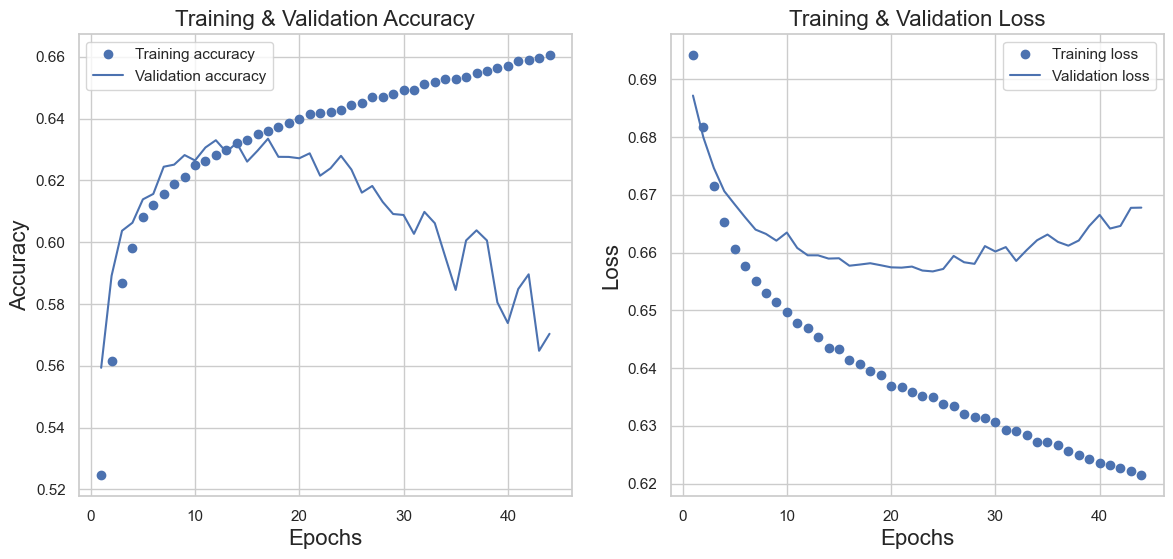

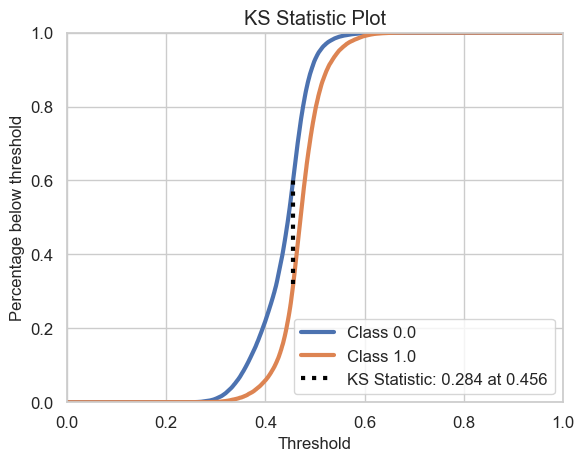

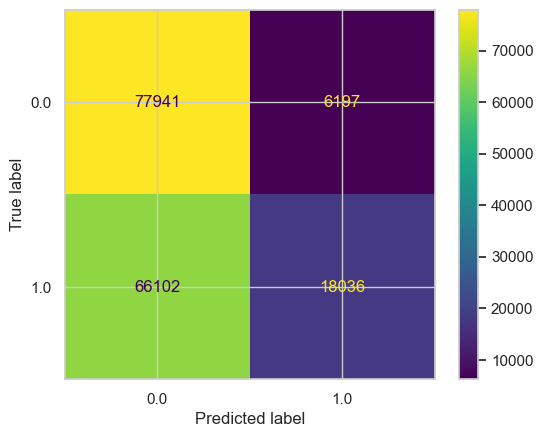


Accuracy:         0.5704
Recall:           0.2144
Precision:        0.7443
F1:               0.3329
AUROC:            0.6949
KS:               0.2840


In [124]:
testePlotTorchModel(mlp_opt, X_val, y_val.ravel(), mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies)

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

Gerando History Plot
Gerando análises para o modelo Network(
  (fc1): Linear(in_features=1376, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
  (dropout): Dropout(p=0.4, inplace=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
[0. 0. 1. ... 0. 1. 0.]
[0 0 0 ... 0 0 0]


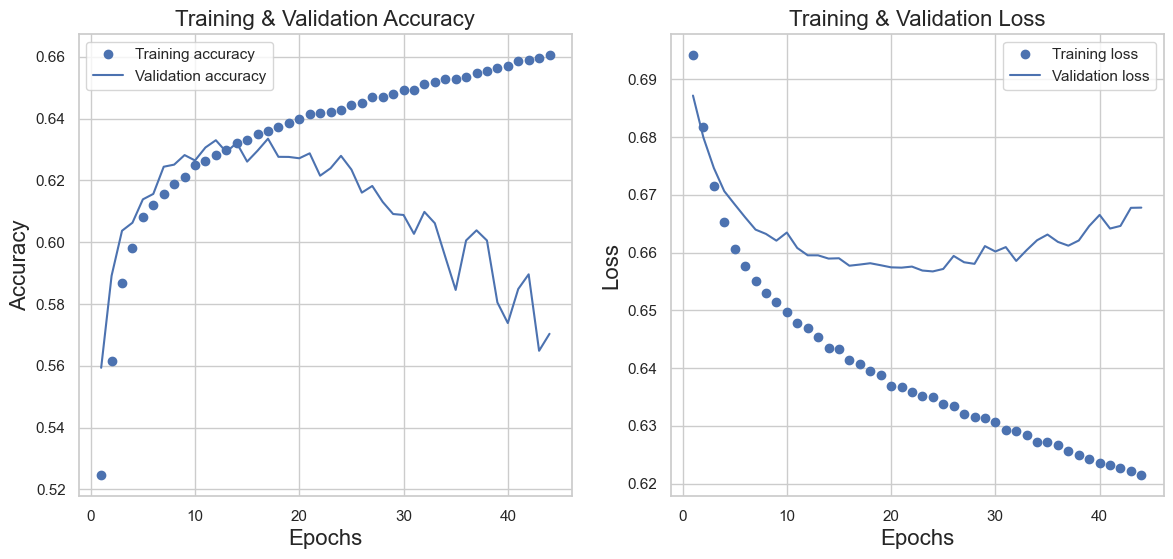

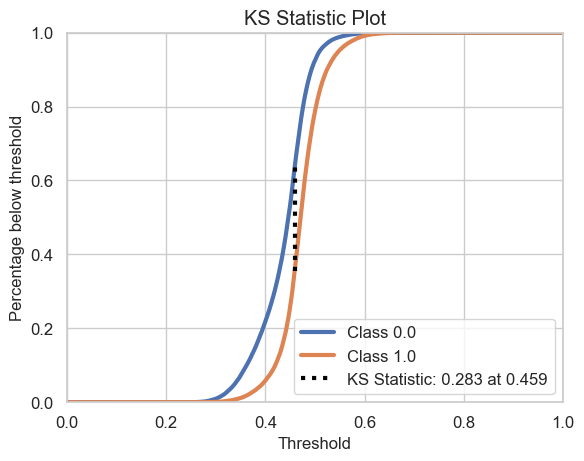

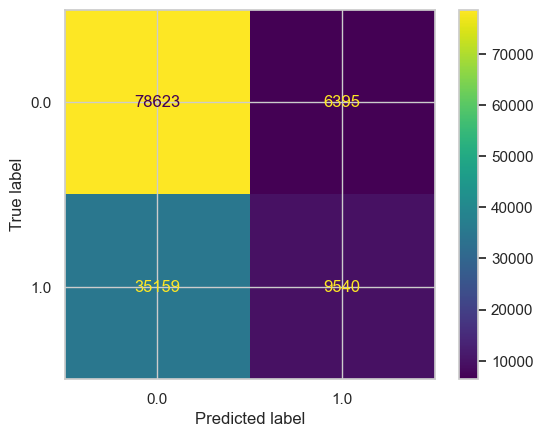


Accuracy:         0.6797
Recall:           0.2134
Precision:        0.5987
F1:               0.3147
AUROC:            0.6940
KS:               0.2830


In [125]:
testePlotTorchModel(mlp_opt, X_test, y_test.ravel(), mlp_train_losses, mlp_val_losses, mlp_train_accuracies, mlp_val_accuracies)

Salvamos os parâmetros do modelo - *state_dict* - em um diretório separado e criamos um aquivo ".JSON" , a fim registrar os hiper-parâmetros capturados.

In [126]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/mlp_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_mlp.best_params, json_file, indent=4)

# We save the trained model in order to save time
torch.save(mlp_opt.state_dict(), 'models/mlp_opt.pth')

# Caso já tenhamos o modelo e apenas queiramos carregá-lo
# mlp_opt = torch.load('models/mlp_opt_model.pth')

***O que difere essa análise das demais é a incorporação de Mecanismos de Atenção e da Arquitetura de Transformers.***

## Transformers e Atenção(Hooray!!)

### Dados (Tratamento para Mecanismos de Atenção)

Importamos os nossos dados que foram previamente separados em treino e teste (ainda será necessário um set de validação para o nosso estudo).
O motivo de termos que importar os dadoos em sua forma original novamente é em virtude do tratamento: Ao invés de aplicar uma normalização por MinMaxScaling, utilizamos o método StandardScaler, que é mais usual (em quesito histórico) ao se tratar de Redes Neurais.

In [127]:
df_train_transformer = pd.read_table('TRNcod.xls').drop(columns='INDEX')
df_test_transformer = pd.read_table('TST.cod').drop(columns='INDEX')

Removemos a coluna redundante.

In [128]:
df_train_transformer = df_train_transformer.drop(columns='IND_BOM_1_1')
df_test_transformer = df_test_transformer.drop(columns='IND_BOM_1_1')

Removemos duplicatas.

In [129]:
df_train_transformer = df_train_transformer.drop_duplicates()
df_test_transformer = df_test_transformer.drop_duplicates()

In [130]:
df_test_transformer

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_2
0,1,1,1,0,0,0,0,0.898745,1,0.111111,...,1,0,1,1,1,0,0,0,0,0
1,1,1,0,1,0,0,0,0.847404,1,0.111111,...,0,0,0,0,1,1,1,0,0,0
2,1,1,0,0,0,0,1,0.016513,0,0.111111,...,1,0,1,0,0,1,0,0,1,1
3,1,1,0,1,0,0,0,0.688950,0,0.111111,...,1,0,0,0,0,0,1,0,1,0
4,0,1,1,0,0,1,0,0.230114,1,0.111111,...,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129728,1,1,0,0,1,0,0,0.144526,1,0.111111,...,1,0,0,1,1,0,0,1,0,0
129729,1,0,1,0,0,1,0,0.118741,0,1.000000,...,0,1,1,1,0,0,0,1,1,0
129730,1,0,0,1,1,0,0,0.888636,0,0.111111,...,0,0,1,0,1,1,0,1,0,0
129731,1,1,0,0,1,0,0,0.082791,1,0.111111,...,0,1,0,0,1,1,0,0,0,1


#### Categorical

Especificamente para os modelos analisados a partir desse pontos, precisamos diferenciar bem entre as colunas categóricas e contínuas, visto que tal segmentação é utilizada de forma explícita de acordo com o funcionamento dos modelos. Contudo, diferentemente do que fizemos com a abordagem usual/anterior, não precisamos instanciar o OneHotEncoding() manualmente.

In [131]:
columns_train_categorical = get_categorical_columns(df_train_transformer)
columns_train_continuous = df_train_transformer.drop(columns=columns_train_categorical).columns

Temos as colunas categóricas:

In [132]:
print(columns_train_categorical)

['UF_1', 'UF_2', 'UF_3', 'UF_4', 'UF_5', 'UF_6', 'UF_7', 'SEXO_1', 'NIVEL_RELACIONAMENTO_CREDITO01', 'NIVEL_RELACIONAMENTO_CREDITO02', 'BANCO_REST_IRPF_ULTIMA_1', 'BANCO_REST_IRPF_ULTIMA_2', 'BANCO_REST_IRPF_ULTIMA_3', 'BANCO_REST_IRPF_ULTIMA_4', 'BANCO_REST_IRPF_ULTIMA_5', 'BANCO_REST_IRPF_ULTIMA_6', 'BANCO_REST_IRPF_ULTIMA_7', 'EXPOSICAO_ENDERECO', 'EXPOSICAO_EMAIL', 'EXPOSICAO_TELEFONE', 'EXPOSICAO_CONSUMIDOR_EMAILS', 'EXPOSICAO_CONSUMIDOR_TELEFONES', 'FLAG_BOLSA_FAMILIA_1', 'SIGLA_PARTIDO_FILIADO_1', 'SIGLA_PARTIDO_FILIADO_2', 'SIGLA_PARTIDO_FILIADO_3', 'SIGLA_PARTIDO_FILIADO_4', 'SIGLA_PARTIDO_FILIADO_5', 'SIGLA_PARTIDO_FILIADO_6', 'SIGLA_PARTIDO_FILIADO_7', 'FLAG_FILIADO_PARTIDO_POLITICO_1', 'FLAG_PROUNI_1', 'RENDA_VIZINHANCA_1', 'RENDA_VIZINHANCA_2', 'RENDA_VIZINHANCA_3', 'RENDA_VIZINHANCA_4', 'COMPARATIVO_RENDA_CEP_1', 'COMPARATIVO_RENDA_CEP_2', 'COMPARATIVO_RENDA_CEP_3', 'COMPARATIVO_RENDA_CEP_4', 'COMPARATIVO_RENDA_CEP_5', 'CLASSE_SOCIAL_CONSUMIDOR_1', 'CLASSE_SOCIAL_CONSUMID

Temos as colunas não categóricas:

In [133]:
print(columns_train_continuous)

Index(['IDADE', 'ATIVIDADE_EMAIL', 'ATIVIDADE_ENDERECO',
       'ATUALIZACAO_ENDERECO', 'ATUALIZACAO_EMAIL', 'ATIVIDADE_TELEFONE',
       'VALOR_PARCELA_BOLSA_FAMILIA', 'QUANTIDADE_VIZINHANCA',
       'CAD_DEMOGRAFICO_VAR_0', 'CAD_DEMOGRAFICO_VAR_1',
       ...
       'EXPOSICAO_ENDERECO_CORRETOR_SEGUROS', 'EXPOSICAO_ENDERECO_HOTEL',
       'EXPOSICAO_ENDERECO_CINEMAS', 'EXPOSICAO_ENDERECO_CASA_NOTURNA',
       'EXPOSICAO_ENDERECO_ESTACIONAMENTOS', 'EXPOSICAO_ENDERECO_ESCOLAS',
       'EXPOSICAO_ENDERECO_SHOPPING', 'EXPOSICAO_ENDERECO_PONTO_TAXI',
       'EXPOSICAO_ENDERECO_UNIVERSIDADE', 'EXPOSICAO_WEB'],
      dtype='object', length=123)


### Set de Treino e Validação.

Separamos os dados em set treino e validação em uma proporação de 70% para 30%, respectivamente (segmentando o target 'IND_BOM_1_2'). Como pretendemos fazer uma mistura dos dados Major e Minor, posteriormente, mantemos o target label no dataset X.

Fazemos uma separação das instâncias com valor do parâmetro analisado.

In [134]:
dfMinorTransformer = df_train_transformer[df_train_transformer['IND_BOM_1_2']==1]
dfMajorTransformer = df_train_transformer[df_train_transformer['IND_BOM_1_2']==0]

Seguimos com a serparação dos dados.

In [135]:
data_train_minor_transformer, data_val_minor_transformer, _, _ = train_test_split(dfMinorTransformer, dfMinorTransformer['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [136]:
print(data_train_minor_transformer.shape)

(89830, 244)


In [137]:
print(data_val_minor_transformer.shape)

(44246, 244)


In [138]:
data_train_major_transformer, data_val_major_transformer, _, _ = train_test_split(dfMajorTransformer, dfMajorTransformer['IND_BOM_1_2'], test_size=0.33, random_state=42)

In [139]:
print(data_train_major_transformer.shape)

(170825, 244)


In [140]:
print(data_val_major_transformer.shape)

(84138, 244)


### Oversampling

Visto que possuímos uma distribuição desigual de dados por classe, fazemos uma repopulação de instâncias de treino X_train_major até que a quantidade seja equivalente a X_train_minor (Fazemos uma concatenação simples).

In [141]:
difference_train_transformer = data_train_major_transformer.shape[0] - data_train_minor_transformer.shape[0]
difference_train_transformer

80995

In [142]:
data_train_minor_sampled_transformer = pd.concat([data_train_minor_transformer, data_train_minor_transformer[:difference_train_transformer]])

In [143]:
data_train_minor_sampled_transformer.shape

(170825, 244)

In [144]:
data_train_minor_sampled_transformer.shape == data_train_major_transformer.shape

True

In [145]:
difference_val_transformer = data_val_major_transformer.shape[0] - data_val_minor_transformer.shape[0]
difference_val_transformer

39892

In [146]:
data_val_minor_sampled_transformer = pd.concat([data_val_minor_transformer, data_val_minor_transformer[:difference_val_transformer]])

In [147]:
data_val_minor_sampled_transformer.shape

(84138, 244)

In [148]:
data_val_minor_sampled_transformer.shape == data_val_major_transformer.shape

True

### Concatenação e Randomização

A fim de termos os nossos dados balanceados, concatenamos os dados transformados anteriormente instituindo um grau de aleatóriedade nessa inserção.

In [149]:
data_train_transformer = pd.concat([data_train_minor_sampled_transformer, data_train_major_transformer]).sample(frac=1, random_state=42).reset_index(drop=True)

O nosso novo formato para os dados de treino:

In [150]:
data_train_transformer.shape

(341650, 244)

In [151]:
data_train_transformer.head(5)

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_2
0,0,1,1,0,0,1,0,0.842974,0,0.111111,...,1,1,1,1,0,1,0,0,1,0
1,1,0,0,1,0,1,0,0.782205,1,0.111111,...,0,0,1,0,0,1,1,0,0,0
2,1,1,0,0,0,1,0,0.086426,0,0.111111,...,0,0,0,0,1,1,0,0,1,0
3,1,1,1,0,0,0,0,0.174456,1,0.111111,...,0,0,1,0,0,0,1,0,1,1
4,1,0,0,0,1,0,1,0.468022,0,0.111111,...,1,1,1,0,0,1,0,0,0,0


In [152]:
data_val_transformer = pd.concat([data_val_minor_sampled_transformer, data_val_major_transformer]).sample(frac=1, random_state=42).reset_index(drop=True)

O nosso novo formato para os dados de teste:

In [153]:
data_val_transformer.shape

(168276, 244)

In [154]:
data_val_transformer.head(5)

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_6,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_2
0,1,0,0,0,1,1,0,0.049623,1,0.111111,...,1,0,1,0,0,0,0,1,0,1
1,1,0,1,0,1,0,0,0.431731,1,0.111111,...,0,0,1,1,0,0,1,1,0,0
2,1,0,1,0,0,1,0,0.210747,1,0.111111,...,0,1,0,1,1,1,0,1,0,0
3,1,0,0,1,1,0,0,0.295710,0,0.111111,...,0,0,0,1,0,0,1,0,1,1
4,1,1,0,1,0,0,0,0.146684,1,0.111111,...,0,0,0,1,0,1,0,0,0,1


In [155]:
# We only set this variable so the name is related to both train and validation
data_test_transformer = df_test_transformer.copy()

#### Normalização dos Dados (Standarziation)

Nossa normalização é feita com a abordagem Standarziation, em que, após a transformação, os dados devem ter uma média de zero e um desvio padrão de um.

In [156]:
def train_standardizer(df, continuous_columns):
    standardized_df = df.copy()
    scaler = StandardScaler()
    standardized_df[continuous_columns] = scaler.fit_transform(standardized_df[continuous_columns])
    return standardized_df, scaler

In [157]:
def apply_train_standardizer(df, scaler, continuous_columns):
    standardized_df = df.copy()
    standardized_df[continuous_columns] = scaler.transform(standardized_df[continuous_columns])
    return standardized_df

Aplicamos a nossa normalização (Standard Scaler) ao dataset.

In [158]:
data_train_transformer, std_scaler = train_standardizer(data_train_transformer, columns_train_continuous)
data_val_transformer = apply_train_standardizer(data_val_transformer, std_scaler, columns_train_continuous)

data_test_transformer = apply_train_standardizer(data_test_transformer, std_scaler, columns_train_continuous)

#### Preparação em termos dos modelos:

Nossa análise, a partir deste ponto, trabalha de forma que todos os dados estão em um único dataframe (o que difere da abordagem utilizada anteriormente), mas o funcionamento é o mesmo. Dessa forma, devemos nos ater dos indíces de treino, validação e teste.

In [159]:
if "Set" not in data_train_transformer.columns:
    data_train_transformer["Set"] = "train"
if "Set" not in data_val_transformer.columns:
    data_val_transformer["Set"] = "valid"
if "Set" not in data_test_transformer.columns:
    data_test_transformer["Set"] = "test"

C:\Users\User\AppData\Local\Temp\ipykernel_15512\1633876457.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_train_transformer["Set"] = "train"
C:\Users\User\AppData\Local\Temp\ipykernel_15512\1633876457.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_val_transformer["Set"] = "valid"
C:\Users\User\AppData\Local\Temp\ipykernel_15512\1633876457.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

In [160]:
data = pd.concat([data_train_transformer, data_val_transformer, data_test_transformer], ignore_index=True)
data = data.sample(frac=1).reset_index(drop=True)

Temos aqui todos os dados a serem analisados (já normalizados e sampleados).

In [161]:
data

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_2,Set
0,1,1,1,0,0,0,0,-0.234462,0,0.111111,...,0,0,0,0,1,0,1,1,0,valid
1,1,1,0,0,1,0,0,0.873635,1,0.111111,...,1,0,0,0,0,1,0,1,0,train
2,0,1,1,0,0,1,0,1.100003,0,0.111111,...,0,1,0,1,0,1,1,1,0,valid
3,1,0,0,0,0,1,1,1.148172,1,0.111111,...,0,1,0,0,1,0,0,0,0,train
4,1,1,1,0,0,0,0,-1.760018,0,0.111111,...,1,1,1,1,0,1,0,0,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639638,1,0,1,0,0,1,0,-0.626819,1,0.111111,...,1,0,0,1,1,0,0,1,0,train
639639,1,1,0,0,1,0,0,-1.709588,1,0.111111,...,1,0,1,0,0,1,1,0,0,train
639640,1,0,1,1,0,0,0,1.764409,1,0.111111,...,1,0,1,1,0,0,1,1,1,valid
639641,1,0,0,0,1,1,0,-0.997240,1,0.111111,...,1,0,1,0,0,1,0,1,0,train


Como comentado anteriormente, precisamos guardar o indíces dos novos tipos de dado (treino, validação e teste).

In [162]:
train_indices = data[data.Set=="train"].index
valid_indices = data[data.Set=="valid"].index
test_indices = data[data.Set=="test"].index

A célula a seguir consegue nos retornar as colunas categóricas dos nossos dados (todos os índices e tipos), bem como quantos valores diferentes (categorias) estão presentes em cada coluna.

In [163]:
nunique = data.nunique()
types = data.dtypes

categorical_columns = []
categorical_dims =  {}
for col in data.columns:
    if types[col] == 'object' or nunique[col] <= threshold:
        print(col, data[col].nunique())
        l_enc = LabelEncoder()
        data[col] = data[col].fillna("VV_likely")
        data[col] = l_enc.fit_transform(data[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        data.fillna(data.loc[train_indices, col].mean(), inplace=True)

UF_1 2
UF_2 2
UF_3 2
UF_4 2
UF_5 2
UF_6 2
UF_7 2
SEXO_1 2
NIVEL_RELACIONAMENTO_CREDITO01 10
NIVEL_RELACIONAMENTO_CREDITO02 3
BANCO_REST_IRPF_ULTIMA_1 2
BANCO_REST_IRPF_ULTIMA_2 2
BANCO_REST_IRPF_ULTIMA_3 2
BANCO_REST_IRPF_ULTIMA_4 2
BANCO_REST_IRPF_ULTIMA_5 2
BANCO_REST_IRPF_ULTIMA_6 2
BANCO_REST_IRPF_ULTIMA_7 2
EXPOSICAO_ENDERECO 73
EXPOSICAO_EMAIL 96
EXPOSICAO_TELEFONE 37
EXPOSICAO_CONSUMIDOR_EMAILS 6
EXPOSICAO_CONSUMIDOR_TELEFONES 11
FLAG_BOLSA_FAMILIA_1 2
SIGLA_PARTIDO_FILIADO_1 2
SIGLA_PARTIDO_FILIADO_2 2
SIGLA_PARTIDO_FILIADO_3 2
SIGLA_PARTIDO_FILIADO_4 2
SIGLA_PARTIDO_FILIADO_5 2
SIGLA_PARTIDO_FILIADO_6 2
SIGLA_PARTIDO_FILIADO_7 2
FLAG_FILIADO_PARTIDO_POLITICO_1 2
FLAG_PROUNI_1 2
RENDA_VIZINHANCA_1 2
RENDA_VIZINHANCA_2 2
RENDA_VIZINHANCA_3 2
RENDA_VIZINHANCA_4 2
COMPARATIVO_RENDA_CEP_1 2
COMPARATIVO_RENDA_CEP_2 2
COMPARATIVO_RENDA_CEP_3 2
COMPARATIVO_RENDA_CEP_4 2
COMPARATIVO_RENDA_CEP_5 2
CLASSE_SOCIAL_CONSUMIDOR_1 2
CLASSE_SOCIAL_CONSUMIDOR_2 2
CLASSE_SOCIAL_CONSUMIDOR_3 2
CLA

Para alimentarmos os nossos dados, utilizamos os índices correspondentes às features categóricas e conntínuas (de forma explícita). Identificamos também a nossa variável *"target"*.

In [164]:
unused_feat = ['Set']
target = 'IND_BOM_1_2'

features = [ col for col in data.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

A célula a seguir apenas auxilia na detecção de GPU para determinados sistemas.

In [165]:
os.environ['CUDA_VISIBLE_DEVICES'] = f"1"

In [166]:
X_train = data[features].values[train_indices]
y_train = data[target].values[train_indices]

X_valid = data[features].values[valid_indices]
y_valid = data[target].values[valid_indices]

X_test = data[features].values[test_indices]
y_test = data[target].values[test_indices]

O tratamento de dados em questão é relativo ao modelo TabNet, que será explicado em seguida. Posteriormente, os demais modelos analisados contém apenas leves variações desse tratamento.

#### TabNet

TabNet é um algoritmo de aprendizado de máquina que incorpora mecanismos de atenção na sua abordagem.

In [167]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

Instanciamos a métrica de avaliação (KS Statistic) em um formato aceito pela implementação escolhida do modelo TabNet. 

In [168]:
class KS(Metric):
    def __init__(self):
        self._name = "ks"
        self._maximize = True

    def __call__(self, y_true, y_score):
        y_pred_score_positive = y_score[:,1]
        ks = ks_results(reshape_plot(y_true, y_pred_score_positive)[0], reshape_plot(y_true, y_pred_score_positive)[1])
        return ks

Para um modelo padrão (sem modificações), temos a seguinte configuração:

In [169]:
# Default Config
clf = TabNetClassifier()
clf

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

Vale ressaltar que no TabNet, existem dois conjuntos diferentes de hiperparâmetros usados para configurar o modelo: um conjunto relacionado ao número de características e suas dimensões, e outro conjunto relacionado à arquitetura do modelo e ao treinamento.

#### TabNet (With Optuna)

Definimos a função objetivo do nosso estudo:

In [170]:
# Define the objective function
def objective_tabnet(trial):
    
    # Suggest values for the hyperparameters
    # n_d = trial.suggest_int('n_d', 8, 32)
    # n_a = trial.suggest_int('n_a', 8, 32)
    n_d_and_n_a = trial.suggest_int('n_d_and_n_a', 8, 64)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 0, 0.001)
    n_independent = trial.suggest_int('n_independent', 1, 5)
    n_shared = trial.suggest_int('n_shared', 1, 5)
    cat_emb_dim = trial.suggest_int('cat_emb_dim', 1, 64)
    
    
    # Create the TabNet classifier
    # model = TabNetClassifier(
    #     n_d=n_d,
    #     n_a=n_a,
    #     n_steps=n_steps,
    #     gamma=gamma,
    #     lambda_sparse=lambda_sparse,
    # )
    
    model = TabNetClassifier(
        # related to the number of features and their dimensions
        n_independent=n_independent,  # Number of independent features in each step
        n_shared=n_shared,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        cat_emb_dim=cat_emb_dim,
        ###
        # related to the model architecture and training
        # According to the paper n_d=n_a is usually a good choice.
        # n_d=n_d,
        # n_a=n_a,
        n_d=n_d_and_n_a,
        n_a=n_d_and_n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        #
        scheduler_params={"step_size":10, # how to use learning rate scheduler
                          "gamma":0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
    )
    
    # Fit the model
    model.fit(
      X_train, y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric=["auc", KS],
      max_epochs=1000 , patience=20,
      batch_size=512, virtual_batch_size=128,
      num_workers=0,
      weights=1,
      drop_last=False
    )

    y_pred = model.predict(X_valid)
    y_pred_score_positive = model.predict_proba(X_valid)[:,1]
    """
    if((not np.any(y_pred)) or np.all(y_pred)):
        ks = 0
    else:
    """
    ks = ks_results(reshape_plot(y_valid, y_pred_score_positive)[0], reshape_plot(y_valid, y_pred_score_positive)[1])

    trial.set_user_attr('roc_auc', roc_auc_score(y_valid, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_valid, y_pred))
    trial.set_user_attr('precision', precision_score(y_valid, y_pred))
    trial.set_user_attr('recall', recall_score(y_valid, y_pred))
    trial.set_user_attr('f1', f1_score(y_valid, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_valid, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_valid, y_pred), step=3)
    trial.report(precision_score(y_valid, y_pred), step=4)
    trial.report(recall_score(y_valid, y_pred), step=5)
    trial.report(f1_score(y_valid, y_pred), step=6)

    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo, e não apenas os melhores parâmetros. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [171]:
def callback_tabnet(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Iniciamos o nosso estudo:

In [172]:
# Measure the start time
start_time_tabnet = time.time()

study_tabnet = optuna.create_study(direction='maximize')

study_tabnet.optimize(objective_tabnet, n_trials=n_trials, callbacks=[callback_tabnet])

print('Number of finished trials:', len(study_tabnet.trials))
print('Best trial:', study_tabnet.best_trial.params)

# Measure the end time
end_time_tabnet = time.time()

# Calculate the duration in seconds
duration_tabnet = end_time_tabnet - start_time_tabnet

[I 2023-09-12 18:34:40,970] A new study created in memory with name: no-name-6d772b13-2e5c-4e41-948a-2b2bb393c0ac


epoch 0  | loss: 0.77383 | train_auc: 0.50451 | train_ks: 0.02198 | valid_auc: 0.5065  | valid_ks: 0.02489 |  0:07:10s
epoch 1  | loss: 0.69135 | train_auc: 0.55582 | train_ks: 0.08396 | valid_auc: 0.55654 | valid_ks: 0.08712 |  0:14:27s
epoch 2  | loss: 0.68235 | train_auc: 0.63595 | train_ks: 0.19939 | valid_auc: 0.6359  | valid_ks: 0.20229 |  0:21:45s
epoch 3  | loss: 0.65588 | train_auc: 0.67305 | train_ks: 0.25605 | valid_auc: 0.67199 | valid_ks: 0.25603 |  0:29:04s
epoch 4  | loss: 0.64013 | train_auc: 0.68234 | train_ks: 0.27623 | valid_auc: 0.67969 | valid_ks: 0.27278 |  0:36:22s
epoch 5  | loss: 0.6318  | train_auc: 0.69549 | train_ks: 0.28849 | valid_auc: 0.6885  | valid_ks: 0.27892 |  0:43:38s
epoch 6  | loss: 0.62875 | train_auc: 0.70745 | train_ks: 0.30147 | valid_auc: 0.69796 | valid_ks: 0.28782 |  0:50:57s
epoch 7  | loss: 0.62285 | train_auc: 0.71635 | train_ks: 0.31216 | valid_auc: 0.69768 | valid_ks: 0.28582 |  0:58:14s
epoch 8  | loss: 0.61647 | train_auc: 0.72431 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-12 22:18:37,860] Trial 0 finished with value: 0.2878247640780622 and parameters: {'n_d_and_n_a': 22, 'n_steps': 10, 'gamma': 1.2970009588544458, 'lambda_sparse': 0.00035525736425054454, 'n_independent': 5, 'n_shared': 4, 'cat_emb_dim': 54}. Best is trial 0 with value: 0.2878247640780622.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69875 | train_auc: 0.61183 | train_ks: 0.17035 | valid_auc: 0.61197 | valid_ks: 0.17029 |  0:04:16s
epoch 1  | loss: 0.67524 | train_auc: 0.6028  | train_ks: 0.17082 | valid_auc: 0.60382 | valid_ks: 0.1708  |  0:08:33s
epoch 2  | loss: 0.67553 | train_auc: 0.6015  | train_ks: 0.16737 | valid_auc: 0.59998 | valid_ks: 0.16771 |  0:12:51s
epoch 3  | loss: 0.67542 | train_auc: 0.61581 | train_ks: 0.17922 | valid_auc: 0.61785 | valid_ks: 0.18275 |  0:17:09s
epoch 4  | loss: 0.6728  | train_auc: 0.62028 | train_ks: 0.18025 | valid_auc: 0.61911 | valid_ks: 0.17608 |  0:21:25s
epoch 5  | loss: 0.67334 | train_auc: 0.61832 | train_ks: 0.17195 | valid_auc: 0.61964 | valid_ks: 0.17363 |  0:25:42s
epoch 6  | loss: 0.67131 | train_auc: 0.62256 | train_ks: 0.18274 | valid_auc: 0.62334 | valid_ks: 0.18612 |  0:29:59s
epoch 7  | loss: 0.67095 | train_auc: 0.62113 | train_ks: 0.17796 | valid_auc: 0.62176 | valid_ks: 0.17748 |  0:34:17s
epoch 8  | loss: 0.66934 | train_auc: 0.62491 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 01:04:07,758] Trial 1 finished with value: 0.19533385628372435 and parameters: {'n_d_and_n_a': 40, 'n_steps': 7, 'gamma': 1.0117261664584412, 'lambda_sparse': 0.0006760426725616035, 'n_independent': 2, 'n_shared': 2, 'cat_emb_dim': 58}. Best is trial 0 with value: 0.2878247640780622.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68308 | train_auc: 0.64884 | train_ks: 0.21187 | valid_auc: 0.64883 | valid_ks: 0.21189 |  0:03:09s
epoch 1  | loss: 0.6474  | train_auc: 0.68732 | train_ks: 0.27225 | valid_auc: 0.68494 | valid_ks: 0.27023 |  0:06:22s
epoch 2  | loss: 0.63442 | train_auc: 0.69958 | train_ks: 0.29191 | valid_auc: 0.69333 | valid_ks: 0.28176 |  0:09:34s
epoch 3  | loss: 0.62844 | train_auc: 0.70759 | train_ks: 0.30081 | valid_auc: 0.69589 | valid_ks: 0.28394 |  0:12:45s
epoch 4  | loss: 0.62281 | train_auc: 0.71462 | train_ks: 0.31181 | valid_auc: 0.69391 | valid_ks: 0.28208 |  0:15:56s
epoch 5  | loss: 0.61798 | train_auc: 0.7234  | train_ks: 0.32575 | valid_auc: 0.69332 | valid_ks: 0.2816  |  0:19:13s
epoch 6  | loss: 0.61381 | train_auc: 0.73335 | train_ks: 0.34361 | valid_auc: 0.69015 | valid_ks: 0.28069 |  0:22:24s
epoch 7  | loss: 0.60545 | train_auc: 0.74148 | train_ks: 0.35827 | valid_auc: 0.68509 | valid_ks: 0.26959 |  0:25:36s
epoch 8  | loss: 0.59855 | train_auc: 0.75046 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 02:27:16,971] Trial 2 finished with value: 0.2839382918538591 and parameters: {'n_d_and_n_a': 15, 'n_steps': 4, 'gamma': 1.0896009852622646, 'lambda_sparse': 9.180078715128825e-05, 'n_independent': 4, 'n_shared': 3, 'cat_emb_dim': 14}. Best is trial 0 with value: 0.2878247640780622.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68146 | train_auc: 0.65992 | train_ks: 0.23663 | valid_auc: 0.66003 | valid_ks: 0.23842 |  0:02:59s
epoch 1  | loss: 0.64271 | train_auc: 0.69368 | train_ks: 0.28137 | valid_auc: 0.6908  | valid_ks: 0.27682 |  0:05:59s
epoch 2  | loss: 0.63072 | train_auc: 0.70612 | train_ks: 0.30088 | valid_auc: 0.69547 | valid_ks: 0.28527 |  0:09:00s
epoch 3  | loss: 0.62578 | train_auc: 0.71248 | train_ks: 0.3108  | valid_auc: 0.69419 | valid_ks: 0.284   |  0:12:02s
epoch 4  | loss: 0.61968 | train_auc: 0.72261 | train_ks: 0.32587 | valid_auc: 0.69104 | valid_ks: 0.28106 |  0:15:03s
epoch 5  | loss: 0.61111 | train_auc: 0.73179 | train_ks: 0.34206 | valid_auc: 0.6858  | valid_ks: 0.27608 |  0:18:04s
epoch 6  | loss: 0.60538 | train_auc: 0.74108 | train_ks: 0.35474 | valid_auc: 0.68145 | valid_ks: 0.26516 |  0:21:06s
epoch 7  | loss: 0.59409 | train_auc: 0.76002 | train_ks: 0.38555 | valid_auc: 0.67688 | valid_ks: 0.25896 |  0:24:09s
epoch 8  | loss: 0.5838  | train_auc: 0.77256 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 03:42:25,613] Trial 3 finished with value: 0.285269438303739 and parameters: {'n_d_and_n_a': 28, 'n_steps': 3, 'gamma': 1.2184994000373597, 'lambda_sparse': 0.0007781288388302586, 'n_independent': 3, 'n_shared': 4, 'cat_emb_dim': 37}. Best is trial 0 with value: 0.2878247640780622.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70168 | train_auc: 0.58731 | train_ks: 0.12198 | valid_auc: 0.58953 | valid_ks: 0.12768 |  0:04:03s
epoch 1  | loss: 0.67592 | train_auc: 0.61302 | train_ks: 0.17053 | valid_auc: 0.61311 | valid_ks: 0.17076 |  0:08:10s
epoch 2  | loss: 0.67377 | train_auc: 0.61498 | train_ks: 0.18582 | valid_auc: 0.61302 | valid_ks: 0.18501 |  0:12:17s
epoch 3  | loss: 0.67334 | train_auc: 0.62081 | train_ks: 0.19365 | valid_auc: 0.62016 | valid_ks: 0.18852 |  0:16:23s
epoch 4  | loss: 0.67552 | train_auc: 0.6091  | train_ks: 0.16416 | valid_auc: 0.60906 | valid_ks: 0.16549 |  0:20:29s
epoch 5  | loss: 0.67312 | train_auc: 0.62731 | train_ks: 0.19327 | valid_auc: 0.62701 | valid_ks: 0.19419 |  0:24:36s
epoch 6  | loss: 0.66398 | train_auc: 0.65569 | train_ks: 0.23342 | valid_auc: 0.65504 | valid_ks: 0.23337 |  0:28:42s
epoch 7  | loss: 0.65388 | train_auc: 0.65337 | train_ks: 0.23097 | valid_auc: 0.6528  | valid_ks: 0.2342  |  0:32:47s
epoch 8  | loss: 0.64731 | train_auc: 0.68157 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 06:07:22,854] Trial 4 finished with value: 0.2905345979224608 and parameters: {'n_d_and_n_a': 45, 'n_steps': 6, 'gamma': 1.4689988771395135, 'lambda_sparse': 0.0005258821333525833, 'n_independent': 4, 'n_shared': 1, 'cat_emb_dim': 10}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.71731 | train_auc: 0.56116 | train_ks: 0.09468 | valid_auc: 0.56058 | valid_ks: 0.09436 |  0:06:20s
epoch 1  | loss: 0.68644 | train_auc: 0.56173 | train_ks: 0.10292 | valid_auc: 0.56298 | valid_ks: 0.10011 |  0:12:38s
epoch 2  | loss: 0.6775  | train_auc: 0.60177 | train_ks: 0.1611  | valid_auc: 0.6035  | valid_ks: 0.1632  |  0:18:57s
epoch 3  | loss: 0.67818 | train_auc: 0.52008 | train_ks: 0.03333 | valid_auc: 0.52232 | valid_ks: 0.03833 |  0:25:17s
epoch 4  | loss: 0.67591 | train_auc: 0.58915 | train_ks: 0.13078 | valid_auc: 0.58747 | valid_ks: 0.12862 |  0:31:34s
epoch 5  | loss: 0.67699 | train_auc: 0.60473 | train_ks: 0.16415 | valid_auc: 0.60425 | valid_ks: 0.16497 |  0:37:52s
epoch 6  | loss: 0.67187 | train_auc: 0.61826 | train_ks: 0.17329 | valid_auc: 0.61998 | valid_ks: 0.1745  |  0:44:18s
epoch 7  | loss: 0.66957 | train_auc: 0.62197 | train_ks: 0.17838 | valid_auc: 0.62274 | valid_ks: 0.18095 |  0:50:37s
epoch 8  | loss: 0.66923 | train_auc: 0.62558 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 11:02:16,612] Trial 5 finished with value: 0.28575673298628446 and parameters: {'n_d_and_n_a': 26, 'n_steps': 7, 'gamma': 1.6634476559683185, 'lambda_sparse': 0.0008946307229433822, 'n_independent': 5, 'n_shared': 5, 'cat_emb_dim': 59}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69684 | train_auc: 0.58924 | train_ks: 0.13327 | valid_auc: 0.5905  | valid_ks: 0.13881 |  0:03:43s
epoch 1  | loss: 0.68061 | train_auc: 0.60033 | train_ks: 0.15557 | valid_auc: 0.60439 | valid_ks: 0.15904 |  0:07:34s
epoch 2  | loss: 0.67421 | train_auc: 0.6201  | train_ks: 0.1742  | valid_auc: 0.62366 | valid_ks: 0.18133 |  0:11:20s
epoch 3  | loss: 0.66533 | train_auc: 0.64208 | train_ks: 0.20554 | valid_auc: 0.64409 | valid_ks: 0.21023 |  0:15:04s
epoch 4  | loss: 0.64875 | train_auc: 0.68629 | train_ks: 0.27235 | valid_auc: 0.68247 | valid_ks: 0.26524 |  0:18:50s
epoch 5  | loss: 0.65326 | train_auc: 0.66079 | train_ks: 0.2304  | valid_auc: 0.66073 | valid_ks: 0.22993 |  0:22:35s
epoch 6  | loss: 0.64245 | train_auc: 0.66329 | train_ks: 0.27948 | valid_auc: 0.66064 | valid_ks: 0.27655 |  0:26:18s
epoch 7  | loss: 0.629   | train_auc: 0.70349 | train_ks: 0.29379 | valid_auc: 0.69467 | valid_ks: 0.28264 |  0:30:04s
epoch 8  | loss: 0.62856 | train_auc: 0.65072 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 13:09:41,217] Trial 6 finished with value: 0.28824074734364974 and parameters: {'n_d_and_n_a': 41, 'n_steps': 4, 'gamma': 1.4441490161059665, 'lambda_sparse': 0.00019103800375252112, 'n_independent': 4, 'n_shared': 3, 'cat_emb_dim': 43}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78055 | train_auc: 0.58731 | train_ks: 0.13671 | valid_auc: 0.58725 | valid_ks: 0.13494 |  0:10:25s
epoch 1  | loss: 0.6781  | train_auc: 0.61067 | train_ks: 0.15526 | valid_auc: 0.61177 | valid_ks: 0.15388 |  0:21:11s
epoch 2  | loss: 0.67336 | train_auc: 0.61819 | train_ks: 0.18134 | valid_auc: 0.61855 | valid_ks: 0.17974 |  0:31:40s
epoch 3  | loss: 0.67294 | train_auc: 0.61312 | train_ks: 0.16876 | valid_auc: 0.61397 | valid_ks: 0.17041 |  0:42:27s
epoch 4  | loss: 0.67197 | train_auc: 0.62112 | train_ks: 0.18735 | valid_auc: 0.62215 | valid_ks: 0.19069 |  0:53:13s
epoch 5  | loss: 0.66994 | train_auc: 0.62621 | train_ks: 0.1942  | valid_auc: 0.62714 | valid_ks: 0.19636 |  1:03:49s
epoch 6  | loss: 0.66928 | train_auc: 0.62698 | train_ks: 0.19972 | valid_auc: 0.62748 | valid_ks: 0.19797 |  1:14:33s
epoch 7  | loss: 0.66933 | train_auc: 0.65609 | train_ks: 0.25137 | valid_auc: 0.65604 | valid_ks: 0.25162 |  1:25:14s
epoch 8  | loss: 0.64782 | train_auc: 0.68184 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 19:20:04,738] Trial 7 finished with value: 0.2885854191922793 and parameters: {'n_d_and_n_a': 25, 'n_steps': 10, 'gamma': 1.1779375957278335, 'lambda_sparse': 0.000519553701914589, 'n_independent': 4, 'n_shared': 4, 'cat_emb_dim': 63}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.6918  | train_auc: 0.58926 | train_ks: 0.13836 | valid_auc: 0.59004 | valid_ks: 0.13824 |  0:02:23s
epoch 1  | loss: 0.68096 | train_auc: 0.60631 | train_ks: 0.15686 | valid_auc: 0.60806 | valid_ks: 0.16011 |  0:04:46s
epoch 2  | loss: 0.67448 | train_auc: 0.6172  | train_ks: 0.18239 | valid_auc: 0.61866 | valid_ks: 0.18422 |  0:07:09s
epoch 3  | loss: 0.67189 | train_auc: 0.62278 | train_ks: 0.18966 | valid_auc: 0.62511 | valid_ks: 0.19363 |  0:09:34s
epoch 4  | loss: 0.67141 | train_auc: 0.62301 | train_ks: 0.18508 | valid_auc: 0.62495 | valid_ks: 0.18823 |  0:11:58s
epoch 5  | loss: 0.67092 | train_auc: 0.62797 | train_ks: 0.19914 | valid_auc: 0.6275  | valid_ks: 0.19864 |  0:14:21s
epoch 6  | loss: 0.66424 | train_auc: 0.64551 | train_ks: 0.21771 | valid_auc: 0.64479 | valid_ks: 0.21669 |  0:16:44s
epoch 7  | loss: 0.65956 | train_auc: 0.64696 | train_ks: 0.21845 | valid_auc: 0.64409 | valid_ks: 0.21317 |  0:19:08s
epoch 8  | loss: 0.65284 | train_auc: 0.65914 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 20:51:31,256] Trial 8 finished with value: 0.2868739451852908 and parameters: {'n_d_and_n_a': 13, 'n_steps': 4, 'gamma': 1.614617288434722, 'lambda_sparse': 0.0007906608472487217, 'n_independent': 1, 'n_shared': 1, 'cat_emb_dim': 48}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70855 | train_auc: 0.59811 | train_ks: 0.1473  | valid_auc: 0.60162 | valid_ks: 0.15208 |  0:03:38s
epoch 1  | loss: 0.6716  | train_auc: 0.62646 | train_ks: 0.18988 | valid_auc: 0.62879 | valid_ks: 0.1941  |  0:07:24s
epoch 2  | loss: 0.66015 | train_auc: 0.65717 | train_ks: 0.22696 | valid_auc: 0.65733 | valid_ks: 0.22785 |  0:11:12s
epoch 3  | loss: 0.64844 | train_auc: 0.66734 | train_ks: 0.25287 | valid_auc: 0.66779 | valid_ks: 0.2539  |  0:14:59s
epoch 4  | loss: 0.64699 | train_auc: 0.66505 | train_ks: 0.25164 | valid_auc: 0.66388 | valid_ks: 0.25093 |  0:18:47s
epoch 5  | loss: 0.64832 | train_auc: 0.68188 | train_ks: 0.27231 | valid_auc: 0.67929 | valid_ks: 0.26574 |  0:22:34s
epoch 6  | loss: 0.63486 | train_auc: 0.69648 | train_ks: 0.29272 | valid_auc: 0.68958 | valid_ks: 0.28153 |  0:26:21s
epoch 7  | loss: 0.63844 | train_auc: 0.69565 | train_ks: 0.2834  | valid_auc: 0.68896 | valid_ks: 0.27145 |  0:30:08s
epoch 8  | loss: 0.62902 | train_auc: 0.70898 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-13 22:50:41,566] Trial 9 finished with value: 0.2855546839715705 and parameters: {'n_d_and_n_a': 43, 'n_steps': 6, 'gamma': 1.2349418093866897, 'lambda_sparse': 0.0002043598790768717, 'n_independent': 4, 'n_shared': 1, 'cat_emb_dim': 18}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77402 | train_auc: 0.58122 | train_ks: 0.11888 | valid_auc: 0.58312 | valid_ks: 0.11922 |  0:04:57s
epoch 1  | loss: 0.67985 | train_auc: 0.60593 | train_ks: 0.17156 | valid_auc: 0.6067  | valid_ks: 0.17327 |  0:09:50s
epoch 2  | loss: 0.67803 | train_auc: 0.59459 | train_ks: 0.15124 | valid_auc: 0.59611 | valid_ks: 0.15618 |  0:14:47s
epoch 3  | loss: 0.67931 | train_auc: 0.61005 | train_ks: 0.17005 | valid_auc: 0.60891 | valid_ks: 0.1679  |  0:19:44s
epoch 4  | loss: 0.67436 | train_auc: 0.61854 | train_ks: 0.17819 | valid_auc: 0.61813 | valid_ks: 0.17941 |  0:24:42s
epoch 5  | loss: 0.6691  | train_auc: 0.5922  | train_ks: 0.13889 | valid_auc: 0.5928  | valid_ks: 0.13965 |  0:29:35s
epoch 6  | loss: 0.66981 | train_auc: 0.60579 | train_ks: 0.1749  | valid_auc: 0.6047  | valid_ks: 0.1716  |  0:34:29s
epoch 7  | loss: 0.66168 | train_auc: 0.64431 | train_ks: 0.23355 | valid_auc: 0.64287 | valid_ks: 0.23036 |  0:39:22s
epoch 8  | loss: 0.65704 | train_auc: 0.65451 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-14 02:09:17,467] Trial 10 finished with value: 0.28639853573890506 and parameters: {'n_d_and_n_a': 59, 'n_steps': 8, 'gamma': 1.909368388179294, 'lambda_sparse': 0.00044147794306543934, 'n_independent': 2, 'n_shared': 2, 'cat_emb_dim': 7}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80324 | train_auc: 0.59988 | train_ks: 0.15902 | valid_auc: 0.60008 | valid_ks: 0.16058 |  0:07:29s
epoch 1  | loss: 0.68081 | train_auc: 0.60076 | train_ks: 0.15976 | valid_auc: 0.60322 | valid_ks: 0.16106 |  0:14:59s
epoch 2  | loss: 0.67291 | train_auc: 0.62746 | train_ks: 0.19093 | valid_auc: 0.6286  | valid_ks: 0.19347 |  0:22:31s
epoch 3  | loss: 0.66283 | train_auc: 0.6588  | train_ks: 0.2351  | valid_auc: 0.65877 | valid_ks: 0.23886 |  0:29:55s
epoch 4  | loss: 0.64853 | train_auc: 0.61453 | train_ks: 0.163   | valid_auc: 0.61687 | valid_ks: 0.16745 |  0:37:21s
epoch 5  | loss: 0.67527 | train_auc: 0.61364 | train_ks: 0.17233 | valid_auc: 0.61581 | valid_ks: 0.17111 |  0:44:48s
epoch 6  | loss: 0.66601 | train_auc: 0.59827 | train_ks: 0.14673 | valid_auc: 0.60016 | valid_ks: 0.14833 |  0:52:17s
epoch 7  | loss: 0.67361 | train_auc: 0.58637 | train_ks: 0.12965 | valid_auc: 0.58839 | valid_ks: 0.13509 |  0:59:46s
epoch 8  | loss: 0.66982 | train_auc: 0.62454 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-14 06:38:57,399] Trial 11 finished with value: 0.28418788181321164 and parameters: {'n_d_and_n_a': 52, 'n_steps': 10, 'gamma': 1.449887509135354, 'lambda_sparse': 0.0005887730197219652, 'n_independent': 3, 'n_shared': 5, 'cat_emb_dim': 26}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7299  | train_auc: 0.53093 | train_ks: 0.04704 | valid_auc: 0.53241 | valid_ks: 0.05027 |  0:05:58s
epoch 1  | loss: 0.68817 | train_auc: 0.56143 | train_ks: 0.10176 | valid_auc: 0.5671  | valid_ks: 0.11195 |  0:11:57s
epoch 2  | loss: 0.68472 | train_auc: 0.59758 | train_ks: 0.15759 | valid_auc: 0.60232 | valid_ks: 0.1652  |  0:18:00s
epoch 3  | loss: 0.6641  | train_auc: 0.65552 | train_ks: 0.23019 | valid_auc: 0.65787 | valid_ks: 0.23372 |  0:24:01s
epoch 4  | loss: 0.65194 | train_auc: 0.6745  | train_ks: 0.26436 | valid_auc: 0.67364 | valid_ks: 0.26511 |  0:30:02s
epoch 5  | loss: 0.63945 | train_auc: 0.69524 | train_ks: 0.2859  | valid_auc: 0.6928  | valid_ks: 0.2832  |  0:36:03s
epoch 6  | loss: 0.63083 | train_auc: 0.70315 | train_ks: 0.29631 | valid_auc: 0.69692 | valid_ks: 0.28898 |  0:42:07s
epoch 7  | loss: 0.62532 | train_auc: 0.70815 | train_ks: 0.30665 | valid_auc: 0.69637 | valid_ks: 0.28933 |  0:48:06s
epoch 8  | loss: 0.62316 | train_auc: 0.71409 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-14 09:39:28,629] Trial 12 finished with value: 0.2893341890703368 and parameters: {'n_d_and_n_a': 31, 'n_steps': 9, 'gamma': 1.3592885476262004, 'lambda_sparse': 0.0005223487712508791, 'n_independent': 4, 'n_shared': 4, 'cat_emb_dim': 1}. Best is trial 4 with value: 0.2905345979224608.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.73053 | train_auc: 0.56656 | train_ks: 0.11393 | valid_auc: 0.56776 | valid_ks: 0.11533 |  0:05:13s
epoch 1  | loss: 0.679   | train_auc: 0.63304 | train_ks: 0.19963 | valid_auc: 0.63355 | valid_ks: 0.19943 |  0:10:30s
epoch 2  | loss: 0.66055 | train_auc: 0.66008 | train_ks: 0.23813 | valid_auc: 0.66031 | valid_ks: 0.23765 |  0:15:44s
epoch 3  | loss: 0.65197 | train_auc: 0.64565 | train_ks: 0.20111 | valid_auc: 0.64616 | valid_ks: 0.20315 |  0:21:02s
epoch 4  | loss: 0.65539 | train_auc: 0.66961 | train_ks: 0.24354 | valid_auc: 0.67099 | valid_ks: 0.24447 |  0:26:20s
epoch 5  | loss: 0.64742 | train_auc: 0.67004 | train_ks: 0.2429  | valid_auc: 0.67089 | valid_ks: 0.24525 |  0:31:39s
epoch 6  | loss: 0.6425  | train_auc: 0.68501 | train_ks: 0.26852 | valid_auc: 0.68472 | valid_ks: 0.27004 |  0:36:53s
epoch 7  | loss: 0.64001 | train_auc: 0.69084 | train_ks: 0.2771  | valid_auc: 0.68994 | valid_ks: 0.27542 |  0:42:05s
epoch 8  | loss: 0.63324 | train_auc: 0.69403 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-14 12:34:05,781] Trial 13 finished with value: 0.2919964819700967 and parameters: {'n_d_and_n_a': 50, 'n_steps': 8, 'gamma': 1.3705784322652872, 'lambda_sparse': 0.0003731751674178888, 'n_independent': 5, 'n_shared': 2, 'cat_emb_dim': 1}. Best is trial 13 with value: 0.2919964819700967.
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69626 | train_auc: 0.62018 | train_ks: 0.18757 | valid_auc: 0.62174 | valid_ks: 0.19208 |  0:04:24s
epoch 1  | loss: 0.66626 | train_auc: 0.62208 | train_ks: 0.1791  | valid_auc: 0.62284 | valid_ks: 0.18213 |  0:08:53s
epoch 2  | loss: 0.6643  | train_auc: 0.64376 | train_ks: 0.21701 | valid_auc: 0.64487 | valid_ks: 0.21971 |  0:13:22s
epoch 3  | loss: 0.65983 | train_auc: 0.65037 | train_ks: 0.23176 | valid_auc: 0.65063 | valid_ks: 0.2339  |  0:17:52s
epoch 4  | loss: 0.65544 | train_auc: 0.66224 | train_ks: 0.24203 | valid_auc: 0.66446 | valid_ks: 0.24517 |  0:22:24s
epoch 5  | loss: 0.65056 | train_auc: 0.67302 | train_ks: 0.2555  | valid_auc: 0.67324 | valid_ks: 0.25762 |  0:26:54s
epoch 6  | loss: 0.64226 | train_auc: 0.69279 | train_ks: 0.28595 | valid_auc: 0.69142 | valid_ks: 0.28309 |  0:31:22s
epoch 7  | loss: 0.63335 | train_auc: 0.6285  | train_ks: 0.19299 | valid_auc: 0.62933 | valid_ks: 0.19476 |  0:35:52s
epoch 8  | loss: 0.65614 | train_auc: 0.66233 | 

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2023-09-14 15:05:53,205] Trial 14 finished with value: 0.292685825667356 and parameters: {'n_d_and_n_a': 52, 'n_steps': 6, 'gamma': 1.5357045970525516, 'lambda_sparse': 0.0003613891394341149, 'n_independent': 5, 'n_shared': 2, 'cat_emb_dim': 1}. Best is trial 14 with value: 0.292685825667356.


Number of finished trials: 15
Best trial: {'n_d_and_n_a': 52, 'n_steps': 6, 'gamma': 1.5357045970525516, 'lambda_sparse': 0.0003613891394341149, 'n_independent': 5, 'n_shared': 2, 'cat_emb_dim': 1}


Temos aqui os melhores atributos do nosso estudo:

In [173]:
study_tabnet.best_trial.user_attrs

{'roc_auc': 0.6997962586620223,
 'ks': 0.292685825667356,
 'accuracy': 0.6457902493522546,
 'precision': 0.6325663831580768,
 'recall': 0.6956666428961944,
 'f1': 0.662617663540293,
 'best_model': TabNetClassifier(n_d=52, n_a=52, n_steps=6, gamma=1.5357045970525516, cat_idxs=[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 146, 147, 157, 159, 160, 162, 168, 172, 174, 175, 178, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242], cat_dims=[2, 2, 2, 2, 2, 2, 2, 2, 10, 3, 2, 2, 2, 2, 2, 2, 2, 73, 96, 37, 6, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 100, 77, 2, 66, 11, 34, 70, 2

Temos o melhor valor para o KS:

In [174]:
ks_tabnet = max([trial.user_attrs['ks'] for trial in study_tabnet.trials])
print(ks_tabnet)

0.292685825667356


Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [175]:
results_tabnet_opt = pd.DataFrame({'model': 'TabNet Optuna','ks': study_tabnet.best_trial.user_attrs['ks'], 'roc_auc': study_tabnet.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_tabnet.best_trial.user_attrs['accuracy'], 'precision': study_tabnet.best_trial.user_attrs['precision'], \
                            'recall': study_tabnet.best_trial.user_attrs['recall'], 'f1': study_tabnet.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_tabnet))}, index=[0])

results = pd.concat([results, results_tabnet_opt])
results

,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17
0,Gradient Boosting Optuna,0.312403,0.713492,0.654502,0.658718,0.64122,0.649852,14:10:52
0,GXB Optuna,0.309408,0.711585,0.654253,0.646097,0.682165,0.663641,00:08:42
0,LightGBM Optuna,0.313675,0.714713,0.65657,0.649735,0.679396,0.664234,00:09:02
0,Ensemble,0.317003,0.716638,0.658442,0.654355,0.671682,0.662905,11:14:49
0,Torch MLP Optuna,0.284021,0.694927,0.570355,0.744274,0.214362,0.332857,06:26:13
0,TabNet Optuna,0.292686,0.699796,0.64579,0.632566,0.695667,0.662618,20:31:15


Temos o nosso melhor modelo:

In [176]:
tabnet_opt = study_tabnet.user_attrs["best_model"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo TabNetClassifier(n_d=52, n_a=52, n_steps=6, gamma=1.5357045970525516, cat_idxs=[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 146, 147, 157, 159, 160, 162, 168, 172, 174, 175, 178, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242], cat_dims=[2, 2, 2, 2, 2, 2, 2, 2, 10, 3, 2, 2, 2, 2, 2, 2, 2, 73, 96, 37, 6, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 100, 77, 2, 66, 11, 34, 70, 26, 64, 95, 93, 80, 66, 23, 14, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

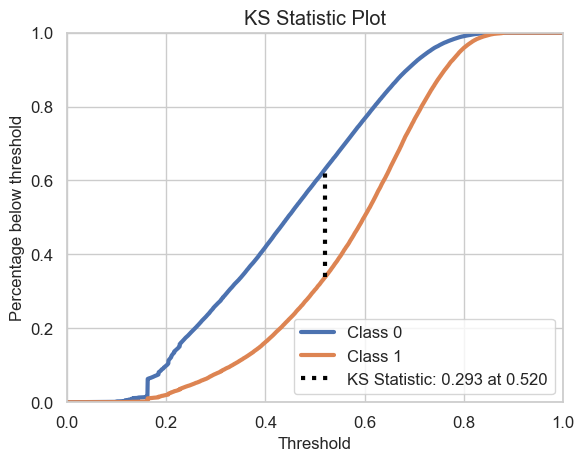

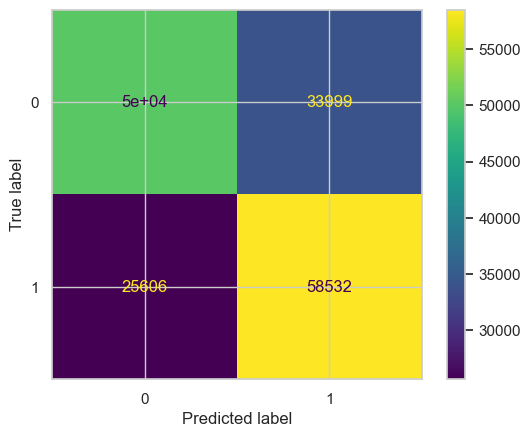


Accuracy:         0.6458
Recall:           0.6957
Precision:        0.6326
F1:               0.6626
AUROC:            0.6998
KS:               0.2927


In [177]:
testePlot(tabnet_opt, X_valid, y_valid.ravel())

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

Gerando análises para o modelo TabNetClassifier(n_d=52, n_a=52, n_steps=6, gamma=1.5357045970525516, cat_idxs=[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 25, 26, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 146, 147, 157, 159, 160, 162, 168, 172, 174, 175, 178, 180, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242], cat_dims=[2, 2, 2, 2, 2, 2, 2, 2, 10, 3, 2, 2, 2, 2, 2, 2, 2, 73, 96, 37, 6, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 100, 77, 2, 66, 11, 34, 70, 26, 64, 95, 93, 80, 66, 23, 14, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

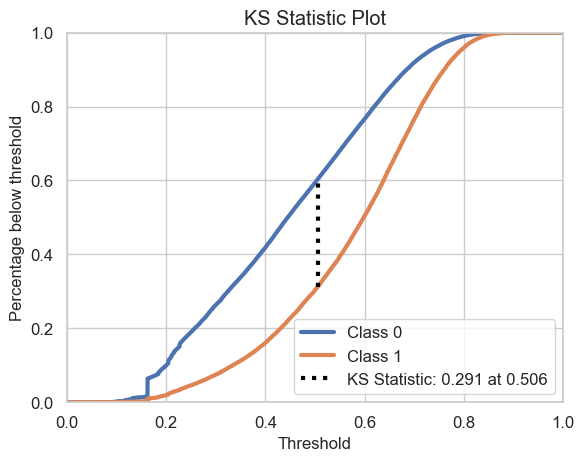

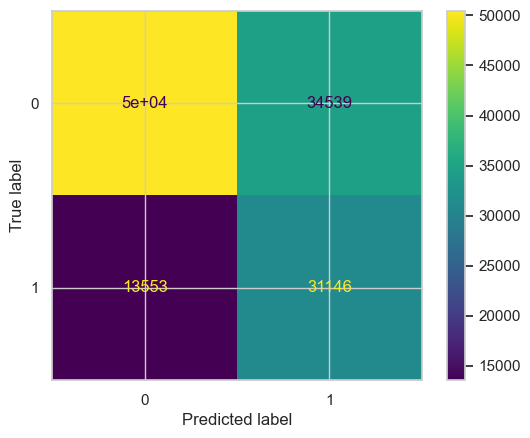


Accuracy:         0.6293
Recall:           0.6968
Precision:        0.4742
F1:               0.5643
AUROC:            0.6998
KS:               0.2915


In [178]:
testePlot(tabnet_opt, X_test, y_test.ravel())

Salvamos os parâmetros do modelo - *state_dict* - em um diretório separado e criamos um aquivo ".JSON" , a fim registrar os hiper-parâmetros capturados.

In [179]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/tabnet_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_tabnet.best_params, json_file, indent=4)

# We save the trained model in order to save time
# torch.save(tabnet_opt.state_dict(), 'models/tabnet_opt.pth')
tabnet_opt.save_model('models/tabnet_opt.pth')

# If you want to load your model
loaded_clf = TabNetClassifier()
loaded_clf.load_model('models/tabnet_opt.pth.zip')

Successfully saved model at models/tabnet_opt.pth.zip


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


#### Data For Transformer Models

Em relação aos modelos analisados a seguir, a abordagem passa a englobar modelos mais sofisticados até para o estado da arte (Transformers). Desse modo, devemos preparar os dados de uma forma específica. Contudo, diferente da abordagem em TabNet, não alimentamos os dados em uma única base de dados. Pelo contrário, fazemos uma separação explícita entre dados categóricos e contínuos. 

A função *testePlotTransformer* calcula e exibe as métricas do modelo específico de *Transformer* no conjunto passado para a mesma. Temos a seguinte função de plot:

In [180]:
def testePlotTransformer(model, loader, y):    
  print(f'Gerando análises para o modelo {model}')
  y_pred_score_all = model.predict_proba(loader)
  y_pred_score_all = y_pred_score_all[1:]
  y_pred_score_positive = y_pred_score_all[:,1]
  y_pred = np.argmax(y_pred_score_all, axis=1)

  accuracy = accuracy_score(y, y_pred)
  recall = recall_score(y, y_pred)
  precision = precision_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  print(y.flatten())
  print(y_pred.flatten())
  skplt.metrics.plot_ks_statistic(y, y_pred_score_all)
  plt.show()

  #y_pred_score = y_pred_score[:, 1]
  ks = ks_results(reshape_plot(y, y_pred_score_positive)[0], reshape_plot(y, y_pred_score_positive)[1])
  auroc = roc_auc_score(y, y_pred_score_positive)
  cm = confusion_matrix(y, y_pred, labels = np.unique(y))
  cmd = ConfusionMatrixDisplay(cm, display_labels = np.unique(y))
  cmd.plot()
  plt.show()
    
  # Skip Line  
  print()

  print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
  print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
  print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
  print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))

  if auroc is not None:
      print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
      
  print("{metric:<18}{value:.4f}".format(metric="KS:", value=ks))

Devemos ter cuidado, visto que as duas últimas colunas são categóricas, mas não são features. Essas colunas fazem jus à nossa classe e à identificação dos índices de treino, validação e teste, devendo serem desconsideradas como features categóricas.

In [181]:
categorical_features = categorical_columns[:-2]

Para os dados serem trabalhados para os modelos a seguir, devemos ter uma dupla indicando a quantidade de "categorias" em cada uma das colunas categóricas:

In [182]:
categories_nunique = ()

for column in data[features].iloc[:, cat_idxs]:
    categories_nunique += (data[column].nunique(),)

Temos a seguinte forma:

In [183]:
# Just an example of the number of unique values in some categorical features
categories_nunique[:20]

(2, 2, 2, 2, 2, 2, 2, 2, 10, 3, 2, 2, 2, 2, 2, 2, 2, 73, 96, 37)

Fazemos a segmentação dos nossos dados, tanto em quesito de índice de treino, validação e teste, quando em quesito de tipos de dados (categórico ou contínuo).

In [184]:
X_train_categ = data[categorical_features].values[train_indices]

X_valid_categ = data[categorical_features].values[valid_indices]

X_test_categ = data[categorical_features].values[test_indices]

In [185]:
X_train_cont = data.drop(columns=categorical_features+unused_feat+[target]).values[train_indices]

X_valid_cont = data.drop(columns=categorical_features+unused_feat+[target]).values[valid_indices]

X_test_cont = data.drop(columns=categorical_features+unused_feat+[target]).values[test_indices]

In [186]:
y_train = data[target].values[train_indices]

y_valid = data[target].values[valid_indices]

y_test = data[target].values[test_indices]

Convertemos os nossos dados para numpy e, posteriormente, para o tipo Torch.Tensor, visto que nossa implementação dos modelos é feita em PyTorch.

In [187]:
X_train_categ = np.array(X_train_categ)
X_valid_categ = np.array(X_valid_categ)
X_test_categ = np.array(X_test_categ)
X_train_cont = np.array(X_train_cont)
X_valid_cont = np.array(X_valid_cont)
X_test_cont = np.array(X_test_cont)
y_train = np.array(y_train).reshape(-1,1)
y_valid = np.array(y_valid).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [188]:
x_train_categ = torch.tensor(X_train_categ, dtype=torch.long)
x_train_cont = torch.tensor(X_train_cont, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

x_valid_categ = torch.tensor(X_valid_categ, dtype=torch.long)
x_valid_cont = torch.tensor(X_valid_cont, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

x_test_categ = torch.tensor(X_test_categ, dtype=torch.long)
x_test_cont = torch.tensor(X_test_cont, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

Alimentamos nossos dados já trabalhados em um formato que possa ser alimentado para os DataLoaders em seguida.

In [189]:
train_dataset = TensorDataset(x_train_categ, x_train_cont, y_train)

valid_dataset = TensorDataset(x_valid_categ, x_valid_cont, y_valid)

test_dataset = TensorDataset(x_test_categ, x_test_cont, y_test)

A célula a seguir não é estritamente necessária, visto que os dados categóricos não apresentam relevância númerica quando internamente tratados pelos nossos modelos. Assim sendo, apenas temos uma "visualização" facilitada desses dados, em que a magnitue não interfere na mesma.

In [190]:
x_train_categ = x_train_categ / x_train_categ.max()
x_valid_categ = x_valid_categ / x_valid_categ.max()
x_test_categ = x_test_categ / x_test_categ.max()

Os modelos trabalhados a seguir exigem um grande poder computacional, visto que sua arquitetura é mais complexa e sofisticada quando comparada com métodos mais tradicionais de Aprendizagem Profunda. Seria prudente, ainda, analisar o potencial de implementações mais eficiente, como fornecidas nas mais demasiadas plataformas, como HuggingFace, ou frameworks, como Keras. Contudo, nesse projeto, escolhemos a implementação em PyTorch das técnicas. 

Nesse quesito, escolhemos um *batch_size* pequeno, mas que pode ser ajustado de acordo com o poder computacional do usuário.

In [191]:
# CHANGE BATCH SIZE
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### TabTransformer

Os modelos TabTransformers aplicam a arquitetura de transformers para lidar com características tabulares, permitindo que o modelo aprenda padrões complexos e dependências entre diferentes colunas de dados.

In [192]:
from tab_transformer_pytorch import TabTransformer, FTTransformer

A função torch.cuda.empty_cache() é usada para liberar a memória não utilizada, ou seja, desalocar a memória que não está mais sendo referenciada pelo código. Pode ser útil em caso hajam variáveis "lixo".

In [193]:
torch.cuda.empty_cache()

#### TabTransformer GPT (With Optuna)

Aplicar uma função sigmoid em uma saída de uma rede neural é equivalente a obter a probabilidade associada a uma determinada classe em um problema de classificação binária. Quando aplicada à saída da rede neural (que é uma pontuação), ela transforma a pontuação em um valor entre 0 e 1, que pode ser interpretado como a probabilidade de que o exemplo pertence à classe positiva.

Essa implementação foi feita também na análise de Redes Neurais tradicionais.

Por esse motivo, aplicamos uma função Sigmoide à saída da nossa rede.

In [194]:
sigmoid = nn.Sigmoid()

Acrescentamos a nossa abordagem de probabilidade associada ao modelo analisado.

In [195]:
# My Model with Predict Proba

class MyTabTransformer(TabTransformer):    
    def predict_proba(self, dataloader):
        # probabilities = torch.tensor([]).to(device)
        # WE CREATE A DUMMY ARRAY TO STORE THE PROBABILITIES, BUT REMEMBER TO REMOVE THE FIRST ELEMENT LATER
        probabilities = np.array([[0,0]])
        super().eval()
        with torch.no_grad():
            # Reading batch by batch
            for idx, (x_categ, x_cont, _) in enumerate(tqdm(dataloader)):
                #####################################
                # COMMENT IF THERE IS A CUDA ERROR
                x_categ = x_categ.to(device)
                x_cont = x_cont.to(device)
                #####################################
                
                # Get the raw output from the model
                outputs = super().forward(x_categ, x_cont)
                # outputs = sigmoid(outputs)
                
                # YOU MIGHT NEED TO CHANGE IF THE OUTPUT OF YOUR NETWORK IS ALREADY ON SIGMOID
                # Convert the raw output into probabilities using the sigmoid function
                batch_probabilities = sigmoid(outputs)
                batch_probabilities = batch_probabilities.cpu().detach().numpy()
                batch_probabilities = np.column_stack((1 - batch_probabilities, batch_probabilities))
                probabilities = np.concatenate((probabilities, batch_probabilities), axis=0)
            
        return probabilities

Declaramos uma quantidade de 1000 epochs, apesar de o "EarlyStopping" integrado no modelo impedir a chegada a tal ponto.

In [196]:
num_epochs = 1000
num_batches = int(len(X_train) / batch_size)

Declaramos o objetivo do nosso estudo:

In [197]:
def objective_tabtransformer(trial):
    # Suggest values for the hyperparameters
    # n_d = trial.suggest_int('n_d', 8, 32)
    # n_a = trial.suggest_int('n_a', 8, 32)
    # n_d_and_n_a = trial.suggest_int('n_d_and_n_a', 8, 64)
    # n_steps = trial.suggest_int('n_steps', 3, 10)
    # gamma = trial.suggest_float('gamma', 1.0, 2.0)
    # lambda_sparse = trial.suggest_float('lambda_sparse', 0, 0.001)
    # n_independent = trial.suggest_int('n_independent', 1, 5)
    # n_shared = trial.suggest_int('n_shared', 1, 5)
    # cat_emb_dim = trial.suggest_int('cat_emb_dim', 1, 64)
    
    params_tab_transformer = {
        'dim': trial.suggest_int('dim', 16,64),
        'depth': trial.suggest_categorical('depth', [2,4,6,8,10]),
        'heads': trial.suggest_categorical('heads', [2,4,6,8,10]),
        'attn_dropout': trial.suggest_float('attn_dropout', 0.05, 0.3, step=0.05),
        'ff_dropout': trial.suggest_float('ff_dropout', 0.05, 0.3, step=0.05)
    }
        
    
    mlp_hidden_mults_0 = trial.suggest_categorical('mlp_hidden_mults_0', [2,4,6,8,10])
    mlp_hidden_mults_1 = trial.suggest_categorical('mlp_hidden_mults_1', [2,4,6,8,10])
    
    # learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e-1, step=1e-7)
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1e-3, step=1e-8)
    
    # model_tab = MyTabTransformer(
    #     categories = categories_nunique,      # tuple containing the number of unique values within each category
    #     num_continuous = X_train_cont.shape[1],                # number of continuous values
    #     dim = dim_tab_transformer,                           # dimension, paper set at 32
    #     dim_out = 1,                        # binary prediction, but could be anything
    #     depth = 6,                          # depth, paper recommended 6
    #     heads = 8,                          # heads, paper recommends 8
    #     attn_dropout = 0.1,                 # post-attention dropout
    #     ff_dropout = 0.1,                   # feed forward dropout
    #     mlp_hidden_mults = (4, 2),          # relative multiples of each hidden dimension of the last mlp to logits
    #     mlp_act = nn.ReLU(),                # activation for final mlp, defaults to relu, but could be anything else (selu etc)
    #     #mlp_act = nn.SELU(),
    #     #mlp_act = nn.Sigmoid(),
    #     #continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
    # )
    
    model = MyTabTransformer(
        categories = categories_nunique,      # tuple containing the number of unique values within each category
        num_continuous = X_train_cont.shape[1],                # number of continuous values
        dim_out = 1,                        # binary prediction, but could be anything
        mlp_hidden_mults = (mlp_hidden_mults_0, mlp_hidden_mults_1),          # relative multiples of each hidden dimension of the last mlp to logits
        mlp_act = nn.ReLU(),
        **params_tab_transformer,
        #mlp_act = nn.Sigmoid(),
        #continuous_mean_std = cont_mean_std # (optional) - normalize the continuous values before layer norm
    ).to(device)
    
    # Define the loss function and optimizer
    # criterion = F.binary_cross_entropy_with_logits
    # criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss()
    #criterion = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    counter = 0
    patience = 3

    for epoch in range(num_epochs):
        model.train()
        train_running_loss = 0.0
        cum_accuracy_train = np.array([])

        for idx, (batch) in enumerate(train_loader):
            cat_batch, cont_batch, label_batch = batch

            #####################################
            # COMMENT IF THERE IS A CUDA ERROR
            cat_batch = cat_batch.to(device)
            cont_batch = cont_batch.to(device)
            label_batch = label_batch.to(device)
            #####################################

            optimizer.zero_grad()
            outputs = model(cat_batch, cont_batch)
            # outputs = sigmoid(outputs)
            
            train_loss = criterion(outputs, label_batch)
            train_loss.backward()

            optimizer.step()

            train_running_loss += train_loss.item()

            y_pred = outputs.to('cpu').detach().numpy()
            y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])

            y = label_batch.to('cpu').detach().numpy().squeeze()
            accuracy = accuracy_score(y, y_pred)
            cum_accuracy_train = np.append(cum_accuracy_train, accuracy)

            if idx == 0:
                print(f'----------- For Epoch {epoch+1}/{num_epochs}: -----------')
            if (idx + 1) % 1500 == 0:
                print(f'Batch: {idx+1}/{num_batches}')
            # if (idx + 1) % 100 == 0:
            #     print(f'Outputs: {outputs}')

        cum_accuracy_train = sum(cum_accuracy_train)/len(cum_accuracy_train)

        if (epoch + 1) % 1 == 0:
            #print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train accuracy: {100*(cum_accuracy_train):.2f}%.      | Train loss: {train_running_loss / (len(X_train) / batch_size):.4f}')

            val_running_loss = 0.0
            cum_accuracy_val = np.array([])

            model.eval()
            with torch.no_grad():
                for batch in valid_loader:
                    cat_batch, cont_batch, label_batch = batch

                    #####################################
                    # COMMENT IF THERE IS A CUDA ERROR
                    cat_batch = cat_batch.to(device)
                    cont_batch = cont_batch.to(device)
                    label_batch = label_batch.to(device)
                    #####################################

                    outputs = model(cat_batch, cont_batch)
                    # outputs = sigmoid(outputs)
                    
                    val_loss = criterion(outputs, label_batch)
                    val_running_loss += val_loss.item()

                    y_pred = outputs.to('cpu').detach().numpy()
                    y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])

                    y = label_batch.to('cpu').detach().numpy().squeeze()
                    accuracy = accuracy_score(y, y_pred)
                    cum_accuracy_val = np.append(cum_accuracy_val, accuracy)

                cum_accuracy_val = sum(cum_accuracy_val)/len(cum_accuracy_val)
                print(f'Validation accuracy: {100*(cum_accuracy_val):.2f}%. | Validation loss: {val_running_loss / (len(X_valid) / batch_size):.4f}')
                print('-----------------------------------------------------------')

        # This pruning choice was selected by before hand testing, feel free to manipulate according to your needs
        # if(cum_accuracy_val <= 51 and epoch >= 1):
        #     print("Trial stuck at LOCAL MINIMA.")
        #     raise optuna.TrialPruned()
        
         # Probably stuck at local minima
        if cum_accuracy_val <= 0.51:
            print("Probably stuck at local minima.")
            break
                
        # Check for improvement in validation loss
        if val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            counter = 0
        else:
            counter += 1

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break
            
    ################################################################################### SELECTION
    
    y_pred_score_all = model.predict_proba(valid_loader)
    y_pred_score_all = y_pred_score_all[1:]
    y_pred_score_positive = y_pred_score_all[:,1]
    
    y_pred = np.argmax(y_pred_score_all, axis=1)
    
    ks = ks_results(reshape_plot(y_valid.to('cpu').numpy(), y_pred_score_positive)[0], reshape_plot(y_valid.to('cpu').numpy(), y_pred_score_positive)[1])
    
    trial.set_user_attr('roc_auc', roc_auc_score(y_valid, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_valid, y_pred))
    trial.set_user_attr('precision', precision_score(y_valid, y_pred))
    trial.set_user_attr('recall', recall_score(y_valid, y_pred))
    trial.set_user_attr('f1', f1_score(y_valid, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_valid, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_valid, y_pred), step=3)
    trial.report(precision_score(y_valid, y_pred), step=4)
    trial.report(recall_score(y_valid, y_pred), step=5)
    trial.report(f1_score(y_valid, y_pred), step=6)
    
    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [198]:
def callback_tabtransformer(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Iniciamos o nosso estudo:

In [199]:
# Measure the start time
start_time_tabtransformer = time.time()

study_tabtransformer = optuna.create_study(direction='maximize')

study_tabtransformer.optimize(objective_tabtransformer, n_trials=n_trials, callbacks=[callback_tabtransformer])

print('Number of finished trials:', len(study_tabtransformer.trials))
print('Best trial:', study_tabtransformer.best_trial.params)

# Measure the end time
end_time_tabtransformer = time.time()

# Calculate the duration in seconds
duration_tabtransformer = end_time_tabtransformer - start_time_tabtransformer

[I 2023-09-14 15:09:12,249] A new study created in memory with name: no-name-f291f2c6-de66-4496-a5dc-3adebffab1bf


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 59.27%.      | Train loss: 0.6406
Validation accuracy: 62.76%. | Validation loss: 0.6343
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 61.30%.      | Train loss: 0.6269
Validation accuracy: 61.65%. | Validation loss: 0.6299
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [02:12<00:00, 79.65it/s]
[I 2023-09-14 16:35:31,477] Trial 0 finished with value: 0.24029570467565192 and parameters: {'dim': 28, 'depth': 8, 'heads': 6, 'attn_dropout': 0.2, 'ff_dropout': 0.1, 'mlp_hidden_mults_0': 10, 'mlp_hidden_mults_1': 8, 'learning_rate': 0.00012764999999999999}. Best is trial 0 with value: 0.24029570467565192.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 59.14%.      | Train loss: 0.6414
Validation accuracy: 60.67%. | Validation loss: 0.6319
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 61.01%.      | Train loss: 0.6294
Validation accuracy: 61.54%. | Validation loss: 0.6324
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [02:24<00:00, 72.61it/s]
[I 2023-09-14 18:22:04,560] Trial 1 finished with value: 0.2660985523782357 and parameters: {'dim': 19, 'depth': 10, 'heads': 8, 'attn_dropout': 0.05, 'ff_dropout': 0.2, 'mlp_hidden_mults_0': 8, 'mlp_hidden_mults_1': 4, 'learning_rate': 0.0006197800000000001}. Best is trial 1 with value: 0.2660985523782357.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.94%.      | Train loss: 0.6442
Validation accuracy: 56.76%. | Validation loss: 0.6367
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.93%.      | Train loss: 0.6303
Validation accuracy: 59.92%. | Validation loss: 0.6305
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [01:29<00:00, 117.22it/s]
[I 2023-09-14 19:54:51,515] Trial 2 finished with value: 0.2665264208799829 and parameters: {'dim': 50, 'depth': 4, 'heads': 10, 'attn_dropout': 0.1, 'ff_dropout': 0.3, 'mlp_hidden_mults_0': 10, 'mlp_hidden_mults_1': 8, 'learning_rate': 0.00038643}. Best is trial 2 with value: 0.2665264208799829.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.56%.      | Train loss: 0.6480
Validation accuracy: 63.36%. | Validation loss: 0.6381
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.73%.      | Train loss: 0.6333
Validation accuracy: 59.96%. | Validation loss: 0.6333
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [00:53<00:00, 196.71it/s]
[I 2023-09-14 20:50:29,804] Trial 3 finished with value: 0.27813829660795364 and parameters: {'dim': 51, 'depth': 2, 'heads': 10, 'attn_dropout': 0.3, 'ff_dropout': 0.1, 'mlp_hidden_mults_0': 4, 'mlp_hidden_mults_1': 10, 'learning_rate': 0.0008929200000000001}. Best is trial 3 with value: 0.27813829660795364.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 59.38%.      | Train loss: 0.6401
Validation accuracy: 62.39%. | Validation loss: 0.6374
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.95%.      | Train loss: 0.6296
Validation accuracy: 63.06%. | Validation loss: 0.6344
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [01:07<00:00, 154.98it/s]
[I 2023-09-14 21:36:49,612] Trial 4 finished with value: 0.26915305807126383 and parameters: {'dim': 17, 'depth': 4, 'heads': 8, 'attn_dropout': 0.2, 'ff_dropout': 0.2, 'mlp_hidden_mults_0': 2, 'mlp_hidden_mults_1': 2, 'learning_rate': 0.00022995}. Best is trial 3 with value: 0.27813829660795364.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 59.10%.      | Train loss: 0.6438
Validation accuracy: 58.87%. | Validation loss: 0.6333
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.87%.      | Train loss: 0.6303
Validation accuracy: 60.78%. | Validation loss: 0.6319
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [02:04<00:00, 84.67it/s]
[I 2023-09-14 23:04:08,244] Trial 5 finished with value: 0.27440633245382584 and parameters: {'dim': 39, 'depth': 8, 'heads': 8, 'attn_dropout': 0.3, 'ff_dropout': 0.05, 'mlp_hidden_mults_0': 10, 'mlp_hidden_mults_1': 4, 'learning_rate': 0.0005885}. Best is trial 3 with value: 0.27813829660795364.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 59.17%.      | Train loss: 0.6413
Validation accuracy: 60.77%. | Validation loss: 0.6325
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 61.30%.      | Train loss: 0.6279
Validation accuracy: 58.58%. | Validation loss: 0.6320
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [01:08<00:00, 154.28it/s]
[I 2023-09-14 23:52:44,243] Trial 6 finished with value: 0.2577907723026457 and parameters: {'dim': 30, 'depth': 4, 'heads': 6, 'attn_dropout': 0.05, 'ff_dropout': 0.15000000000000002, 'mlp_hidden_mults_0': 10, 'mlp_hidden_mults_1': 2, 'learning_rate': 0.00034683}. Best is trial 3 with value: 0.27813829660795364.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.78%.      | Train loss: 0.6455
Validation accuracy: 61.44%. | Validation loss: 0.6350
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.87%.      | Train loss: 0.6338
Validation accuracy: 60.96%. | Validation loss: 0.6331
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [01:08<00:00, 153.12it/s]
[I 2023-09-15 00:44:03,807] Trial 7 finished with value: 0.28411657039625376 and parameters: {'dim': 39, 'depth': 4, 'heads': 8, 'attn_dropout': 0.1, 'ff_dropout': 0.1, 'mlp_hidden_mults_0': 2, 'mlp_hidden_mults_1': 10, 'learning_rate': 0.0009758500000000001}. Best is trial 7 with value: 0.28411657039625376.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.20%.      | Train loss: 0.6493
Validation accuracy: 57.78%. | Validation loss: 0.6375
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.06%.      | Train loss: 0.6372
Validation accuracy: 59.33%. | Validation loss: 0.6350
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [03:28<00:00, 50.40it/s]
[I 2023-09-15 03:15:19,839] Trial 8 finished with value: 0.28374812807530486 and parameters: {'dim': 47, 'depth': 10, 'heads': 8, 'attn_dropout': 0.2, 'ff_dropout': 0.3, 'mlp_hidden_mults_0': 4, 'mlp_hidden_mults_1': 8, 'learning_rate': 0.0008056200000000001}. Best is trial 7 with value: 0.28411657039625376.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.94%.      | Train loss: 0.6437
Validation accuracy: 61.89%. | Validation loss: 0.6355
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.80%.      | Train loss: 0.6311
Validation accuracy: 57.90%. | Validation loss: 0.6351
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [01:05<00:00, 161.41it/s]
[I 2023-09-15 04:13:15,692] Trial 9 finished with value: 0.27174403955406595 and parameters: {'dim': 46, 'depth': 2, 'heads': 10, 'attn_dropout': 0.05, 'ff_dropout': 0.05, 'mlp_hidden_mults_0': 4, 'mlp_hidden_mults_1': 8, 'learning_rate': 8.86e-06}. Best is trial 7 with value: 0.28411657039625376.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.26%.      | Train loss: 0.6486
Validation accuracy: 60.27%. | Validation loss: 0.6357
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.22%.      | Train loss: 0.6359
Validation accuracy: 61.88%. | Validation loss: 0.6376
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [01:42<00:00, 102.43it/s]
[I 2023-09-15 05:59:40,160] Trial 10 finished with value: 0.28207230977679526 and parameters: {'dim': 64, 'depth': 6, 'heads': 4, 'attn_dropout': 0.15000000000000002, 'ff_dropout': 0.15000000000000002, 'mlp_hidden_mults_0': 2, 'mlp_hidden_mults_1': 6, 'learning_rate': 0.0009923599999999999}. Best is trial 7 with value: 0.28411657039625376.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.87%.      | Train loss: 0.6467
Validation accuracy: 62.45%. | Validation loss: 0.6389
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.85%.      | Train loss: 0.6325
Validation accuracy: 62.87%. | Validation loss: 0.6344
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [02:40<00:00, 65.39it/s]
[I 2023-09-15 09:05:48,918] Trial 11 finished with value: 0.27396657871591906 and parameters: {'dim': 39, 'depth': 10, 'heads': 2, 'attn_dropout': 0.15000000000000002, 'ff_dropout': 0.3, 'mlp_hidden_mults_0': 6, 'mlp_hidden_mults_1': 10, 'learning_rate': 0.00080688}. Best is trial 7 with value: 0.28411657039625376.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.44%.      | Train loss: 0.6479
Validation accuracy: 61.75%. | Validation loss: 0.6372
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.56%.      | Train loss: 0.6361
Validation accuracy: 61.72%. | Validation loss: 0.6337
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [04:15<00:00, 41.17it/s]
[I 2023-09-15 14:13:42,661] Trial 12 finished with value: 0.2888944353324301 and parameters: {'dim': 57, 'depth': 10, 'heads': 8, 'attn_dropout': 0.25, 'ff_dropout': 0.25, 'mlp_hidden_mults_0': 2, 'mlp_hidden_mults_1': 10, 'learning_rate': 0.00074832}. Best is trial 12 with value: 0.2888944353324301.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.52%.      | Train loss: 0.6485
Validation accuracy: 55.42%. | Validation loss: 0.6550
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.26%.      | Train loss: 0.6371
Validation accuracy: 59.29%. | Validation loss: 0.6355
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [01:47<00:00, 97.60it/s]
[I 2023-09-16 01:00:56,933] Trial 13 finished with value: 0.28695714183840837 and parameters: {'dim': 62, 'depth': 6, 'heads': 8, 'attn_dropout': 0.25, 'ff_dropout': 0.25, 'mlp_hidden_mults_0': 2, 'mlp_hidden_mults_1': 10, 'learning_rate': 0.0007015700000000001}. Best is trial 12 with value: 0.2888944353324301.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 58.22%.      | Train loss: 0.6496
Validation accuracy: 57.87%. | Validation loss: 0.6356
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.01%.      | Train loss: 0.6358
Validation accuracy: 61.71%. | Validation loss: 0.6381
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [02:09<00:00, 81.44it/s]
[I 2023-09-16 09:38:16,930] Trial 14 finished with value: 0.2872780432147187 and parameters: {'dim': 63, 'depth': 6, 'heads': 4, 'attn_dropout': 0.25, 'ff_dropout': 0.25, 'mlp_hidden_mults_0': 2, 'mlp_hidden_mults_1': 10, 'learning_rate': 0.0006954800000000001}. Best is trial 12 with value: 0.2888944353324301.


Number of finished trials: 15
Best trial: {'dim': 57, 'depth': 10, 'heads': 8, 'attn_dropout': 0.25, 'ff_dropout': 0.25, 'mlp_hidden_mults_0': 2, 'mlp_hidden_mults_1': 10, 'learning_rate': 0.00074832}


Temos o melhor valor para o KS:

In [200]:
ks_tabtransformer = max([trial.user_attrs['ks'] for trial in study_tabtransformer.trials])
print(ks_tabtransformer)

0.2888944353324301


Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [201]:
results_tabtransformer_opt = pd.DataFrame({'model': 'TabTransformer Optuna','ks': study_tabtransformer.best_trial.user_attrs['ks'], 'roc_auc': study_tabtransformer.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_tabtransformer.best_trial.user_attrs['accuracy'], 'precision': study_tabtransformer.best_trial.user_attrs['precision'], \
                            'recall': study_tabtransformer.best_trial.user_attrs['recall'], 'f1': study_tabtransformer.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_tabtransformer))}, index=[0])

results = pd.concat([results, results_tabtransformer_opt])
results

,model,ks,roc_auc,accuracy,precision,recall,f1,time
0,?,?,?,?,?,?,?,?
0,Random Forest Optuna,0.29706,0.703178,0.647977,0.643788,0.662542,0.653031,16:12:17
0,Gradient Boosting Optuna,0.312403,0.713492,0.654502,0.658718,0.64122,0.649852,14:10:52
0,GXB Optuna,0.309408,0.711585,0.654253,0.646097,0.682165,0.663641,00:08:42
0,LightGBM Optuna,0.313675,0.714713,0.65657,0.649735,0.679396,0.664234,00:09:02
0,Ensemble,0.317003,0.716638,0.658442,0.654355,0.671682,0.662905,11:14:49
0,Torch MLP Optuna,0.284021,0.694927,0.570355,0.744274,0.214362,0.332857,06:26:13
0,TabNet Optuna,0.292686,0.699796,0.64579,0.632566,0.695667,0.662618,20:31:15
0,TabTransformer Optuna,0.288894,0.695736,0.641506,0.651518,0.608465,0.629256,18:29:05


Temos o nosso melhor modelo.

In [202]:
tabtransformer_opt = study_tabtransformer.user_attrs["best_model"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

Gerando análises para o modelo MyTabTransformer(
  (norm): LayerNorm((123,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (embeds): Embedding(1255, 57)
    (layers): ModuleList(
      (0-9): 10 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((57,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=57, out_features=384, bias=False)
            (to_out): Linear(in_features=128, out_features=57, bias=True)
            (dropout): Dropout(p=0.25, inplace=False)
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((57,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=57, out_features=456, bias=True)
              (1): GEGLU()
              (2): Dropout(p=0.25, inplace=False)
              (3): Linear(in_features=228, out_features=57, bias=True)
            )
          )
        )
      )
    )


100%|████████████████████████████████████████████████████████████████████████████| 10518/10518 [07:01<00:00, 24.96it/s]


[0. 0. 0. ... 0. 1. 1.]
[0 0 0 ... 0 1 0]


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


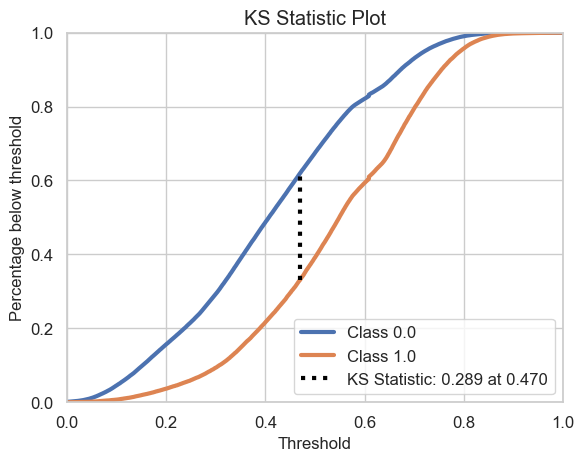

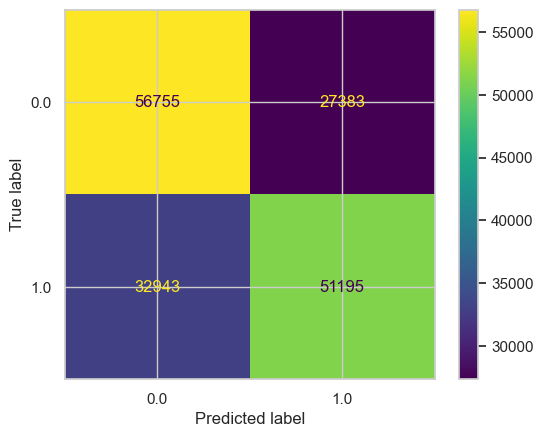


Accuracy:         0.6415
Recall:           0.6085
Precision:        0.6515
F1:               0.6293
AUROC:            0.6957
KS:               0.2889


In [203]:
testePlotTransformer(tabtransformer_opt, valid_loader, y_valid.detach().to('cpu').numpy())

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

Gerando análises para o modelo MyTabTransformer(
  (norm): LayerNorm((123,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (embeds): Embedding(1255, 57)
    (layers): ModuleList(
      (0-9): 10 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((57,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (to_qkv): Linear(in_features=57, out_features=384, bias=False)
            (to_out): Linear(in_features=128, out_features=57, bias=True)
            (dropout): Dropout(p=0.25, inplace=False)
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((57,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=57, out_features=456, bias=True)
              (1): GEGLU()
              (2): Dropout(p=0.25, inplace=False)
              (3): Linear(in_features=228, out_features=57, bias=True)
            )
          )
        )
      )
    )


100%|██████████████████████████████████████████████████████████████████████████████| 8108/8108 [05:23<00:00, 25.05it/s]
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0. 0. 0. ... 1. 1. 1.]
[0 1 1 ... 0 0 1]


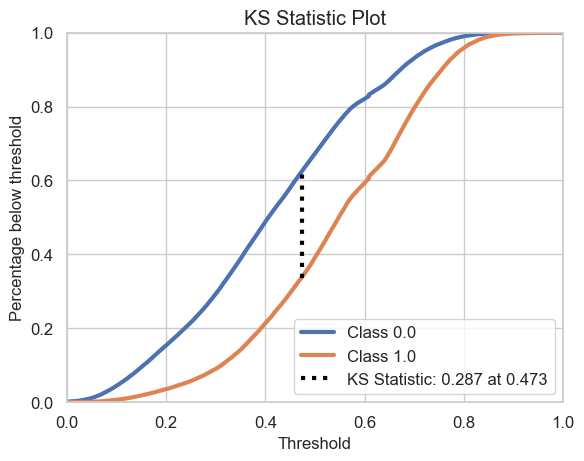

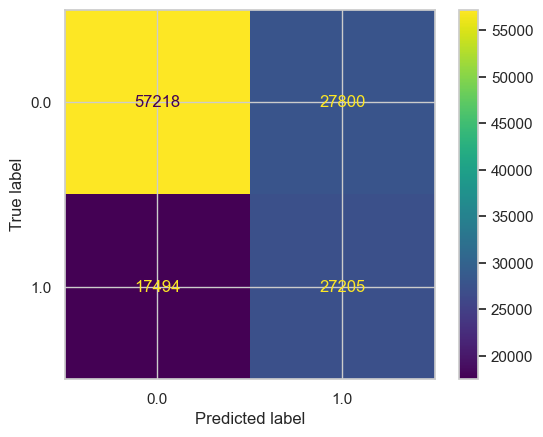


Accuracy:         0.6508
Recall:           0.6086
Precision:        0.4946
F1:               0.5457
AUROC:            0.6967
KS:               0.2866


In [204]:
testePlotTransformer(tabtransformer_opt, test_loader, y_test.detach().to('cpu').numpy())

Salvamos os parâmetros do modelo - *state_dict* - em um diretório separado e criamos um aquivo ".JSON" , a fim registrar os hiper-parâmetros capturados.

In [205]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/tabtransformer_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_tabtransformer.best_params, json_file, indent=4)

# We save the trained model in order to save time
torch.save(tabtransformer_opt.state_dict(), 'models/tabtransformer_opt.pth')

#### FTTransformer

O modelo em questão melhora o Tab Transformer ao adotar uma abordagem mais simples para incorporar valores numéricos contínuos.

A função torch.cuda.empty_cache() é usada para liberar a memória não utilizada, ou seja, desalocar a memória que não está mais sendo referenciada pelo código. Pode ser útil em caso hajam variáveis "lixo".

In [206]:
torch.cuda.empty_cache()

#### FTTransformer (With Optuna)

Acrescentamos a nossa abordagem de probabilidade associada ao modelo analisado.

In [207]:
class MyFTTransformer(FTTransformer):    
    def predict_proba(self, dataloader):
        # probabilities = torch.tensor([]).to(device)
        # WE CREATE A DUMMY ARRAY TO STORE THE PROBABILITIES, BUT REMEMBER TO REMOVE THE FIRST ELEMENT LATER
        probabilities = np.array([[0,0]])
        super().eval()
        with torch.no_grad():
            # Reading batch by batch
            for idx, (x_categ, x_cont, _) in enumerate(tqdm(dataloader)):
                #####################################
                # COMMENT IF THERE IS A CUDA ERROR
                x_categ = x_categ.to(device)
                x_cont = x_cont.to(device)
                #####################################
                
                # Get the raw output from the model
                outputs = super().forward(x_categ, x_cont)
                # outputs = sigmoid(outputs)
                
                # YOU MIGHT NEED TO CHANGE IF THE OUTPUT OF YOUR NETWORK IS ALREADY ON SIGMOID
                # Convert the raw output into probabilities using the sigmoid function
                batch_probabilities = sigmoid(outputs)
                batch_probabilities = batch_probabilities.cpu().detach().numpy()
                batch_probabilities = np.column_stack((1 - batch_probabilities, batch_probabilities))
                # probabilities = torch.cat((probabilities, batch_probabilities), dim=0)
                probabilities = np.concatenate((probabilities, batch_probabilities), axis=0)
            
            # y_pred = probabilities.detach().to('cpu').numpy()
            # y_pred_proba = np.column_stack((1 - y_pred, y_pred))
            
        # return y_pred_proba
        return probabilities

Declaramos uma quantidade de 1000 epochs, apesar de o "EarlyStopping" integrado no modelo impedir a chegada a tal ponto.

In [208]:
num_epochs = 1000
num_batches = int(len(X_train) / batch_size)

Declaramos o objetivo do nosso estudo:

In [209]:
def objective_fttransformer(trial):
    # Suggest values for the hyperparameters
    # n_d = trial.suggest_int('n_d', 8, 32)
    # n_a = trial.suggest_int('n_a', 8, 32)
    # n_d_and_n_a = trial.suggest_int('n_d_and_n_a', 8, 64)
    # n_steps = trial.suggest_int('n_steps', 3, 10)
    # gamma = trial.suggest_float('gamma', 1.0, 2.0)
    # lambda_sparse = trial.suggest_float('lambda_sparse', 0, 0.001)
    # n_independent = trial.suggest_int('n_independent', 1, 5)
    # n_shared = trial.suggest_int('n_shared', 1, 5)
    # cat_emb_dim = trial.suggest_int('cat_emb_dim', 1, 64)
    
    params_fttransformer = {
        'dim': trial.suggest_int('dim', 16,128),
        'depth': trial.suggest_categorical('depth', [2,4,6,8,10]),
        'heads': trial.suggest_categorical('heads', [2,4,6,8,10]),
        'attn_dropout': trial.suggest_float('attn_dropout', 0.05, 0.3, step=0.05),
        'ff_dropout': trial.suggest_float('ff_dropout', 0.05, 0.3, step=0.05)
    }
        
    learning_rate = trial.suggest_float('learning_rate', 1e-8, 1e-3, step=1e-8)
    
    model = MyFTTransformer(
        categories = categories_nunique,      # tuple containing the number of unique values within each category
        num_continuous = X_train_cont.shape[1],                # number of continuous values
        dim_out = 1,                        # binary prediction, but could be anything
        **params_fttransformer
    ).to(device)
    
    # Define the loss function and optimizer
    # criterion = F.binary_cross_entropy_with_logits
    # criterion = nn.BCELoss()
    criterion = nn.BCEWithLogitsLoss()
    #criterion = F.binary_cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    counter = 0
    patience = 3

    for epoch in range(num_epochs):
        model.train()
        train_running_loss = 0.0
        cum_accuracy_train = np.array([])

        for idx, (batch) in enumerate(train_loader):
            cat_batch, cont_batch, label_batch = batch

            #####################################
            # COMMENT IF THERE IS A CUDA ERROR
            cat_batch = cat_batch.to(device)
            cont_batch = cont_batch.to(device)
            label_batch = label_batch.to(device)
            #####################################

            optimizer.zero_grad()
            outputs = model(cat_batch, cont_batch)
            # outputs = sigmoid(outputs)

            train_loss = criterion(outputs, label_batch)
            train_loss.backward()

            optimizer.step()

            train_running_loss += train_loss.item()

            y_pred = outputs.to('cpu').detach().numpy()
            y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])

            y = label_batch.to('cpu').detach().numpy().squeeze()
            accuracy = accuracy_score(y, y_pred)
            cum_accuracy_train = np.append(cum_accuracy_train, accuracy)

            if idx == 0:
                print(f'----------- For Epoch {epoch+1}/{num_epochs}: -----------')
            if (idx + 1) % 1500 == 0:
                print(f'Batch: {idx+1}/{num_batches}')

        cum_accuracy_train = sum(cum_accuracy_train)/len(cum_accuracy_train)

        if (epoch + 1) % 1 == 0:
            #print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train accuracy: {100*(cum_accuracy_train):.2f}%.      | Train loss: {train_running_loss / (len(X_train) / batch_size):.4f}')

            val_running_loss = 0.0
            cum_accuracy_val = np.array([])

            model.eval()
            with torch.no_grad():
                for batch in valid_loader:
                    cat_batch, cont_batch, label_batch = batch

                    #####################################
                    # COMMENT IF THERE IS A CUDA ERROR
                    cat_batch = cat_batch.to(device)
                    cont_batch = cont_batch.to(device)
                    label_batch = label_batch.to(device)
                    #####################################

                    outputs = model(cat_batch, cont_batch)
                    # outputs = sigmoid(outputs)

                    val_loss = criterion(outputs, label_batch)
                    val_running_loss += val_loss.item()

                    y_pred = outputs.to('cpu').detach().numpy()
                    y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])

                    y = label_batch.to('cpu').detach().numpy().squeeze()
                    accuracy = accuracy_score(y, y_pred)
                    cum_accuracy_val = np.append(cum_accuracy_val, accuracy)

                cum_accuracy_val = sum(cum_accuracy_val)/len(cum_accuracy_val)
                print(f'Validation accuracy: {100*(cum_accuracy_val):.2f}%. | Validation loss: {val_running_loss / (len(X_valid) / batch_size):.4f}')
                print('-----------------------------------------------------------')

        # This pruning choice was selected by before hand testing, feel free to manipulate according to your needs
        # if(cum_accuracy_val <= 51 and epoch >= 1):
        #     print("Trial stuck at LOCAL MINIMA.")
        #     raise optuna.TrialPruned()
                
        # Probably stuck at local minima
        if cum_accuracy_val <= 0.51:
            print("Probably stuck at local minima.")
            break
            
        # Check for improvement in validation loss
        if val_running_loss < best_val_loss:
            best_val_loss = val_running_loss
            counter = 0
        else:
            counter += 1

        # Early stopping condition
        if counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break
            
    ################################################################################### SELECTION
    
    y_pred_score_all = model.predict_proba(valid_loader)
    y_pred_score_all = y_pred_score_all[1:]
    y_pred_score_positive = y_pred_score_all[:,1]
    
    y_pred = np.argmax(y_pred_score_all, axis=1)
    
    ks = ks_results(reshape_plot(y_valid.to('cpu').numpy(), y_pred_score_positive)[0], reshape_plot(y_valid.to('cpu').numpy(), y_pred_score_positive)[1])
    
    trial.set_user_attr('roc_auc', roc_auc_score(y_valid, y_pred_score_positive))
    trial.set_user_attr('ks', ks)
    trial.set_user_attr('accuracy', accuracy_score(y_valid, y_pred))
    trial.set_user_attr('precision', precision_score(y_valid, y_pred))
    trial.set_user_attr('recall', recall_score(y_valid, y_pred))
    trial.set_user_attr('f1', f1_score(y_valid, y_pred))
    
    # REGARDING SAVING THE BEST MODEL
    trial.set_user_attr(key="best_model", value=model)

    trial.report(ks, step=1)
    trial.report(roc_auc_score(y_valid, y_pred_score_positive), step=2)
    trial.report(accuracy_score(y_valid, y_pred), step=3)
    trial.report(precision_score(y_valid, y_pred), step=4)
    trial.report(recall_score(y_valid, y_pred), step=5)
    trial.report(f1_score(y_valid, y_pred), step=6)
    
    return ks

Temos uma função callback que guarda o melhor modelo como um atributo do estudo. Desse modo, não precisamos treinar o modelo novamente com os hiper-parâmetros selecionados, podendo utilizar o modelo diretamente:

In [210]:
def callback_fttransformer(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_model", value=trial.user_attrs["best_model"])

Iniciamos o nosso estudo:

In [ ]:
# Measure the start time
start_time_fttransformer = time.time()

study_fttransformer = optuna.create_study(direction='maximize')

study_fttransformer.optimize(objective_fttransformer, n_trials=n_trials, callbacks=[callback_fttransformer])

print('Number of finished trials:', len(study_fttransformer.trials))
print('Best trial:', study_fttransformer.best_trial.params)

# Measure the end time
end_time_fttransformer = time.time()

# Calculate the duration in seconds
duration_fttransformer = end_time_fttransformer - start_time_fttransformer

[I 2023-09-16 09:50:47,592] A new study created in memory with name: no-name-759c6074-0643-4ba9-9e0e-56989f4d5f56


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 59.19%.      | Train loss: 0.6441
Validation accuracy: 63.25%. | Validation loss: 0.6369
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.79%.      | Train loss: 0.6345
Validation accuracy: 60.81%. | Validation loss: 0.6310
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

100%|███████████████████████████████████████████████████████████████████████████| 10518/10518 [01:42<00:00, 102.36it/s]
[I 2023-09-16 10:59:53,734] Trial 0 finished with value: 0.28912025481946324 and parameters: {'dim': 55, 'depth': 4, 'heads': 2, 'attn_dropout': 0.25, 'ff_dropout': 0.15000000000000002, 'learning_rate': 0.00042552}. Best is trial 0 with value: 0.28912025481946324.


----------- For Epoch 1/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 59.56%.      | Train loss: 0.6416
Validation accuracy: 60.86%. | Validation loss: 0.6315
-----------------------------------------------------------
----------- For Epoch 2/1000: -----------
Batch: 1500/21353
Batch: 3000/21353
Batch: 4500/21353
Batch: 6000/21353
Batch: 7500/21353
Batch: 9000/21353
Batch: 10500/21353
Batch: 12000/21353
Batch: 13500/21353
Batch: 15000/21353
Batch: 16500/21353
Batch: 18000/21353
Batch: 19500/21353
Batch: 21000/21353
Train accuracy: 60.97%.      | Train loss: 0.6322
Validation accuracy: 63.26%. | Validation loss: 0.6319
-----------------------------------------------------------
----------- For Epoch 3/1000: -----------
Batch: 1500/21353
Batch:

Temos o melhor valor para o KS:

In [ ]:
ks_fttransformer = max([trial.user_attrs['ks'] for trial in study_fttransformer.trials])
print(ks_fttransformer)

Catalogamos o modelo analisado, bem como suas métricas de avaliação (lembrando que estas métricas são referentes ao conjunto de validação):

In [ ]:
results_fttransformer_opt = pd.DataFrame({'model': 'FTTransformer Optuna','ks': study_fttransformer.best_trial.user_attrs['ks'], 'roc_auc': study_fttransformer.best_trial.user_attrs['roc_auc'],\
                            'accuracy': study_fttransformer.best_trial.user_attrs['accuracy'], 'precision': study_fttransformer.best_trial.user_attrs['precision'], \
                            'recall': study_fttransformer.best_trial.user_attrs['recall'], 'f1': study_fttransformer.best_trial.user_attrs['f1'],\
                            'time': time.strftime('%H:%M:%S', time.gmtime(duration_fttransformer))}, index=[0])

results = pd.concat([results, results_fttransformer_opt])
results

Temos o nosso melhor modelo e seu hisórico de treinamento.

In [ ]:
fttransformer_opt = study_fttransformer.user_attrs["best_model"]

Visualizamos a análise do modelo em relação ao nosso conjunto de validação:

In [ ]:
testePlotTransformer(fttransformer_opt, valid_loader, y_valid.detach().to('cpu').numpy())

Visualizamos a análise do modelo em relação ao nosso conjunto de teste:

In [ ]:
testePlotTransformer(fttransformer_opt, test_loader, y_test.detach().to('cpu').numpy())

In [ ]:
study_fttransformer.best_params

In [ ]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/fttransformer_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_fttransformer.best_params, json_file, indent=4)

In [ ]:
# Define the path where you want to save the JSON file
json_filename = "hyperparameters/fttransformer_best_hyperparameters.json"

# Save the best hyperparameters to the JSON file
with open(json_filename, "w") as json_file:
    json.dump(study_fttransformer.best_params, json_file, indent=4)

# We save the trained model in order to save time
torch.save(fttransformer_opt.state_dict(), 'models/fttransformer_opt.pth')

**Atenção**: Caso queira importar o modelo já otimizado, você deve antes instanciar a arquitetura do modelo base:

*Exemplo:*

**fttransformer_opt_try = MyFTTransformer(** <br>
    **categories = categories_nunique,**      # tuple containing the number of unique values within each category <br>
    **num_continuous = X_train_cont.shape[1],**                # number of continuous values <br>
    **dim_out = 1,**                        # binary prediction, but could be anything <br>
    **dim = #,** <br>
    **depth = #,** <br>
    **heads = #,** <br>
    **attn_dropout = #,** <br>
    **ff_dropout = #** <br>
**).to(device)**


Posteriormente, importe o dicionário de parâmetros para o modelo:

**fttransformer_opt_try.load_state_dict(torch.load('models/fttransformer_opt.pth'))**

Nossa Pipeline já está completa. Contudo, nossa tabela *"results"* não corresponde às métricas dos modelos aplicada ao dataset de teste, mas ao de validação. Dessa forma, precisamos alimentar os modelos obtidos com os dados de teste e instanciar uma tabela com a métricas obtidas: 

Temos a seguir uma possível implementação de como alcançamos tal tabela. Só devemos nos atentar quanto à forma em que os dados são fornecidos como argumento (A partir da implementação de TabNet, os modelos são alimentados de forma moderadamente distintas). Ademais, todos os modelos apresentam um cálculo/código idêntico para as métricas. Assumimos que os todos os modelos estão instanciados e seguem a seguinte forma. Caso contrário, é necessário manipular as celular a seguir.

In [ ]:
# first_models = [random_forest_opt, gradient_boosting_opt, xgb_opt, lbm_opt, ens_clf, mlp_opt, tabnet_opt, tabtransformer_opt, fttransformer_opt]

In [ ]:
# model_names = {random_forest_opt: 'Random Forest', gradient_boosting_opt: 'Gradient Boosting', xgb_opt: 'XGB', lbm_opt: 'LGB', ens_clf: 'Ensemble', mlp_opt: 'MLP', tabnet_opt: 'TabNet', tabtransformer_opt: 'TabTransformer', fttransformer_opt:'FTTransformer' }

In [ ]:
# def final_result(models_list, x, y):
#     print('Gerando tabela de resultados.')
    
#     test_results = pd.DataFrame({'model': '?','ks': '?', 'roc_auc': '?',\
#                             'accuracy': '?', 'precision': '?', \
#                             'recall': '?', 'f1': '?'\
#                             }, index=[0])
    
#     for i in range(len(models_list)):
#         # Random Forest, Gradient Boosting, XGB, LGBM and TabNet
#         if i in [0,1,2,3,4,6]:
            
#             y_pred = models_list[i].predict(x)
#             y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])
            
#             y_pred_score_all = models_list[i].predict_proba(x)
#             y_pred_score_positive = models_list[i].predict_proba(x)[:,1]
                
#         # MLP
#         if i == 5:
#             y_pred = model[i](torch.tensor(x).to(device).float()).detach().to('cpu').numpy()
#             y_pred = np.array([0 if x < 0.5 else 1 for x in y_pred])
            
#             y_pred_score_all = model[i].predict_proba(x)
#             y_pred_score_positive = model[i].predict_proba(x)[:,1]
            
#         # TabTransformer and FTTransformer
#         if i in [7,8]:
#             y_pred_score_all = model.predict_proba(loader)
#             y_pred_score_all = y_pred_score_all[1:]
#             y_pred_score_positive = y_pred_score_all[:,1]
#             y_pred = np.argmax(y_pred_score_all, axis=1)
            
#         accuracy = accuracy_score(y, y_pred)
#         recall = recall_score(y, y_pred)
#         precision = precision_score(y, y_pred)
#         f1 = f1_score(y, y_pred)
#         ks = ks_results(reshape_plot(y, y_pred_score_positive)[0], reshape_plot(y, y_pred_score_positive)[1])
#         auroc = roc_auc_score(y, y_pred_score_positive)

#         results_temp = pd.DataFrame({'model': model_names[models_list[i]],'ks': ks, 'roc_auc': auroc,\
#                         'accuracy': accuracy, 'precision': precision, \
#                         'recall': recall, 'f1': f1\
#                         }, index=[0])

#         test_results = pd.concat([test_results, results_temp])
        
#     return test_results

In [ ]:
# # It would be necessary to change how you input the variables, since some are called as tensors, os dataloaders etc.
# test_results = final_result(models_list, X_test, y_test.ravel())

***Como já temos os dados de métricas alcançados ao longo do código (em relação ao banco de teste), conseguimos encerrar a análise.***

#### Obrigado